In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import sklearn
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [2]:
import numpy as np
import tensorflow as tf

In [47]:
data_tagged = pd.read_csv("../Alec_repo/data/cleaned_data/dataset_4.csv")
data_tagged = data_tagged.iloc[:, 1:]
data_tagged.head()

,cases,deaths,date,county,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,mobility_from_baseline,density,county_population
0,0.0,0.0,0,76,5.0,7.0,15.164875,0.0,-4.0,-0.533183,141.59,92.423365,55869
1,0.0,0.0,1,76,0.0,1.0,-23.000000,0.0,-4.0,-0.621118,104.81,92.423365,55869
2,0.0,0.0,2,76,8.0,0.0,24.079480,0.0,-27.0,5.000000,130.58,92.423365,55869
3,0.0,0.0,3,76,-2.0,0.0,4.451923,0.0,2.0,0.000000,109.61,92.423365,55869
4,0.0,0.0,4,76,-2.0,0.0,7.138927,0.0,2.0,0.000000,119.56,92.423365,55869


In [48]:
data_tagged.replace([np.inf, -np.inf], np.nan, inplace=True)
data_tagged.dropna(inplace=True)
data_tagged_scaled = (data_tagged - data_tagged.min()) / (data_tagged.max() - data_tagged.min())

In [5]:
data_by_county = dict(iter(data_tagged_scaled.groupby('county')))

In [6]:
def separate_data_tf(dataset, observation_period=3, days_in_future=1):
    all_observations = []
    all_targets = []
    
    for county, data_county in dataset.items():
        county_targets = pd.concat([data_county["cases"], data_county["deaths"]], axis=1)
        county_observations = data_county.drop(["county", "date"], axis=1)
        
        start_index = observation_period
        end_index = len(county_targets) - days_in_future + 1
        
        for i in range(start_index, end_index):
            indices = range(i-observation_period, i)
            
            observation_series = county_observations.iloc[indices, :]
            all_observations.append(observation_series.values)
            
            target_series = county_targets.iloc[i:i+days_in_future, :].values.flatten('F')
            all_targets.append(target_series)
#         # sanity check
#         print(all_observations[-5:])
#         print(all_targets[-3:])
#         return 

    return np.array(all_observations), np.array(all_targets)

In [7]:
def shuffle_data_tf(observations, targets, training_percentage=0.8):
    complete_set = list(zip(observations, targets))
    random.shuffle(complete_set)
    shuffled_observations, shuffled_targets = zip(*complete_set)
    boundary = int(len(targets) * training_percentage)
    return (np.array(shuffled_observations[:boundary]),
            np.array(shuffled_targets[:boundary]), 
            np.array(shuffled_observations[boundary:]), 
            np.array(shuffled_targets[boundary:]))

In [415]:
BATCH_SIZE = 1

In [417]:
all_observations_tf, all_targets_tf = separate_data_tf(data_by_county, observation_period=21, days_in_future=7)
print(len(all_observations_tf))

KeyboardInterrupt: 

In [ ]:
#print(all_observations_tf)

In [ ]:
train_observations_tf, train_targets_tf, test_observations_tf, test_targets_tf = shuffle_data_tf(all_observations_tf, all_targets_tf)

In [ ]:
print ('Single window of past history : {}'.format(train_observations_tf[0].shape))
print ('\n Target temperature to predict : {}'.format(train_targets_tf[0].shape))
print(type(train_observations_tf))

In [14]:
train_data_tf = tf.data.Dataset.from_tensor_slices((train_observations_tf, train_targets_tf))
train_data_tf = train_data_tf.cache().shuffle(256).batch(BATCH_SIZE).repeat()

test_data_tf = tf.data.Dataset.from_tensor_slices((test_observations_tf, test_targets_tf))
test_data_tf = test_data_tf.batch(BATCH_SIZE).repeat()

In [15]:
print(all_observations_tf.shape)
print(all_observations_tf[-2:].ndim)

(155663, 21, 11)
3


In [16]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(128, return_sequences=True, input_shape=all_observations_tf.shape[-2:], activation='relu'))
model.add(tf.keras.layers.LSTM(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(14))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae')

In [17]:
# for x, y in test_data_tf.take(1):
#     print(model.predict(x))

In [18]:
EPOCHS = 5
EVALUATION_INTERVAL = 200

model_history = model.fit(train_observations_tf, train_targets_tf, validation_split=0.1, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL)

Epoch 1/5
200/200 [==============================] - 144s 719ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 2/5
200/200 [==============================] - 151s 757ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 3/5
200/200 [==============================] - 153s 767ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/5
200/200 [==============================] - 164s 820ms/step - loss: 0.0011 - val_loss: 9.7835e-04
Epoch 5/5
200/200 [==============================] - 149s 746ms/step - loss: 9.7073e-04 - val_loss: 9.1760e-04


tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.09815951e-01 3.21568627e-01
   1.62790698e-01 2.90734824e-01 6.77165354e-01 2.13608503e-01
   1.08215255e-01 3.20407033e-04 2.92411408e-03]
  [0.00000000e+00 0.00000000e+00 3.12883436e-01 2.82352941e-01
   1.62790698e-01 2.90734824e-01 6.22047244e-01 2.11813918e-01
   6.79272035e-02 3.20407033e-04 2.92411408e-03]
  [0.00000000e+00 0.00000000e+00 3.15950920e-01 3.21568627e-01
   1.62790698e-01 2.90734824e-01 5.35433071e-01 3.09262166e-01
   9.49880134e-02 3.20407033e-04 2.92411408e-03]
  [0.00000000e+00 0.00000000e+00 3.22085890e-01 3.01960784e-01
   1.62790698e-01 2.90734824e-01 6.69291339e-01 2.44897959e-01
   8.72456928e-02 3.20407033e-04 2.92411408e-03]
  [0.00000000e+00 0.00000000e+00 3.06748466e-01 2.90196078e-01
   1.62790698e-01 2.90734824e-01 6.53543307e-01 2.24489796e-01
   1.03187411e-01 3.20407033e-04 2.92411408e-03]
  [0.00000000e+00 0.00000000e+00 2.79141104e-01 2.66666667e-01
   1.62790698e-01 2.90734824e-01 6.22047244e-01 3.0

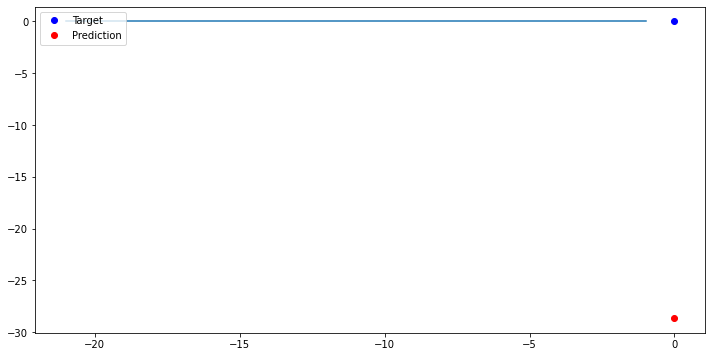

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.22085890e-01 3.25490196e-01
   1.62790698e-01 2.90734824e-01 6.92913386e-01 2.24489796e-01
   1.13028553e-01 1.68299831e-04 1.77996916e-03]
  [0.00000000e+00 0.00000000e+00 3.06748466e-01 2.70588235e-01
   1.62790698e-01 2.90734824e-01 6.69291339e-01 2.24489796e-01
   1.60433943e-01 1.68299831e-04 1.77996916e-03]
  [0.00000000e+00 0.00000000e+00 3.68098160e-01 3.37254902e-01
   1.62790698e-01 2.90734824e-01 6.53543307e-01 2.24489796e-01
   1.35471955e-01 1.68299831e-04 1.77996916e-03]
  [0.00000000e+00 0.00000000e+00 3.31288344e-01 3.60784314e-01
   1.62790698e-01 2.90734824e-01 7.16535433e-01 2.24489796e-01
   1.19492925e-01 1.68299831e-04 1.77996916e-03]
  [0.00000000e+00 0.00000000e+00 3.12883436e-01 3.17647059e-01
   1.62790698e-01 2.90734824e-01 6.85039370e-01 2.24489796e-01
   1.04054924e-01 1.68299831e-04 1.77996916e-03]
  [0.00000000e+00 0.00000000e+00 2.94478528e-01 3.25490196e-01
   1.62790698e-01 2.90734824e-01 6.77165354e-01 2.2

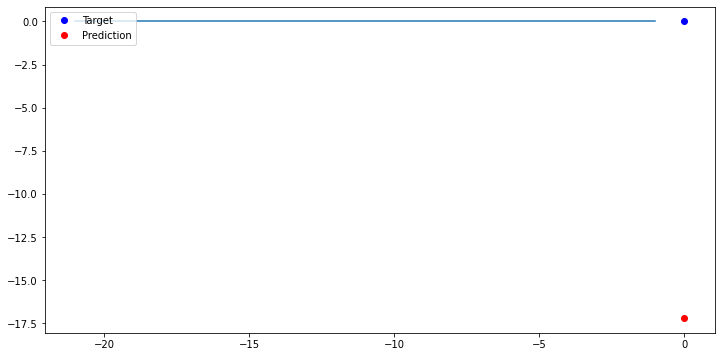

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.52760736e-01 3.84313725e-01
   1.62790698e-01 2.90734824e-01 6.89636139e-01 2.24489796e-01
   1.15901607e-01 1.18644158e-04 1.70615657e-03]
  [0.00000000e+00 0.00000000e+00 3.71165644e-01 3.68627451e-01
   1.62790698e-01 2.90734824e-01 6.92913386e-01 2.24489796e-01
   1.01237838e-01 1.18644158e-04 1.70615657e-03]
  [0.00000000e+00 0.00000000e+00 3.52760736e-01 3.64705882e-01
   1.62790698e-01 2.90734824e-01 7.00787402e-01 2.24489796e-01
   9.76651773e-02 1.18644158e-04 1.70615657e-03]
  [0.00000000e+00 0.00000000e+00 3.19018405e-01 3.25490196e-01
   1.62790698e-01 2.90734824e-01 6.92913386e-01 2.24489796e-01
   8.79919405e-02 1.18644158e-04 1.70615657e-03]
  [0.00000000e+00 0.00000000e+00 3.46625767e-01 3.49019608e-01
   1.62790698e-01 2.90734824e-01 7.00787402e-01 2.24489796e-01
   1.14483736e-01 1.18644158e-04 1.70615657e-03]
  [0.00000000e+00 0.00000000e+00 3.46625767e-01 3.80392157e-01
   1.62790698e-01 2.90734824e-01 6.61417323e-01 2.2

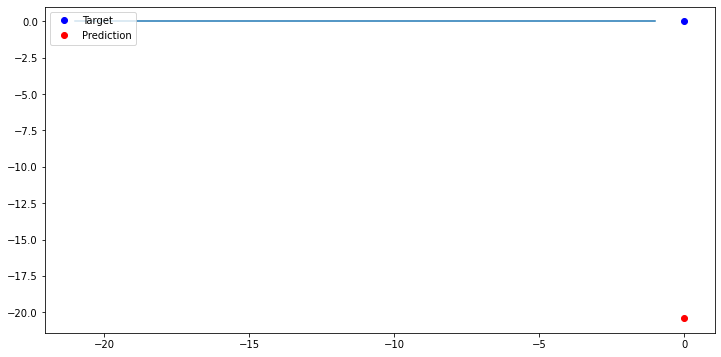

tf.Tensor(
[[[1.31120027e-05 0.00000000e+00 1.87315563e-01 2.47908709e-01
   1.62790698e-01 2.01277955e-01 3.77952756e-01 2.24489796e-01
   6.26475005e-02 7.32555823e-05 1.35362924e-03]
  [1.31120027e-05 0.00000000e+00 2.00642803e-01 2.68984394e-01
   1.62790698e-01 2.46006390e-01 3.70078740e-01 2.24489796e-01
   6.42146209e-02 7.32555823e-05 1.35362924e-03]
  [1.31120027e-05 0.00000000e+00 2.26667794e-01 2.93175431e-01
   1.62790698e-01 2.36421725e-01 4.09448819e-01 2.24489796e-01
   7.14532243e-02 7.32555823e-05 1.35362924e-03]
  [1.31120027e-05 0.00000000e+00 2.14812099e-01 2.88052118e-01
   1.62790698e-01 2.55591054e-01 3.93700787e-01 2.24489796e-01
   7.84119847e-02 7.32555823e-05 1.35362924e-03]
  [1.31120027e-05 0.00000000e+00 1.99836987e-01 2.68925420e-01
   1.62790698e-01 2.14057508e-01 4.09448819e-01 2.24489796e-01
   8.57531972e-02 7.32555823e-05 1.35362924e-03]
  [1.31120027e-05 0.00000000e+00 1.96438892e-01 2.78304970e-01
   1.62790698e-01 2.10862620e-01 4.48818898e-01 2.2

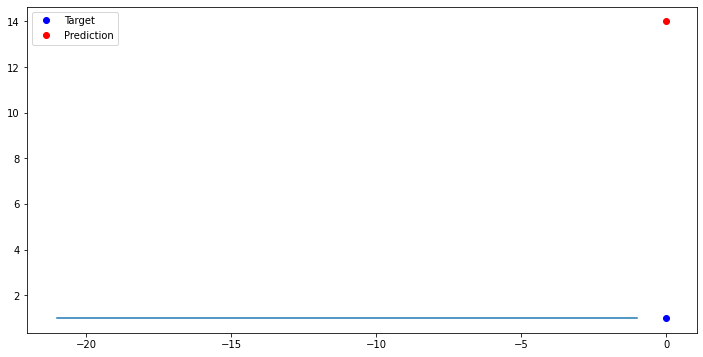

tf.Tensor(
[[[4.72032098e-04 0.00000000e+00 3.12883436e-01 3.49019608e-01
   1.62790698e-01 2.90734824e-01 4.25196850e-01 4.69387755e-01
   1.50611457e-01 5.81636741e-04 3.45195876e-03]
  [4.72032098e-04 0.00000000e+00 3.52760736e-01 4.35294118e-01
   1.62790698e-01 2.90734824e-01 5.51181102e-01 3.82418784e-01
   1.58568324e-01 5.81636741e-04 3.45195876e-03]
  [5.24480109e-04 0.00000000e+00 3.46625767e-01 3.49059402e-01
   1.62790698e-01 2.90734824e-01 4.96062992e-01 3.34682315e-01
   1.21078701e-01 5.81636741e-04 3.45195876e-03]
  [5.37592112e-04 0.00000000e+00 3.37423313e-01 3.56862745e-01
   1.62790698e-01 2.90734824e-01 4.64566929e-01 3.67346939e-01
   1.24436816e-01 5.81636741e-04 3.45195876e-03]
  [5.63816117e-04 0.00000000e+00 3.31288344e-01 3.45098039e-01
   1.62790698e-01 2.90734824e-01 4.64566929e-01 4.08163265e-01
   1.27794931e-01 5.81636741e-04 3.45195876e-03]
  [5.63816117e-04 0.00000000e+00 3.25153374e-01 3.68627451e-01
   1.62790698e-01 2.90734824e-01 4.48818898e-01 4.0

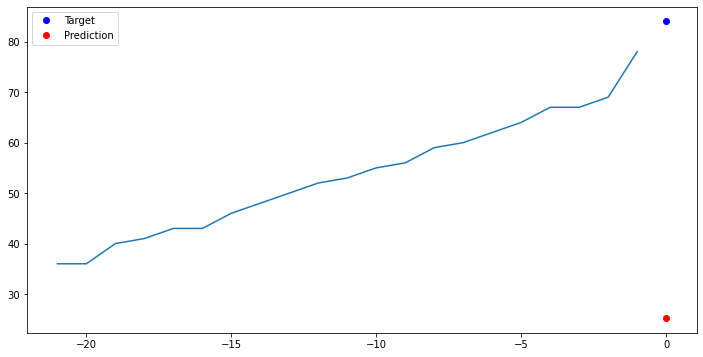

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.40490798e-01 3.21568627e-01
   1.62790698e-01 2.90734824e-01 6.69291339e-01 2.24489796e-01
   1.14968798e-01 1.32945020e-04 1.41538876e-03]
  [0.00000000e+00 0.00000000e+00 3.49693252e-01 3.17647059e-01
   1.62790698e-01 2.90734824e-01 7.00787402e-01 2.24489796e-01
   9.17604918e-02 1.32945020e-04 1.41538876e-03]
  [0.00000000e+00 0.00000000e+00 3.55828221e-01 3.09803922e-01
   1.62790698e-01 2.90734824e-01 6.61417323e-01 2.24489796e-01
   1.14931485e-01 1.32945020e-04 1.41538876e-03]
  [0.00000000e+00 0.00000000e+00 3.52760736e-01 3.05882353e-01
   1.62790698e-01 2.90734824e-01 6.45669291e-01 2.24489796e-01
   1.46973499e-01 1.32945020e-04 1.41538876e-03]
  [0.00000000e+00 0.00000000e+00 3.65030675e-01 2.78431373e-01
   1.62790698e-01 2.90734824e-01 6.45669291e-01 2.24489796e-01
   2.18678582e-01 1.32945020e-04 1.41538876e-03]
  [0.00000000e+00 0.00000000e+00 3.55828221e-01 3.33333333e-01
   1.62790698e-01 2.90734824e-01 6.89059701e-01 2.2

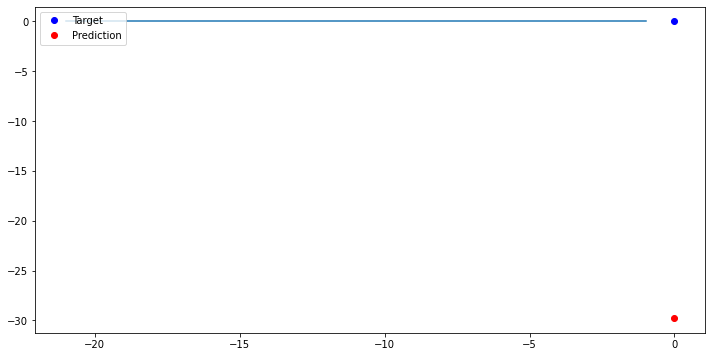

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.03680982e-01 3.29411765e-01
   9.66010733e-02 2.71565495e-01 6.85039370e-01 2.44897959e-01
   6.63694113e-02 2.32902463e-03 3.24762440e-02]
  [0.00000000e+00 0.00000000e+00 3.06748466e-01 3.29411765e-01
   1.43112701e-01 3.09904153e-01 7.40157480e-01 2.44897959e-01
   7.65556934e-02 2.32902463e-03 3.24762440e-02]
  [0.00000000e+00 0.00000000e+00 3.25153374e-01 3.56862745e-01
   1.84257603e-01 3.09904153e-01 6.85039370e-01 2.04081633e-01
   8.62662425e-02 2.32902463e-03 3.24762440e-02]
  [0.00000000e+00 0.00000000e+00 3.19018405e-01 3.45098039e-01
   2.02146691e-01 3.13099042e-01 6.77165354e-01 2.24489796e-01
   8.75628481e-02 2.32902463e-03 3.24762440e-02]
  [0.00000000e+00 0.00000000e+00 3.25153374e-01 3.41176471e-01
   2.21824687e-01 3.09904153e-01 6.85039370e-01 2.04081633e-01
   9.31970187e-02 2.32902463e-03 3.24762440e-02]
  [0.00000000e+00 0.00000000e+00 3.22085890e-01 3.60784314e-01
   2.54025045e-01 3.25878594e-01 6.69291339e-01 2.2

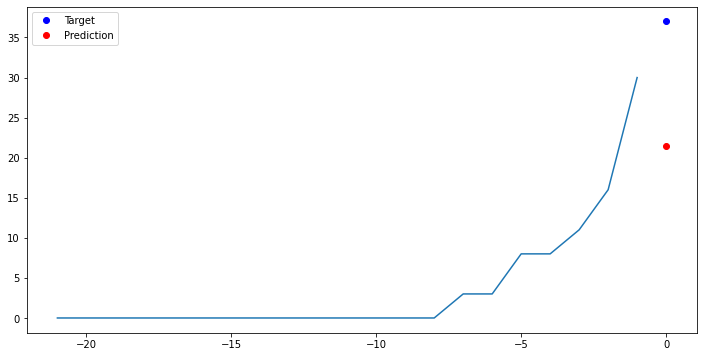

tf.Tensor(
[[[1.31120027e-04 0.00000000e+00 1.71779141e-01 2.23529412e-01
   1.48286462e-01 1.91764669e-01 3.14960630e-01 5.91836735e-01
   5.96811656e-02 8.59158132e-04 1.08831233e-02]
  [1.83568038e-04 0.00000000e+00 1.41104294e-01 2.15686275e-01
   1.47806747e-01 1.85358493e-01 3.93700787e-01 4.48979592e-01
   5.76849528e-02 8.59158132e-04 1.08831233e-02]
  [2.36016049e-04 0.00000000e+00 1.62576687e-01 1.88235294e-01
   1.68383582e-01 1.76812338e-01 3.85826772e-01 4.08163265e-01
   4.05772227e-02 8.59158132e-04 1.08831233e-02]
  [2.36016049e-04 0.00000000e+00 1.74846626e-01 2.23529412e-01
   1.74282076e-01 1.96494498e-01 3.30708661e-01 5.30612245e-01
   5.15097525e-02 8.59158132e-04 1.08831233e-02]
  [3.40912071e-04 0.00000000e+00 1.65644172e-01 2.15686275e-01
   1.83355114e-01 2.06367315e-01 3.14960630e-01 5.71428571e-01
   5.18362359e-02 8.59158132e-04 1.08831233e-02]
  [3.54024074e-04 0.00000000e+00 1.84049080e-01 2.27450980e-01
   1.79297207e-01 2.05018097e-01 3.14960630e-01 5.3

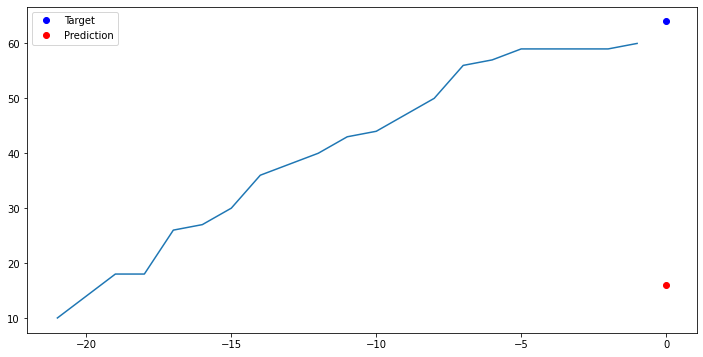

tf.Tensor(
[[[2.24215247e-03 1.19599342e-03 2.11656442e-01 3.01960784e-01
   1.62790698e-01 1.62939297e-01 2.20472441e-01 6.49630080e-01
   8.38875778e-02 2.94621116e-04 3.29566733e-03]
  [2.41260850e-03 1.19599342e-03 1.99386503e-01 3.05882353e-01
   1.62790698e-01 1.80248273e-01 4.09448819e-01 4.79280045e-01
   7.89996549e-02 2.94621116e-04 3.29566733e-03]
  [2.62240055e-03 1.19599342e-03 1.50306748e-01 2.11764706e-01
   1.62790698e-01 1.56937744e-01 2.99212598e-01 4.62063455e-01
   4.41592120e-02 2.94621116e-04 3.29566733e-03]
  [2.77974458e-03 1.19599342e-03 2.54601227e-01 3.01960784e-01
   1.62790698e-01 1.88013438e-01 2.75590551e-01 5.83340142e-01
   8.37849687e-02 2.94621116e-04 3.29566733e-03]
  [2.83219259e-03 1.19599342e-03 2.48466258e-01 3.09803922e-01
   1.62790698e-01 2.07667732e-01 2.83464567e-01 5.75639529e-01
   8.50069494e-02 2.94621116e-04 3.29566733e-03]
  [2.97642462e-03 1.19599342e-03 2.82208589e-01 3.29411765e-01
   1.62790698e-01 1.78913738e-01 2.67716535e-01 5.6

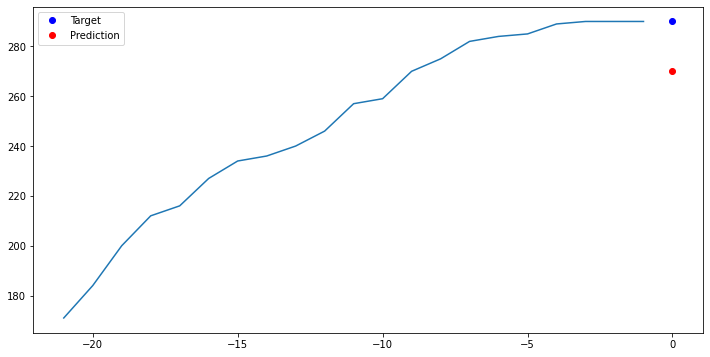

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 2.23926380e-01 2.74509804e-01
   1.62790698e-01 2.52396166e-01 5.03937008e-01 4.69387755e-01
   7.26565488e-02 1.48930826e-04 3.61572111e-03]
  [0.00000000e+00 0.00000000e+00 2.17791411e-01 2.78431373e-01
   1.62790698e-01 1.85303514e-01 5.74803150e-01 4.69387755e-01
   7.50352136e-02 1.48930826e-04 3.61572111e-03]
  [0.00000000e+00 0.00000000e+00 1.87116564e-01 3.33333333e-01
   1.62790698e-01 2.14057508e-01 8.89763780e-01 4.79468566e-01
   5.59499268e-02 1.48930826e-04 3.61572111e-03]
  [1.31120027e-05 0.00000000e+00 2.33128834e-01 3.25490196e-01
   1.62790698e-01 1.89753423e-01 5.43307087e-01 4.41027553e-01
   4.57170042e-02 1.48930826e-04 3.61572111e-03]
  [1.31120027e-05 0.00000000e+00 1.41104294e-01 1.49019608e-01
   1.62790698e-01 1.94888179e-01 4.72440945e-01 5.10204082e-01
   4.94575712e-02 1.48930826e-04 3.61572111e-03]
  [1.31120027e-05 0.00000000e+00 1.80981595e-01 2.19607843e-01
   1.62790698e-01 2.04472843e-01 4.56692913e-01 4.8

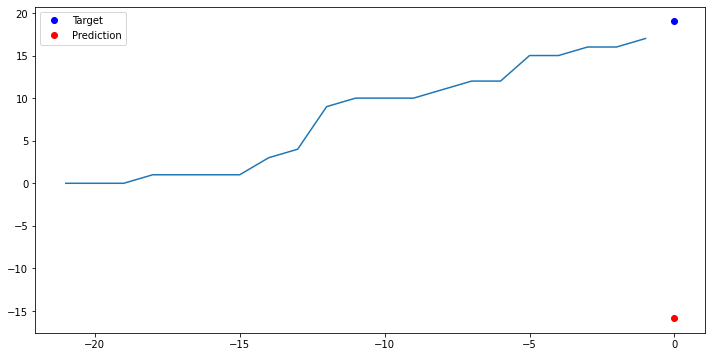

tf.Tensor(
[[[1.36364828e-03 5.97996711e-04 2.17791411e-01 3.01960784e-01
   1.52057245e-01 2.39616613e-01 2.99212598e-01 6.32653061e-01
   6.94476834e-02 1.37782550e-03 1.76007661e-02]
  [1.37676029e-03 5.97996711e-04 2.20858896e-01 2.94117647e-01
   2.37924866e-01 2.36421725e-01 3.07086614e-01 5.71428571e-01
   8.66207102e-02 1.37782550e-03 1.76007661e-02]
  [1.41609629e-03 5.97996711e-04 2.23926380e-01 3.21568627e-01
   2.77280859e-01 2.33226837e-01 4.40944882e-01 4.08163265e-01
   7.44288873e-02 1.37782550e-03 1.76007661e-02]
  [1.41609629e-03 5.97996711e-04 2.08588957e-01 2.66666667e-01
   1.30590340e-01 1.91693291e-01 4.17322835e-01 4.08163265e-01
   4.95135397e-02 1.37782550e-03 1.76007661e-02]
  [1.44232030e-03 7.47495889e-04 2.48466258e-01 3.13725490e-01
   2.77280859e-01 2.61980831e-01 3.14960630e-01 5.71428571e-01
   7.81507980e-02 1.37782550e-03 1.76007661e-02]
  [1.49476831e-03 7.47495889e-04 2.39263804e-01 3.21568627e-01
   2.23613596e-01 2.55591054e-01 3.07086614e-01 4.4

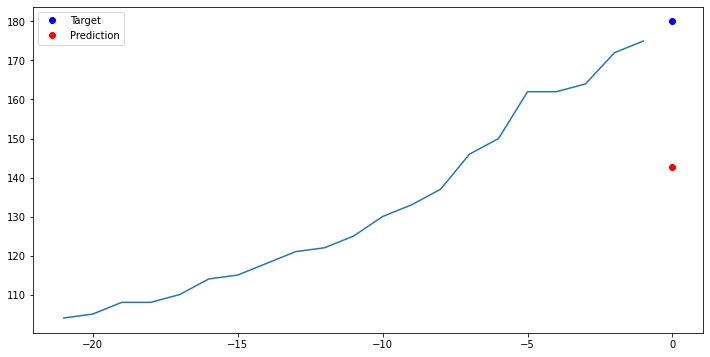

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.68098160e-01 3.45098039e-01
   1.62790698e-01 2.90734824e-01 5.90551181e-01 2.65306122e-01
   1.03355317e-01 5.13820893e-04 6.45586216e-03]
  [0.00000000e+00 0.00000000e+00 3.55828221e-01 3.37254902e-01
   1.62790698e-01 2.90734824e-01 6.69291339e-01 2.24489796e-01
   1.19567549e-01 5.13820893e-04 6.45586216e-03]
  [0.00000000e+00 0.00000000e+00 3.80368098e-01 3.60784314e-01
   1.62790698e-01 2.90734824e-01 6.53543307e-01 2.04081633e-01
   1.25192392e-01 5.13820893e-04 6.45586216e-03]
  [0.00000000e+00 0.00000000e+00 3.89570552e-01 3.68627451e-01
   1.62790698e-01 2.90734824e-01 6.37795276e-01 1.92877151e-01
   8.45032322e-02 5.13820893e-04 6.45586216e-03]
  [0.00000000e+00 0.00000000e+00 3.52760736e-01 3.41176471e-01
   1.62790698e-01 2.90734824e-01 6.61417323e-01 2.65306122e-01
   9.62846189e-02 5.13820893e-04 6.45586216e-03]
  [0.00000000e+00 0.00000000e+00 3.95705521e-01 3.76470588e-01
   1.62790698e-01 2.90734824e-01 6.69291339e-01 2.0

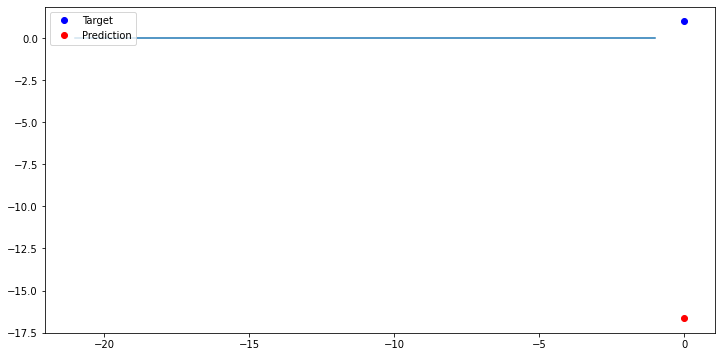

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 2.20858896e-01 3.41176471e-01
   1.75554739e-01 2.90734824e-01 4.56692913e-01 4.69387755e-01
   8.08652743e-02 5.35476429e-04 4.52458218e-03]
  [0.00000000e+00 0.00000000e+00 2.11656442e-01 3.37254902e-01
   1.42379059e-01 2.90734824e-01 5.11811024e-01 4.79468566e-01
   7.75071593e-02 5.35476429e-04 4.52458218e-03]
  [0.00000000e+00 0.00000000e+00 2.05521472e-01 2.94117647e-01
   1.18067979e-01 2.90734824e-01 4.56692913e-01 4.41027553e-01
   5.97278061e-02 5.35476429e-04 4.52458218e-03]
  [0.00000000e+00 0.00000000e+00 2.05521472e-01 3.25490196e-01
   1.53761206e-01 2.90734824e-01 4.25196850e-01 4.48979592e-01
   7.19849258e-02 5.35476429e-04 4.52458218e-03]
  [0.00000000e+00 0.00000000e+00 1.90184049e-01 2.70588235e-01
   1.52295602e-01 2.90734824e-01 3.85826772e-01 5.30612245e-01
   5.56047872e-02 5.35476429e-04 4.52458218e-03]
  [0.00000000e+00 0.00000000e+00 1.90184049e-01 2.90196078e-01
   1.71431178e-01 2.90734824e-01 4.01574803e-01 5.3

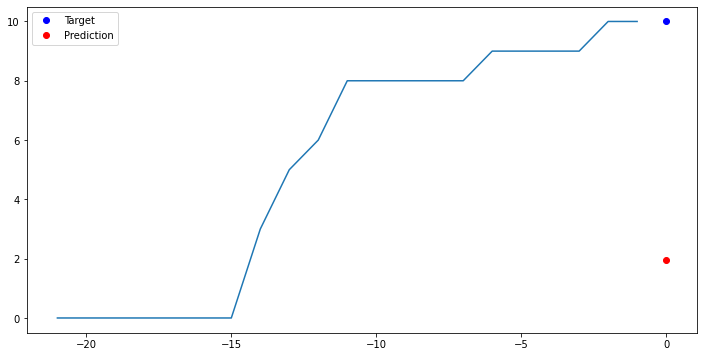

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 2.02453988e-01 5.37254902e-01
   1.62790698e-01 3.09904153e-01 4.56692913e-01 3.87755102e-01
   8.65274293e-02 2.70991356e-04 3.68724261e-03]
  [0.00000000e+00 0.00000000e+00 1.87116564e-01 6.15686275e-01
   1.62790698e-01 3.22683706e-01 5.27559055e-01 4.22544683e-01
   8.90646717e-02 2.70991356e-04 3.68724261e-03]
  [0.00000000e+00 0.00000000e+00 1.71779141e-01 6.19607843e-01
   1.62790698e-01 3.13099042e-01 4.64566929e-01 4.08907003e-01
   5.84591849e-02 2.70991356e-04 3.68724261e-03]
  [0.00000000e+00 0.00000000e+00 1.84049080e-01 4.43137255e-01
   1.62790698e-01 2.97124601e-01 4.48818898e-01 4.48979592e-01
   6.74421425e-02 2.70991356e-04 3.68724261e-03]
  [1.31120027e-05 0.00000000e+00 1.65644172e-01 4.70588235e-01
   1.62790698e-01 2.77955272e-01 4.01574803e-01 5.10204082e-01
   6.69197690e-02 2.70991356e-04 3.68724261e-03]
  [1.31120027e-05 0.00000000e+00 1.96319018e-01 4.98039216e-01
   1.62790698e-01 3.09904153e-01 4.09448819e-01 4.8

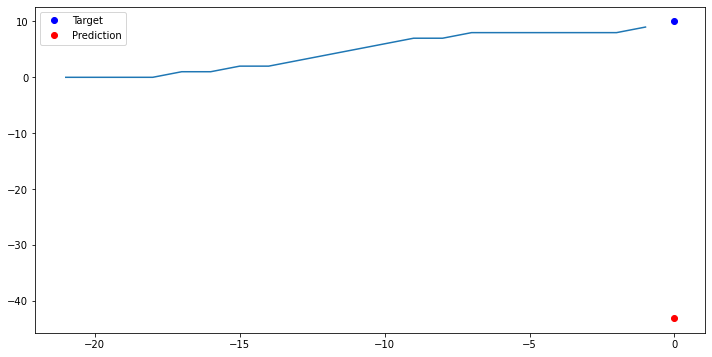

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.19018405e-01 3.56862745e-01
   1.57423971e-01 2.61980831e-01 6.61417323e-01 2.24489796e-01
   1.26899434e-01 7.34308816e-04 9.25237311e-03]
  [0.00000000e+00 0.00000000e+00 3.34355828e-01 3.72549020e-01
   1.94991055e-01 3.26234723e-01 6.77165354e-01 2.04081633e-01
   9.60047760e-02 7.34308816e-04 9.25237311e-03]
  [0.00000000e+00 0.00000000e+00 3.19018405e-01 3.29411765e-01
   1.81346242e-01 3.19488818e-01 6.69291339e-01 2.24489796e-01
   8.48763561e-02 7.34308816e-04 9.25237311e-03]
  [0.00000000e+00 0.00000000e+00 3.31288344e-01 3.45098039e-01
   2.52236136e-01 2.68370607e-01 6.61417323e-01 2.24489796e-01
   9.20683190e-02 7.34308816e-04 9.25237311e-03]
  [0.00000000e+00 0.00000000e+00 3.25153374e-01 3.21568627e-01
   1.92192691e-01 3.19488818e-01 6.61417323e-01 2.24489796e-01
   8.87848288e-02 7.34308816e-04 9.25237311e-03]
  [0.00000000e+00 0.00000000e+00 3.22085890e-01 3.25490196e-01
   2.61180680e-01 3.13099042e-01 6.53543307e-01 2.2

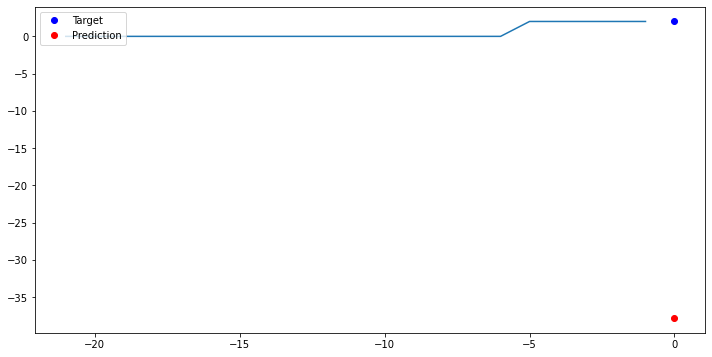

tf.Tensor(
[[[2.75352057e-04 1.49499178e-04 1.71779141e-01 3.41176471e-01
   1.65547234e-01 2.90734824e-01 4.33070866e-01 3.87755102e-01
   6.88600132e-02 6.91127926e-04 9.22009878e-03]
  [2.75352057e-04 1.49499178e-04 8.89570552e-02 1.01960784e-01
   5.00894454e-02 2.90734824e-01 2.91338583e-01 4.62063455e-01
   2.77790733e-02 6.91127926e-04 9.22009878e-03]
  [2.88464060e-04 1.49499178e-04 2.08588957e-01 2.62745098e-01
   1.28585928e-01 2.90734824e-01 3.77952756e-01 5.30612245e-01
   6.70690186e-02 6.91127926e-04 9.22009878e-03]
  [2.88464060e-04 1.49499178e-04 2.11656442e-01 2.82352941e-01
   1.60497871e-01 2.90734824e-01 3.77952756e-01 5.30612245e-01
   6.58750222e-02 6.91127926e-04 9.22009878e-03]
  [2.88464060e-04 1.49499178e-04 2.69938650e-01 3.21568627e-01
   1.58542960e-01 2.90734824e-01 3.70078740e-01 4.89795918e-01
   7.33374999e-02 6.91127926e-04 9.22009878e-03]
  [2.88464060e-04 1.49499178e-04 2.36196319e-01 3.17647059e-01
   1.61345338e-01 2.90734824e-01 3.85826772e-01 4.8

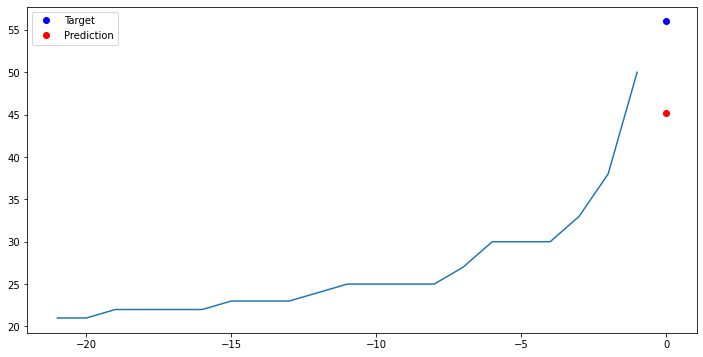

tf.Tensor(
[[[7.86720164e-04 0.00000000e+00 1.71779141e-01 2.82352941e-01
   1.34168157e-01 1.72523962e-01 3.07086614e-01 6.12244898e-01
   5.53156162e-02 9.27708478e-04 2.68513462e-02]
  [8.12944169e-04 0.00000000e+00 1.80981595e-01 3.01960784e-01
   1.89624329e-01 1.78913738e-01 3.07086614e-01 5.91836735e-01
   5.87296997e-02 9.27708478e-04 2.68513462e-02]
  [8.91616185e-04 0.00000000e+00 1.77914110e-01 3.05882353e-01
   2.68336315e-01 1.85303514e-01 3.07086614e-01 5.91836735e-01
   6.12949264e-02 9.27708478e-04 2.68513462e-02]
  [9.44064196e-04 0.00000000e+00 1.74846626e-01 2.94117647e-01
   3.05903399e-01 1.75718850e-01 3.14960630e-01 6.32653061e-01
   7.15185209e-02 9.27708478e-04 2.68513462e-02]
  [1.00962421e-03 0.00000000e+00 1.68711656e-01 3.33333333e-01
   1.91208585e-01 1.98083067e-01 3.93700787e-01 4.48979592e-01
   6.70876748e-02 9.27708478e-04 2.68513462e-02]
  [1.00962421e-03 0.00000000e+00 1.71779141e-01 2.98039216e-01
   1.67391422e-01 1.56549521e-01 3.93700787e-01 4.2

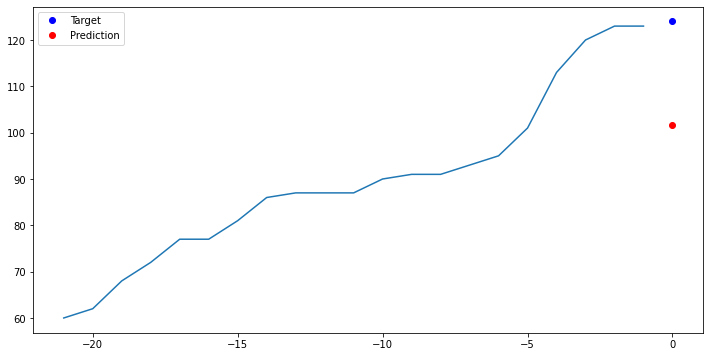

tf.Tensor(
[[[1.88812839e-03 5.97996711e-04 2.49276581e-01 3.29398822e-01
   1.62790698e-01 2.90734824e-01 4.40944882e-01 2.24489796e-01
   1.03327332e-01 1.61219133e-04 2.50076253e-03]
  [1.95368841e-03 5.97996711e-04 2.36170810e-01 3.19092163e-01
   1.62790698e-01 2.90734824e-01 4.17322835e-01 2.24489796e-01
   1.11442777e-01 1.61219133e-04 2.50076253e-03]
  [1.95368841e-03 5.97996711e-04 2.48084458e-01 3.69877182e-01
   1.62790698e-01 2.90734824e-01 5.59055118e-01 2.24489796e-01
   1.08793597e-01 1.61219133e-04 2.50076253e-03]
  [1.99302441e-03 7.47495889e-04 2.50623637e-01 3.49059402e-01
   1.62790698e-01 2.90734824e-01 5.43307087e-01 2.24489796e-01
   6.98954320e-02 1.61219133e-04 2.50076253e-03]
  [1.99302441e-03 7.47495889e-04 2.43535301e-01 3.00761169e-01
   1.62790698e-01 2.90734824e-01 4.64566929e-01 2.24489796e-01
   8.72550208e-02 1.61219133e-04 2.50076253e-03]
  [2.07169643e-03 7.47495889e-04 2.51138650e-01 3.17058325e-01
   1.62790698e-01 2.90734824e-01 4.72440945e-01 2.2

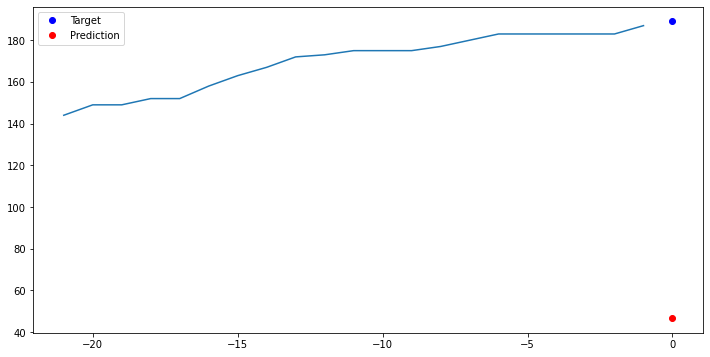

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 2.69938650e-01 3.29411765e-01
   1.62790698e-01 2.90734824e-01 6.53543307e-01 2.47165533e-01
   8.55293229e-02 3.87185607e-04 3.16666962e-03]
  [0.00000000e+00 0.00000000e+00 2.94478528e-01 3.45098039e-01
   1.62790698e-01 2.90734824e-01 7.71653543e-01 2.38245198e-01
   1.23578631e-01 3.87185607e-04 3.16666962e-03]
  [0.00000000e+00 0.00000000e+00 3.09815951e-01 4.00000000e-01
   1.62790698e-01 2.90734824e-01 6.37795276e-01 2.02996813e-01
   1.28587819e-01 3.87185607e-04 3.16666962e-03]
  [0.00000000e+00 0.00000000e+00 3.09815951e-01 4.62745098e-01
   1.62790698e-01 2.90734824e-01 6.45669291e-01 2.08692366e-01
   8.25816442e-02 3.87185607e-04 3.16666962e-03]
  [0.00000000e+00 0.00000000e+00 2.82208589e-01 3.33333333e-01
   1.62790698e-01 2.90734824e-01 6.69291339e-01 2.32393994e-01
   9.25906924e-02 3.87185607e-04 3.16666962e-03]
  [0.00000000e+00 0.00000000e+00 3.03680982e-01 3.52941176e-01
   1.62790698e-01 2.90734824e-01 6.61417323e-01 2.2

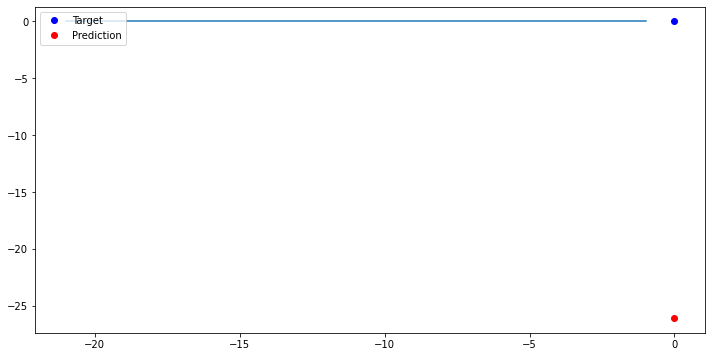

tf.Tensor(
[[[6.55600136e-05 0.00000000e+00 1.50306748e-01 3.41176471e-01
   1.62790698e-01 2.01277955e-01 5.03937008e-01 2.24489796e-01
   6.14161917e-02 2.18273017e-04 1.65943848e-03]
  [6.55600136e-05 0.00000000e+00 2.82208589e-01 3.52941176e-01
   1.62790698e-01 2.46006390e-01 5.03937008e-01 2.24489796e-01
   7.95127002e-02 2.18273017e-04 1.65943848e-03]
  [6.55600136e-05 0.00000000e+00 2.42331288e-01 3.45098039e-01
   1.62790698e-01 2.52396166e-01 4.40944882e-01 2.24489796e-01
   6.95782767e-02 2.18273017e-04 1.65943848e-03]
  [6.55600136e-05 0.00000000e+00 2.42331288e-01 3.37254902e-01
   1.62790698e-01 2.71565495e-01 4.33070866e-01 2.24489796e-01
   7.00353535e-02 2.18273017e-04 1.65943848e-03]
  [1.04896022e-04 1.49499178e-04 2.54601227e-01 3.56862745e-01
   1.62790698e-01 2.36421725e-01 4.17322835e-01 2.24489796e-01
   7.34867494e-02 2.18273017e-04 1.65943848e-03]
  [1.70456035e-04 1.49499178e-04 2.30061350e-01 4.03921569e-01
   1.62790698e-01 2.33226837e-01 4.33070866e-01 2.2

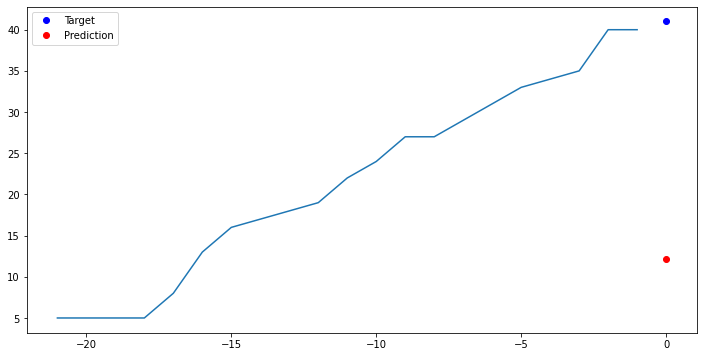

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.31288344e-01 3.45098039e-01
   1.82468694e-01 3.35463259e-01 6.92913386e-01 2.04081633e-01
   9.93069224e-02 1.91012578e-03 3.16913004e-02]
  [0.00000000e+00 0.00000000e+00 3.43558282e-01 3.52941176e-01
   1.75313059e-01 3.25878594e-01 6.92913386e-01 2.04081633e-01
   1.01722900e-01 1.91012578e-03 3.16913004e-02]
  [0.00000000e+00 0.00000000e+00 3.31288344e-01 3.29411765e-01
   1.46690519e-01 3.13099042e-01 6.77165354e-01 2.44897959e-01
   9.73853344e-02 1.91012578e-03 3.16913004e-02]
  [0.00000000e+00 0.00000000e+00 3.34355828e-01 3.29411765e-01
   1.55635063e-01 3.13099042e-01 6.92913386e-01 2.24489796e-01
   1.07767507e-01 1.91012578e-03 3.16913004e-02]
  [0.00000000e+00 0.00000000e+00 3.31288344e-01 3.25490196e-01
   2.20035778e-01 3.25878594e-01 6.85039370e-01 1.83673469e-01
   1.32141824e-01 1.91012578e-03 3.16913004e-02]
  [0.00000000e+00 0.00000000e+00 3.40490798e-01 3.29411765e-01
   2.84436494e-01 3.80191693e-01 7.16535433e-01 1.8

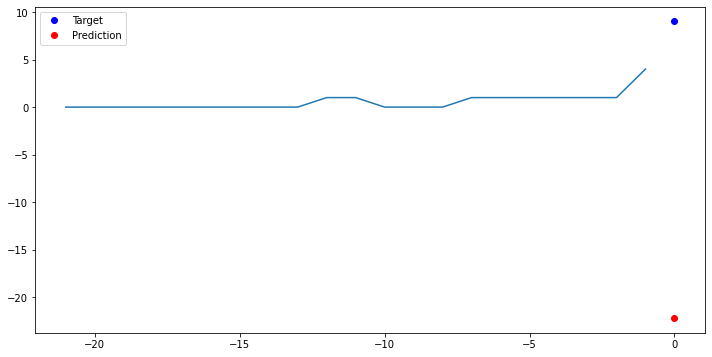

tf.Tensor(
[[[1.31120027e-05 0.00000000e+00 2.08588957e-01 4.11764706e-01
   1.69946333e-01 2.93929712e-01 4.64566929e-01 5.10204082e-01
   6.99793849e-02 1.68659254e-03 1.17674798e-02]
  [5.24480109e-05 0.00000000e+00 2.05521472e-01 4.11764706e-01
   3.29159213e-01 2.84345048e-01 4.40944882e-01 5.10204082e-01
   8.42607017e-02 1.68659254e-03 1.17674798e-02]
  [5.24480109e-05 0.00000000e+00 1.71779141e-01 3.56862745e-01
   2.09302326e-01 2.97124601e-01 4.72440945e-01 4.48979592e-01
   6.32818111e-02 1.68659254e-03 1.17674798e-02]
  [5.24480109e-05 0.00000000e+00 1.62576687e-01 3.05882353e-01
   1.68157424e-01 2.65175719e-01 4.40944882e-01 4.08163265e-01
   4.55024580e-02 1.68659254e-03 1.17674798e-02]
  [6.55600136e-05 0.00000000e+00 2.17791411e-01 3.72549020e-01
   2.88014311e-01 2.65175719e-01 3.93700787e-01 4.89795918e-01
   6.07912092e-02 1.68659254e-03 1.17674798e-02]
  [6.55600136e-05 0.00000000e+00 1.93251534e-01 3.25490196e-01
   1.96779964e-01 2.68370607e-01 3.62204724e-01 5.7

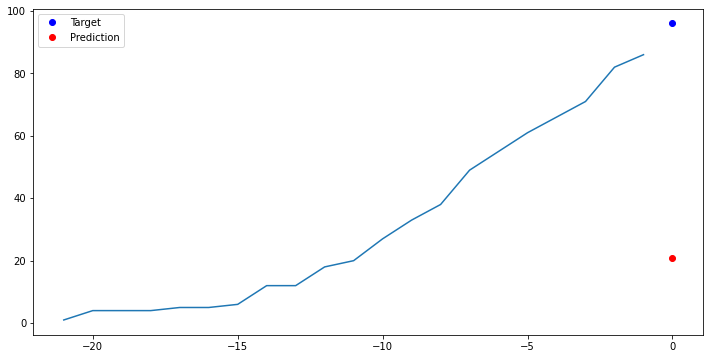

tf.Tensor(
[[[2.62240055e-05 0.00000000e+00 1.93251534e-01 2.43137255e-01
   1.62790698e-01 2.90734824e-01 4.01574803e-01 4.41027553e-01
   4.17898753e-02 5.39569425e-04 8.35785618e-03]
  [2.62240055e-05 0.00000000e+00 1.84049080e-01 2.35294118e-01
   1.62790698e-01 2.90734824e-01 3.46456693e-01 5.71428571e-01
   4.22749363e-02 5.39569425e-04 8.35785618e-03]
  [7.86720164e-05 0.00000000e+00 1.93251534e-01 2.58823529e-01
   1.62790698e-01 2.90734824e-01 3.38582677e-01 5.91836735e-01
   4.29558874e-02 5.39569425e-04 8.35785618e-03]
  [7.86720164e-05 0.00000000e+00 1.99386503e-01 2.54901961e-01
   1.62790698e-01 2.90734824e-01 3.30708661e-01 5.91836735e-01
   4.78251541e-02 5.39569425e-04 8.35785618e-03]
  [7.86720164e-05 0.00000000e+00 1.74846626e-01 2.35294118e-01
   1.62790698e-01 2.90734824e-01 3.22834646e-01 6.12244898e-01
   5.06142552e-02 5.39569425e-04 8.35785618e-03]
  [9.17840191e-05 0.00000000e+00 1.87116564e-01 2.39215686e-01
   1.62790698e-01 2.90734824e-01 3.38582677e-01 6.3

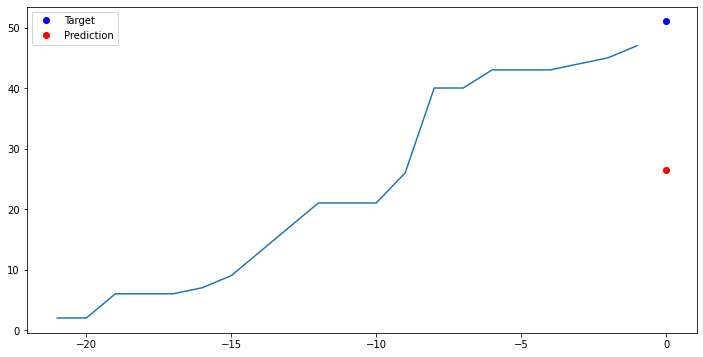

tf.Tensor(
[[[0.00119319 0.00269099 0.1993865  0.27843137 0.1627907  0.20447284
   0.31496063 0.59183673 0.08606102 0.00111513 0.01150929]
  [0.0013112  0.00298998 0.1993865  0.31764706 0.1627907  0.21051153
   0.45669291 0.40816327 0.07735791 0.00111513 0.01150929]
  [0.00136365 0.00313948 0.1993865  0.27058824 0.1627907  0.20013857
   0.43307087 0.42857143 0.04527858 0.00111513 0.01150929]
  [0.00149477 0.00328898 0.23312883 0.30980392 0.1627907  0.21519833
   0.36220472 0.53061224 0.07855191 0.00111513 0.01150929]
  [0.00156033 0.00343848 0.23006135 0.29411765 0.1627907  0.22447864
   0.34645669 0.42857143 0.08020298 0.00111513 0.01150929]
  [0.001639   0.00358798 0.23006135 0.30980392 0.1627907  0.22257918
   0.33858268 0.57142857 0.07941009 0.00111513 0.01150929]
  [0.00167834 0.00418598 0.21472393 0.30980392 0.1627907  0.22241543
   0.34645669 0.57142857 0.0795127  0.00111513 0.01150929]
  [0.00187502 0.00448498 0.21472393 0.31372549 0.1627907  0.21405751
   0.33070866 0.57142857

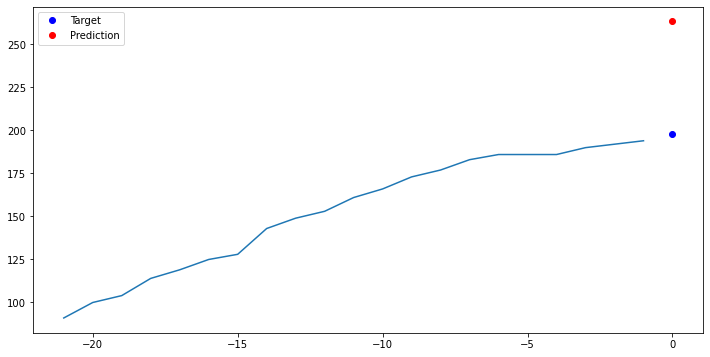

tf.Tensor(
[[[2.59617654e-03 1.34549260e-03 1.65644172e-01 2.27450980e-01
   1.35957066e-01 1.40575080e-01 2.44094488e-01 6.93877551e-01
   4.96161488e-02 7.26014098e-04 3.55346352e-02]
  [2.64862455e-03 1.34549260e-03 1.84049080e-01 2.50980392e-01
   1.41323792e-01 1.72523962e-01 2.36220472e-01 6.73469388e-01
   5.88976055e-02 7.26014098e-04 3.55346352e-02]
  [2.84530459e-03 1.34549260e-03 1.19631902e-01 1.49019608e-01
   6.79785331e-02 1.15015974e-01 1.65354331e-01 7.95918367e-01
   3.88608528e-02 7.26014098e-04 3.55346352e-02]
  [2.93708861e-03 1.49499178e-03 1.59509202e-01 2.23529412e-01
   1.05545617e-01 1.53354633e-01 2.44094488e-01 7.34693878e-01
   5.97744466e-02 7.26014098e-04 3.55346352e-02]
  [3.02887263e-03 1.79399013e-03 1.44171779e-01 2.19607843e-01
   1.03756708e-01 1.53354633e-01 3.54330709e-01 5.51020408e-01
   5.69387051e-02 7.26014098e-04 3.55346352e-02]
  [3.13376865e-03 1.79399013e-03 1.62576687e-01 2.23529412e-01
   1.41323792e-01 1.66134185e-01 3.62204724e-01 4.6

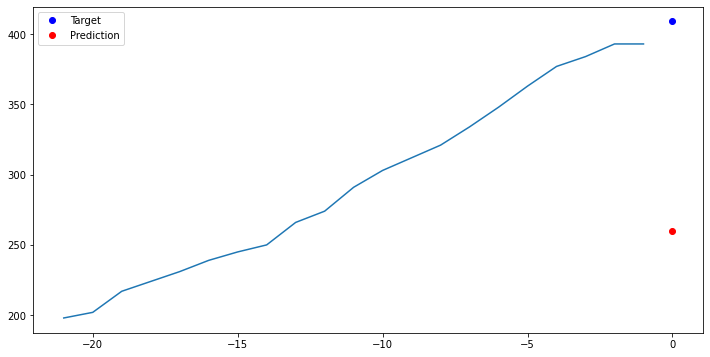

tf.Tensor(
[[[0.00224215 0.00179399 0.15644172 0.21568627 0.10017889 0.18530351
   0.35433071 0.40816327 0.03146367 0.0012235  0.0131738 ]
  [0.00226838 0.00179399 0.1595092  0.21176471 0.08765653 0.22364217
   0.38582677 0.44897959 0.04952287 0.0012235  0.0131738 ]
  [0.00230771 0.00194349 0.16564417 0.25098039 0.09302326 0.24920128
   0.38582677 0.34693878 0.05019449 0.0012235  0.0131738 ]
  [0.00230771 0.00194349 0.17177914 0.25490196 0.1019678  0.23322684
   0.37007874 0.42857143 0.05297426 0.0012235  0.0131738 ]
  [0.00237327 0.00194349 0.1595092  0.24705882 0.06440072 0.23642173
   0.36220472 0.46938776 0.05146311 0.0012235  0.0131738 ]
  [0.0028453  0.00209299 0.17484663 0.26666667 0.09123435 0.23003195
   0.38582677 0.44897959 0.06242363 0.0012235  0.0131738 ]
  [0.00289775 0.00209299 0.16564417 0.25490196 0.09838998 0.21405751
   0.44094488 0.3877551  0.04938295 0.0012235  0.0131738 ]
  [0.00296331 0.00209299 0.16871166 0.24313725 0.1019678  0.20127796
   0.38582677 0.3877551 

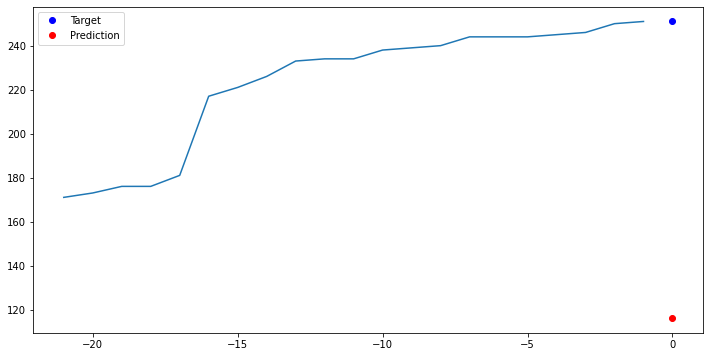

tf.Tensor(
[[[9.17840191e-05 0.00000000e+00 1.28834356e-01 2.00000000e-01
   1.62790698e-01 2.14584138e-01 1.96850394e-01 6.93877551e-01
   2.96633490e-02 4.49261728e-04 5.80141047e-03]
  [1.18008025e-04 0.00000000e+00 1.34969325e-01 1.92156863e-01
   1.62790698e-01 2.01646267e-01 2.04724409e-01 5.88136533e-01
   3.54374411e-02 4.49261728e-04 5.80141047e-03]
  [1.31120027e-04 0.00000000e+00 1.22699387e-01 1.88235294e-01
   1.62790698e-01 1.94007360e-01 3.70078740e-01 4.79468566e-01
   3.53721444e-02 4.49261728e-04 5.80141047e-03]
  [1.57344033e-04 0.00000000e+00 1.07361963e-01 1.41176471e-01
   1.62790698e-01 1.89753423e-01 3.38582677e-01 4.41027553e-01
   1.99154874e-02 4.49261728e-04 5.80141047e-03]
  [1.70456035e-04 0.00000000e+00 1.28834356e-01 1.80392157e-01
   1.62790698e-01 2.02435954e-01 2.04724409e-01 6.73469388e-01
   2.95514118e-02 4.49261728e-04 5.80141047e-03]
  [1.96680041e-04 0.00000000e+00 1.50306748e-01 2.27450980e-01
   1.62790698e-01 2.09918070e-01 1.96850394e-01 6.7

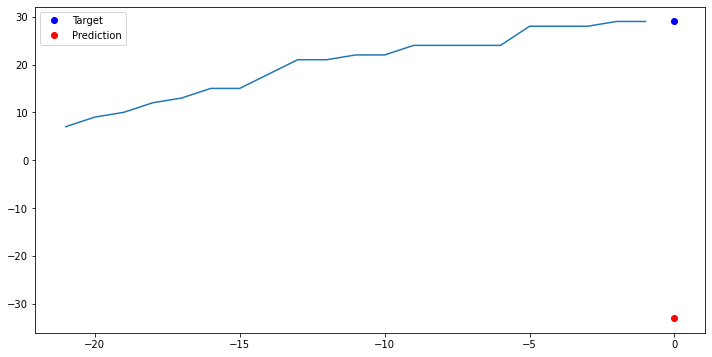

tf.Tensor(
[[[2.62240055e-05 0.00000000e+00 2.31812784e-01 2.90002580e-01
   1.62790698e-01 2.15198326e-01 4.40944882e-01 2.24489796e-01
   7.49326045e-02 1.14915212e-04 1.82260315e-03]
  [2.62240055e-05 0.00000000e+00 2.33167787e-01 2.99400691e-01
   1.62790698e-01 3.09904153e-01 4.25196850e-01 2.24489796e-01
   8.62382583e-02 1.14915212e-04 1.82260315e-03]
  [2.62240055e-05 0.00000000e+00 2.34099680e-01 3.01551947e-01
   1.62790698e-01 2.22579178e-01 4.25196850e-01 2.24489796e-01
   9.84487374e-02 1.14915212e-04 1.82260315e-03]
  [2.62240055e-05 0.00000000e+00 2.34764358e-01 3.07750072e-01
   1.62790698e-01 3.03514377e-01 4.09448819e-01 2.24489796e-01
   1.01172542e-01 1.14915212e-04 1.82260315e-03]
  [2.62240055e-05 0.00000000e+00 2.40750811e-01 3.19141132e-01
   1.62790698e-01 2.27406850e-01 4.33070866e-01 2.24489796e-01
   1.13159147e-01 1.14915212e-04 1.82260315e-03]
  [2.62240055e-05 0.00000000e+00 2.35414836e-01 3.27667431e-01
   1.62790698e-01 2.37953700e-01 5.03937008e-01 2.2

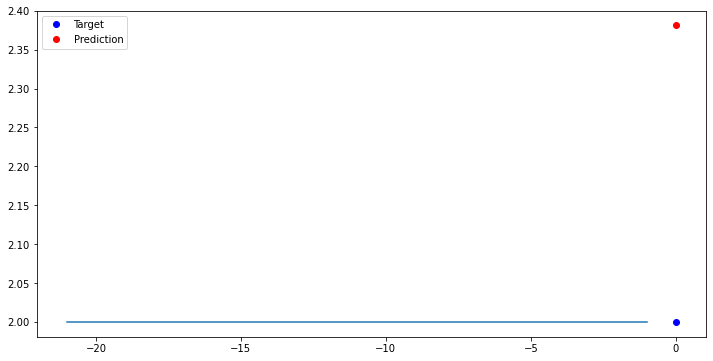

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.40490798e-01 3.76470588e-01
   1.62790698e-01 1.46964856e-01 6.53543307e-01 2.24489796e-01
   1.26339748e-01 5.06673215e-05 1.99792050e-03]
  [0.00000000e+00 0.00000000e+00 3.46625767e-01 3.84313725e-01
   1.62790698e-01 1.72523962e-01 6.77165354e-01 2.24489796e-01
   1.33186571e-01 5.06673215e-05 1.99792050e-03]
  [0.00000000e+00 0.00000000e+00 3.49693252e-01 4.11764706e-01
   1.62790698e-01 3.25878594e-01 6.85039370e-01 2.24489796e-01
   1.00957996e-01 5.06673215e-05 1.99792050e-03]
  [0.00000000e+00 0.00000000e+00 3.43558282e-01 4.23529412e-01
   1.62790698e-01 3.09904153e-01 6.53543307e-01 2.24489796e-01
   1.43400838e-01 5.06673215e-05 1.99792050e-03]
  [0.00000000e+00 0.00000000e+00 3.40490798e-01 4.19607843e-01
   1.62790698e-01 3.70607029e-01 6.85039370e-01 2.24489796e-01
   1.56497486e-01 5.06673215e-05 1.99792050e-03]
  [0.00000000e+00 0.00000000e+00 3.40490798e-01 3.92156863e-01
   1.62790698e-01 3.16293930e-01 7.16535433e-01 2.2

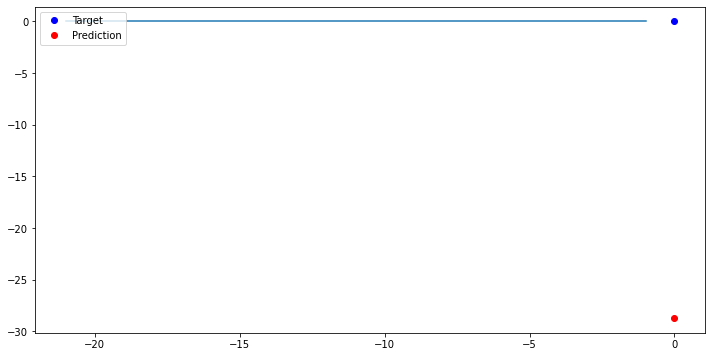

tf.Tensor(
[[[5.37592112e-04 0.00000000e+00 1.38036810e-01 2.00000000e-01
   7.87119857e-02 1.78913738e-01 3.14960630e-01 4.91255649e-01
   3.90380866e-02 2.74333887e-04 8.93690149e-03]
  [5.37592112e-04 0.00000000e+00 1.38036810e-01 2.27450980e-01
   1.27012522e-01 2.04472843e-01 3.14960630e-01 4.47023941e-01
   2.87491955e-02 2.74333887e-04 8.93690149e-03]
  [5.37592112e-04 0.00000000e+00 1.84049080e-01 2.47058824e-01
   2.12880143e-01 1.94888179e-01 2.91338583e-01 5.91836735e-01
   3.36930869e-02 2.74333887e-04 8.93690149e-03]
  [5.37592112e-04 0.00000000e+00 1.71779141e-01 2.39215686e-01
   1.57423971e-01 1.62939297e-01 2.75590551e-01 6.32653061e-01
   3.42714290e-02 2.74333887e-04 8.93690149e-03]
  [5.63816117e-04 0.00000000e+00 1.68711656e-01 2.47058824e-01
   1.16279070e-01 1.53354633e-01 2.83464567e-01 6.12244898e-01
   3.31054168e-02 2.74333887e-04 8.93690149e-03]
  [5.63816117e-04 0.00000000e+00 1.50306748e-01 2.23529412e-01
   5.90339893e-02 1.46964856e-01 2.75590551e-01 6.9

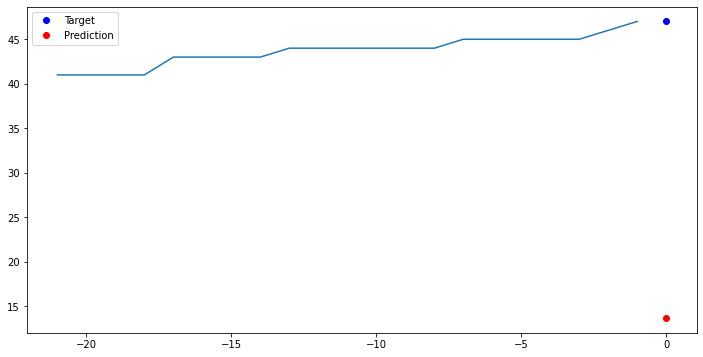

tf.Tensor(
[[[1.58655233e-03 5.97996711e-04 2.15648736e-01 2.83977221e-01
   1.66312131e-01 2.90734824e-01 2.51968504e-01 2.24489796e-01
   3.78440902e-02 2.74139044e-05 1.72259257e-03]
  [1.58655233e-03 5.97996711e-04 2.07551800e-01 2.79713118e-01
   1.55153891e-01 2.90734824e-01 2.75590551e-01 2.24489796e-01
   3.59971269e-02 2.74139044e-05 1.72259257e-03]
  [1.61277634e-03 5.97996711e-04 2.08496512e-01 2.79119110e-01
   9.66010733e-02 2.90734824e-01 2.91338583e-01 2.24489796e-01
   5.33660439e-02 2.74139044e-05 1.72259257e-03]
  [1.97991241e-03 5.97996711e-04 2.06875027e-01 2.91446389e-01
   1.18067979e-01 2.90734824e-01 2.83464567e-01 2.24489796e-01
   4.68550320e-02 2.74139044e-05 1.72259257e-03]
  [2.07169643e-03 5.97996711e-04 2.09905378e-01 2.75081411e-01
   1.00178891e-01 2.90734824e-01 2.44094488e-01 2.24489796e-01
   3.76388720e-02 2.74139044e-05 1.72259257e-03]
  [2.07169643e-03 5.97996711e-04 2.31812784e-01 2.90002580e-01
   1.75153012e-01 2.90734824e-01 3.07086614e-01 2.2

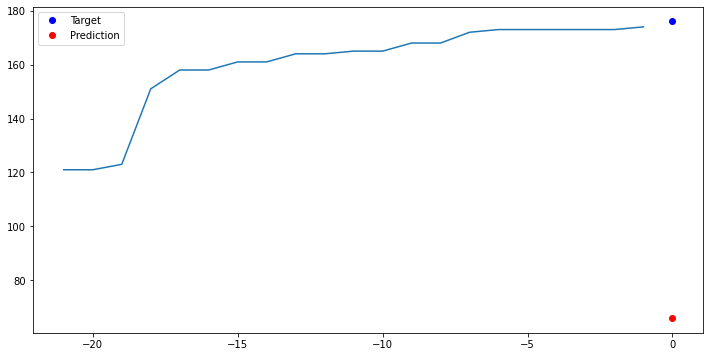

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 2.91411043e-01 3.29411765e-01
   1.62790698e-01 3.35463259e-01 6.45669291e-01 2.65306122e-01
   1.13383021e-01 6.44899285e-04 7.29081104e-03]
  [0.00000000e+00 0.00000000e+00 3.00613497e-01 3.25490196e-01
   1.62790698e-01 3.86581470e-01 6.29921260e-01 2.81346679e-01
   9.42324375e-02 6.44899285e-04 7.29081104e-03]
  [0.00000000e+00 0.00000000e+00 3.03680982e-01 3.29411765e-01
   1.62790698e-01 3.61022364e-01 5.59055118e-01 3.06122449e-01
   9.42324375e-02 6.44899285e-04 7.29081104e-03]
  [0.00000000e+00 0.00000000e+00 3.00613497e-01 3.52941176e-01
   1.62790698e-01 3.64217252e-01 5.66929134e-01 3.06122449e-01
   1.03849706e-01 6.44899285e-04 7.29081104e-03]
  [0.00000000e+00 0.00000000e+00 2.60736196e-01 3.52941176e-01
   1.62790698e-01 3.25878594e-01 5.27559055e-01 3.26530612e-01
   8.39155621e-02 6.44899285e-04 7.29081104e-03]
  [0.00000000e+00 0.00000000e+00 2.42331288e-01 3.56862745e-01
   1.62790698e-01 2.97124601e-01 5.27559055e-01 3.8

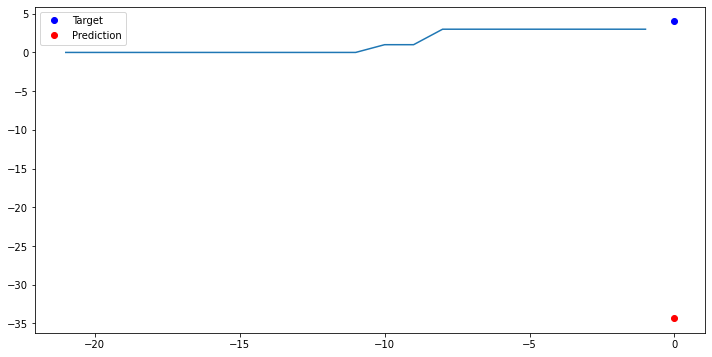

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.74233129e-01 2.94117647e-01
   2.07513417e-01 3.19488818e-01 4.33070866e-01 3.26530612e-01
   1.10155499e-01 4.60894127e-04 4.60825637e-02]
  [0.00000000e+00 0.00000000e+00 3.31288344e-01 2.98039216e-01
   1.75313059e-01 3.06709265e-01 6.69291339e-01 2.24489796e-01
   9.84487374e-02 4.60894127e-04 4.60825637e-02]
  [0.00000000e+00 0.00000000e+00 3.40490798e-01 3.01960784e-01
   1.84257603e-01 3.38658147e-01 6.69291339e-01 2.24489796e-01
   1.03607175e-01 4.60894127e-04 4.60825637e-02]
  [0.00000000e+00 0.00000000e+00 3.40490798e-01 3.05882353e-01
   1.82468694e-01 3.16293930e-01 6.69291339e-01 2.24489796e-01
   1.12310290e-01 4.60894127e-04 4.60825637e-02]
  [0.00000000e+00 0.00000000e+00 3.31288344e-01 2.94117647e-01
   1.62790698e-01 3.22683706e-01 6.61417323e-01 2.24489796e-01
   1.24455472e-01 4.60894127e-04 4.60825637e-02]
  [0.00000000e+00 0.00000000e+00 3.12883436e-01 2.74509804e-01
   9.12343470e-02 2.74760383e-01 6.22047244e-01 2.8

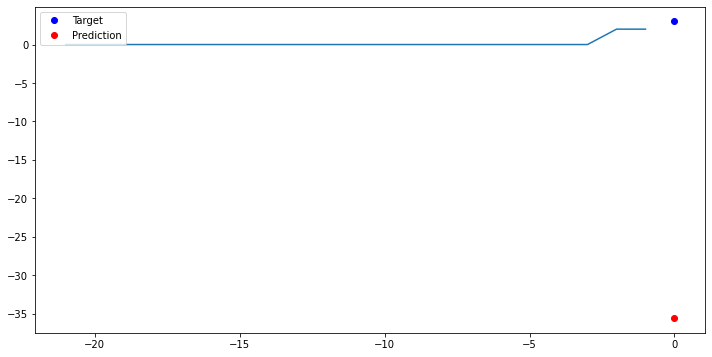

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.68098160e-01 3.64705882e-01
   1.62790698e-01 2.90734824e-01 6.37795276e-01 1.86382518e-01
   1.04847812e-01 5.30089489e-04 3.47935210e-03]
  [0.00000000e+00 0.00000000e+00 3.95705521e-01 3.56862745e-01
   1.62790698e-01 2.90734824e-01 6.45669291e-01 1.92877151e-01
   7.59586952e-02 5.30089489e-04 3.47935210e-03]
  [0.00000000e+00 0.00000000e+00 3.46625767e-01 3.37254902e-01
   1.62790698e-01 2.90734824e-01 7.00787402e-01 2.04081633e-01
   8.56412600e-02 5.30089489e-04 3.47935210e-03]
  [0.00000000e+00 0.00000000e+00 3.71165644e-01 3.72549020e-01
   1.62790698e-01 2.90734824e-01 7.00787402e-01 1.83673469e-01
   9.26186767e-02 5.30089489e-04 3.47935210e-03]
  [0.00000000e+00 0.00000000e+00 3.49693252e-01 3.45098039e-01
   1.62790698e-01 2.90734824e-01 6.92913386e-01 2.04081633e-01
   8.39622026e-02 5.30089489e-04 3.47935210e-03]
  [0.00000000e+00 0.00000000e+00 3.74233129e-01 3.68627451e-01
   1.62790698e-01 2.90734824e-01 6.85039370e-01 2.2

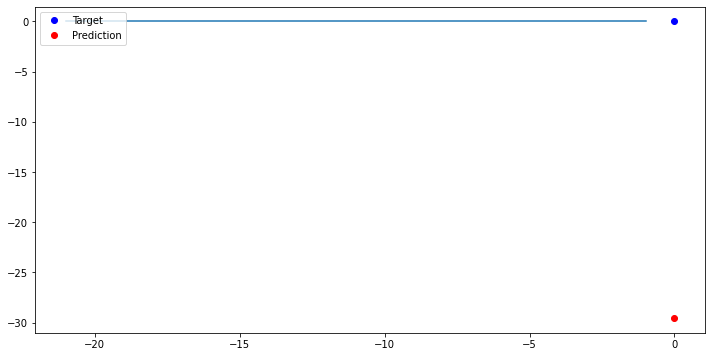

tf.Tensor(
[[[5.24480109e-05 0.00000000e+00 2.26667794e-01 2.93175431e-01
   1.62790698e-01 2.90734824e-01 4.09448819e-01 5.63234029e-01
   7.96619498e-02 1.55081314e-04 2.49110015e-03]
  [6.55600136e-05 0.00000000e+00 2.14812099e-01 2.88052118e-01
   1.62790698e-01 2.90734824e-01 4.09448819e-01 5.77122039e-01
   8.09772115e-02 1.55081314e-04 2.49110015e-03]
  [7.86720164e-05 0.00000000e+00 1.99836987e-01 2.68925420e-01
   1.62790698e-01 2.90734824e-01 4.01574803e-01 6.07200929e-01
   8.42700298e-02 1.55081314e-04 2.49110015e-03]
  [1.04896022e-04 0.00000000e+00 1.96438892e-01 2.78304970e-01
   1.62790698e-01 2.90734824e-01 5.59055118e-01 4.65559503e-01
   7.72086602e-02 1.55081314e-04 2.49110015e-03]
  [1.04896022e-04 0.00000000e+00 1.96423338e-01 2.55535577e-01
   1.62790698e-01 2.90734824e-01 4.40944882e-01 4.28820689e-01
   7.15838176e-02 1.55081314e-04 2.49110015e-03]
  [1.04896022e-04 0.00000000e+00 2.17592319e-01 2.73870138e-01
   1.62790698e-01 2.90734824e-01 4.09448819e-01 5.3

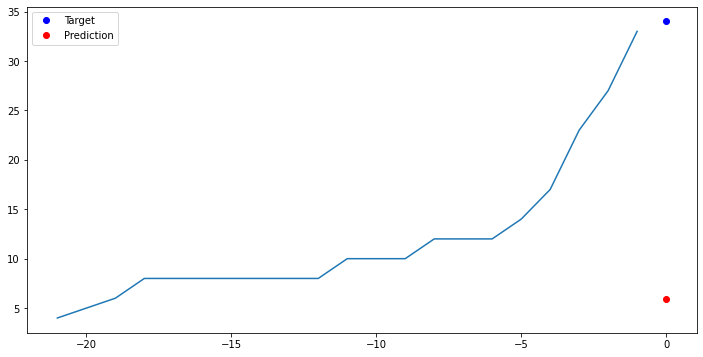

tf.Tensor(
[[[3.93360082e-05 0.00000000e+00 1.01226994e-01 2.27450980e-01
   1.62790698e-01 1.94007360e-01 4.48818898e-01 4.79468566e-01
   5.08008171e-02 2.22793261e-04 2.86115922e-03]
  [3.93360082e-05 0.00000000e+00 8.28220859e-02 1.88235294e-01
   1.62790698e-01 1.89753423e-01 4.17322835e-01 4.41027553e-01
   2.91876160e-02 2.22793261e-04 2.86115922e-03]
  [5.24480109e-05 0.00000000e+00 1.71779141e-01 2.27450980e-01
   1.62790698e-01 2.02435954e-01 2.91338583e-01 5.44375157e-01
   3.50549891e-02 2.22793261e-04 2.86115922e-03]
  [5.24480109e-05 0.00000000e+00 1.41104294e-01 2.66666667e-01
   1.62790698e-01 2.09918070e-01 2.83464567e-01 5.73936221e-01
   3.84037760e-02 2.22793261e-04 2.86115922e-03]
  [5.24480109e-05 0.00000000e+00 1.47239264e-01 2.78431373e-01
   1.62790698e-01 2.13877888e-01 2.67716535e-01 5.60974849e-01
   3.70325457e-02 2.22793261e-04 2.86115922e-03]
  [5.24480109e-05 0.00000000e+00 1.47239264e-01 2.94117647e-01
   1.62790698e-01 2.04533781e-01 2.75590551e-01 5.8

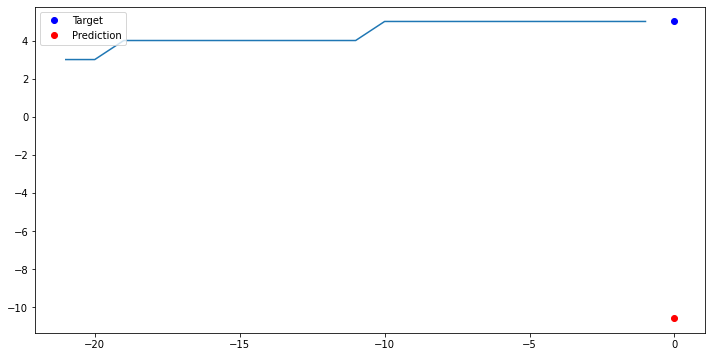

tf.Tensor(
[[[9.17840191e-05 0.00000000e+00 1.91802522e-01 2.73292644e-01
   1.62790698e-01 2.14057508e-01 4.01574803e-01 5.73561718e-01
   6.02501796e-02 1.28834122e-04 2.68404885e-03]
  [9.17840191e-05 0.00000000e+00 1.93008083e-01 2.76479381e-01
   1.62790698e-01 2.10862620e-01 3.93700787e-01 5.72170974e-01
   6.68451443e-02 1.28834122e-04 2.68404885e-03]
  [9.17840191e-05 0.00000000e+00 1.91491928e-01 2.82894805e-01
   1.62790698e-01 1.72523962e-01 4.01574803e-01 5.96018076e-01
   6.93077619e-02 1.28834122e-04 2.68404885e-03]
  [9.17840191e-05 0.00000000e+00 1.88589890e-01 2.84572099e-01
   1.62790698e-01 1.62939297e-01 3.62204724e-01 6.49630080e-01
   7.46061211e-02 1.28834122e-04 2.68404885e-03]
  [1.04896022e-04 0.00000000e+00 1.82071245e-01 3.03515831e-01
   1.62790698e-01 1.24600639e-01 5.19685039e-01 4.79280045e-01
   6.54086173e-02 1.28834122e-04 2.68404885e-03]
  [1.18008025e-04 0.00000000e+00 1.16641526e-01 1.60353300e-01
   1.62790698e-01 1.15015974e-01 3.46456693e-01 4.6

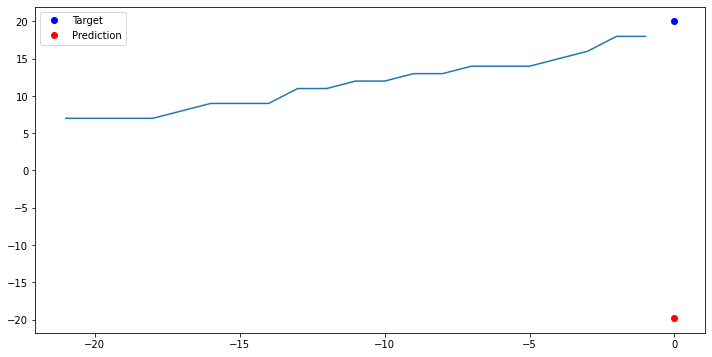

tf.Tensor(
[[[1.40298429e-03 1.49499178e-04 1.71779141e-01 2.43137255e-01
   2.45080501e-01 9.58466454e-02 1.96850394e-01 7.55102041e-01
   3.64075632e-02 1.11403469e-02 1.04644435e-01]
  [1.66522435e-03 1.49499178e-04 1.56441718e-01 2.03921569e-01
   8.22898032e-02 7.34824281e-02 1.73228346e-01 8.16326531e-01
   3.19673890e-02 1.11403469e-02 1.04644435e-01]
  [2.15036845e-03 1.49499178e-04 1.77914110e-01 2.50980392e-01
   2.84436494e-01 1.02236422e-01 1.88976378e-01 7.75510204e-01
   3.96257567e-02 1.11403469e-02 1.04644435e-01]
  [2.72729657e-03 1.49499178e-04 1.71779141e-01 2.43137255e-01
   2.39713775e-01 1.05431310e-01 2.04724409e-01 7.75510204e-01
   4.54744737e-02 1.11403469e-02 1.04644435e-01]
  [3.34356070e-03 1.49499178e-04 1.41104294e-01 2.03921569e-01
   1.18067979e-01 1.05431310e-01 3.22834646e-01 6.12244898e-01
   3.30307920e-02 1.11403469e-02 1.04644435e-01]
  [3.94671282e-03 1.49499178e-04 1.50306748e-01 2.00000000e-01
   2.41502683e-01 1.30990415e-01 3.07086614e-01 5.5

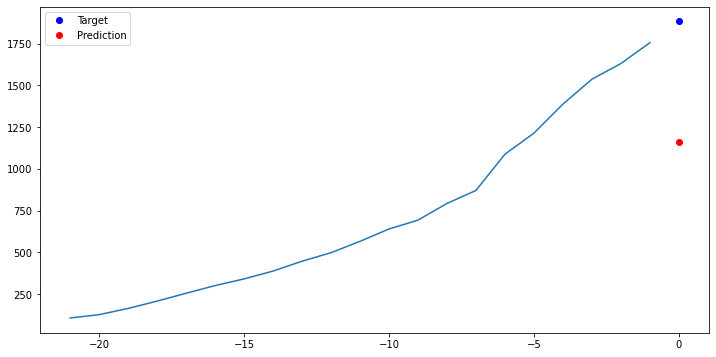

tf.Tensor(
[[[1.74389636e-03 5.97996711e-04 1.07361963e-01 1.05882353e-01
   8.40787120e-02 1.24600639e-01 2.67716535e-01 4.89795918e-01
   2.31896495e-02 2.07363439e-03 5.99438905e-02]
  [1.94057640e-03 5.97996711e-04 1.77914110e-01 2.31372549e-01
   1.03756708e-01 1.75718850e-01 2.91338583e-01 5.71428571e-01
   4.56890199e-02 2.07363439e-03 5.99438905e-02]
  [2.13725644e-03 8.96995067e-04 1.84049080e-01 2.35294118e-01
   1.19856887e-01 2.01277955e-01 2.91338583e-01 5.71428571e-01
   4.74706865e-02 2.07363439e-03 5.99438905e-02]
  [2.26837647e-03 8.96995067e-04 1.99386503e-01 2.50980392e-01
   1.05545617e-01 1.94888179e-01 2.91338583e-01 5.71428571e-01
   4.93456340e-02 2.07363439e-03 5.99438905e-02]
  [2.51750452e-03 8.96995067e-04 1.77914110e-01 2.19607843e-01
   6.61896243e-02 1.78913738e-01 2.83464567e-01 6.12244898e-01
   4.58942380e-02 2.07363439e-03 5.99438905e-02]
  [2.68796056e-03 1.04649424e-03 1.80981595e-01 2.31372549e-01
   1.00178891e-01 1.72523962e-01 2.99212598e-01 6.1

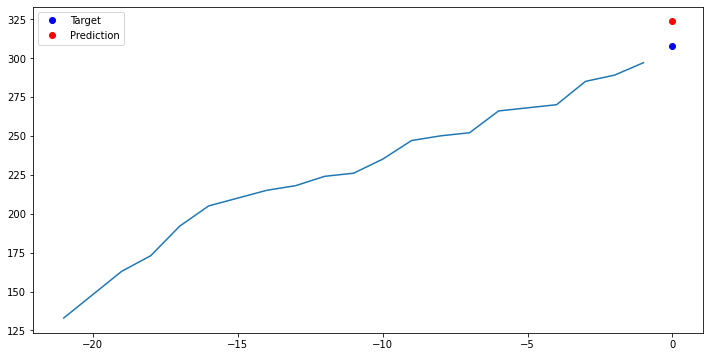

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 1.22699387e-01 2.39215686e-01
   1.19856887e-01 2.90734824e-01 4.17322835e-01 6.12244898e-01
   7.12573342e-02 1.03140025e-04 6.62719503e-03]
  [0.00000000e+00 0.00000000e+00 1.62576687e-01 2.94117647e-01
   1.62790698e-01 2.90734824e-01 5.27559055e-01 4.22544683e-01
   6.94010429e-02 1.03140025e-04 6.62719503e-03]
  [0.00000000e+00 0.00000000e+00 1.71779141e-01 2.47058824e-01
   1.73524150e-01 2.90734824e-01 4.72440945e-01 4.08907003e-01
   4.90751192e-02 1.03140025e-04 6.62719503e-03]
  [0.00000000e+00 0.00000000e+00 2.02453988e-01 3.84313725e-01
   1.44901610e-01 2.90734824e-01 4.01574803e-01 4.69387755e-01
   5.40843073e-02 1.03140025e-04 6.62719503e-03]
  [0.00000000e+00 0.00000000e+00 1.16564417e-01 2.19607843e-01
   1.77101968e-01 2.90734824e-01 3.07086614e-01 5.91836735e-01
   4.09690027e-02 1.03140025e-04 6.62719503e-03]
  [0.00000000e+00 0.00000000e+00 1.19631902e-01 1.92156863e-01
   1.25223614e-01 2.90734824e-01 2.83464567e-01 6.1

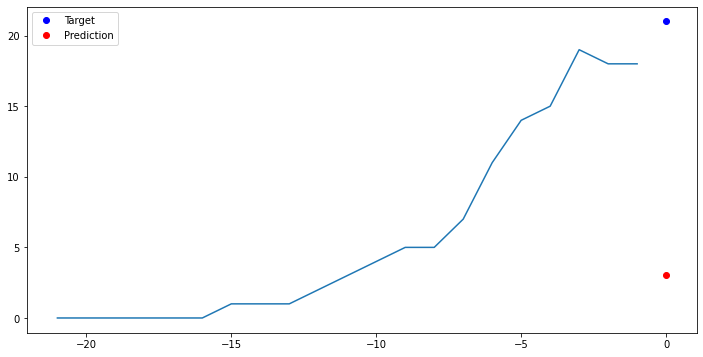

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.06748466e-01 2.86274510e-01
   1.62790698e-01 3.00319489e-01 6.45669291e-01 2.44897959e-01
   8.97083104e-02 1.66484980e-04 2.97411937e-03]
  [0.00000000e+00 0.00000000e+00 3.12883436e-01 3.13725490e-01
   1.62790698e-01 2.74760383e-01 6.92913386e-01 2.44897959e-01
   1.12506180e-01 1.66484980e-04 2.97411937e-03]
  [0.00000000e+00 0.00000000e+00 3.31288344e-01 3.09803922e-01
   1.62790698e-01 2.90734824e-01 7.55905512e-01 2.02996813e-01
   9.36727517e-02 1.66484980e-04 2.97411937e-03]
  [0.00000000e+00 0.00000000e+00 2.94478528e-01 3.25490196e-01
   1.62790698e-01 2.97124601e-01 6.37795276e-01 2.08692366e-01
   7.86824996e-02 1.66484980e-04 2.97411937e-03]
  [0.00000000e+00 0.00000000e+00 3.22085890e-01 3.41176471e-01
   1.62790698e-01 2.84345048e-01 6.85039370e-01 2.04081633e-01
   9.14993051e-02 1.66484980e-04 2.97411937e-03]
  [0.00000000e+00 0.00000000e+00 3.37423313e-01 3.05882353e-01
   1.62790698e-01 2.77955272e-01 6.61417323e-01 2.2

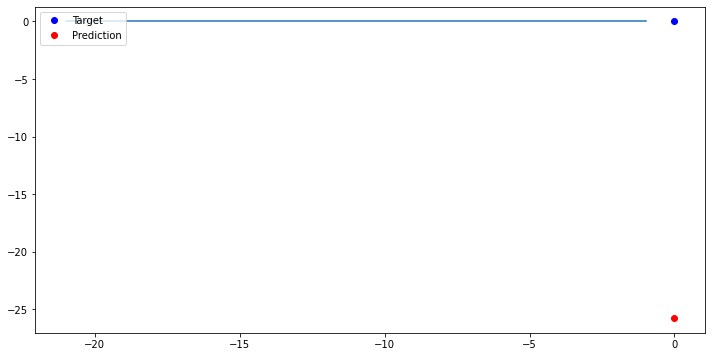

tf.Tensor(
[[[2.47816852e-03 2.98998356e-04 1.10429448e-01 3.05882353e-01
   1.68383582e-01 1.66134185e-01 3.30708661e-01 4.47023941e-01
   3.33013069e-02 1.52345053e-03 1.23720258e-02]
  [2.76663258e-03 2.98998356e-04 1.31901840e-01 3.17647059e-01
   1.74282076e-01 2.30031949e-01 1.73228346e-01 7.55102041e-01
   4.27973098e-02 1.52345053e-03 1.23720258e-02]
  [3.06820864e-03 2.98998356e-04 1.25766871e-01 3.17647059e-01
   1.83355114e-01 2.36421725e-01 1.57480315e-01 7.75510204e-01
   4.23868735e-02 1.52345053e-03 1.23720258e-02]
  [3.34356070e-03 2.98998356e-04 1.25766871e-01 3.33333333e-01
   1.79297207e-01 2.10862620e-01 1.57480315e-01 7.95918367e-01
   4.02880516e-02 1.52345053e-03 1.23720258e-02]
  [3.75003278e-03 5.97996711e-04 1.16564417e-01 3.29411765e-01
   1.51239250e-01 2.20447284e-01 1.49606299e-01 8.57142857e-01
   3.97656782e-02 1.52345053e-03 1.23720258e-02]
  [3.84181680e-03 1.04649424e-03 1.16564417e-01 3.33333333e-01
   1.54957620e-01 1.78913738e-01 1.25984252e-01 8.7

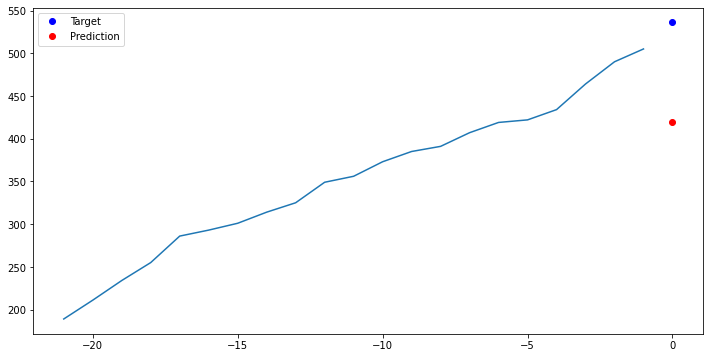

tf.Tensor(
[[[1.31120027e-05 0.00000000e+00 3.22085890e-01 3.52941176e-01
   2.28980322e-01 2.93929712e-01 5.59055118e-01 2.44897959e-01
   9.84673936e-02 5.59747053e-03 9.53871814e-02]
  [1.31120027e-05 0.00000000e+00 3.09815951e-01 3.84313725e-01
   1.87835420e-01 2.84345048e-01 5.43307087e-01 2.85714286e-01
   1.05444810e-01 5.59747053e-03 9.53871814e-02]
  [5.24480109e-05 0.00000000e+00 2.85276074e-01 3.64705882e-01
   1.57423971e-01 3.03514377e-01 6.45669291e-01 2.44897959e-01
   9.27772544e-02 5.59747053e-03 9.53871814e-02]
  [5.24480109e-05 0.00000000e+00 2.91411043e-01 3.49019608e-01
   2.05724508e-01 2.81150160e-01 6.22047244e-01 2.44897959e-01
   6.48675877e-02 5.59747053e-03 9.53871814e-02]
  [6.55600136e-05 0.00000000e+00 2.94478528e-01 3.60784314e-01
   1.53846154e-01 2.52396166e-01 5.27559055e-01 3.46938776e-01
   7.47367145e-02 5.59747053e-03 9.53871814e-02]
  [1.31120027e-04 0.00000000e+00 2.79141104e-01 3.68627451e-01
   1.69946333e-01 2.52396166e-01 4.88188976e-01 3.8

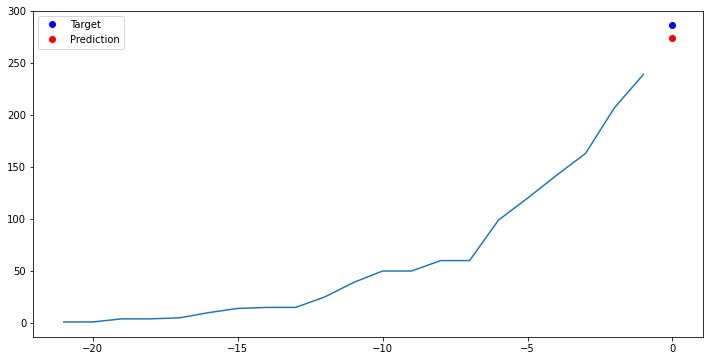

tf.Tensor(
[[[4.32696090e-04 0.00000000e+00 2.26993865e-01 3.33333333e-01
   1.62790698e-01 4.79233227e-01 3.77952756e-01 5.71428571e-01
   9.88591737e-02 5.45059989e-04 4.16368743e-03]
  [4.32696090e-04 0.00000000e+00 2.36196319e-01 4.07843137e-01
   1.62790698e-01 2.39300635e-01 5.11811024e-01 3.82418784e-01
   9.91390166e-02 5.45059989e-04 4.16368743e-03]
  [4.45808093e-04 0.00000000e+00 2.33128834e-01 3.68627451e-01
   1.62790698e-01 2.30401605e-01 4.96062992e-01 3.34682315e-01
   7.12946466e-02 5.45059989e-04 4.16368743e-03]
  [4.58920095e-04 0.00000000e+00 2.26993865e-01 3.09803922e-01
   1.62790698e-01 4.37699681e-01 4.33070866e-01 4.69387755e-01
   8.15058036e-02 5.45059989e-04 4.16368743e-03]
  [4.58920095e-04 0.00000000e+00 2.63803681e-01 3.45098039e-01
   1.62790698e-01 4.28115016e-01 4.25196850e-01 4.48979592e-01
   9.17169607e-02 5.45059989e-04 4.16368743e-03]
  [4.72032098e-04 0.00000000e+00 2.51533742e-01 3.33333333e-01
   1.62790698e-01 4.56869010e-01 4.09448819e-01 4.6

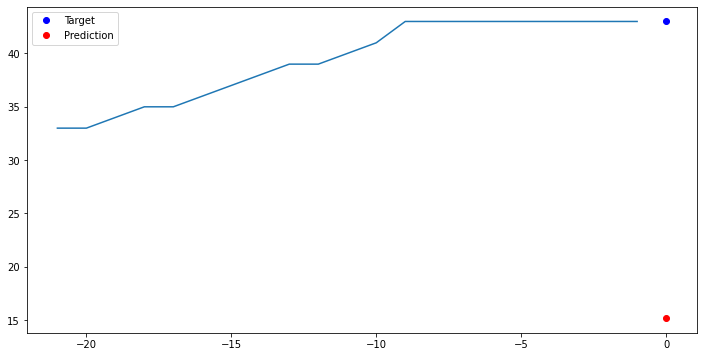

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.37423313e-01 3.45098039e-01
   1.62790698e-01 2.90734824e-01 7.32283465e-01 2.08692366e-01
   1.01620290e-01 3.04669307e-04 2.47964476e-03]
  [0.00000000e+00 0.00000000e+00 3.19018405e-01 3.25490196e-01
   1.62790698e-01 2.90734824e-01 6.69291339e-01 2.04081633e-01
   1.00360997e-01 3.04669307e-04 2.47964476e-03]
  [0.00000000e+00 0.00000000e+00 2.91411043e-01 3.21568627e-01
   1.62790698e-01 2.90734824e-01 6.61417323e-01 2.24489796e-01
   1.06769400e-01 3.04669307e-04 2.47964476e-03]
  [0.00000000e+00 0.00000000e+00 3.37423313e-01 3.72549020e-01
   1.62790698e-01 2.90734824e-01 6.69291339e-01 1.63265306e-01
   9.82062069e-02 3.04669307e-04 2.47964476e-03]
  [0.00000000e+00 0.00000000e+00 3.15950920e-01 3.41176471e-01
   1.62790698e-01 2.90734824e-01 6.61417323e-01 2.24489796e-01
   1.22860368e-01 3.04669307e-04 2.47964476e-03]
  [0.00000000e+00 0.00000000e+00 3.12883436e-01 3.25490196e-01
   1.62790698e-01 2.90734824e-01 6.37795276e-01 1.8

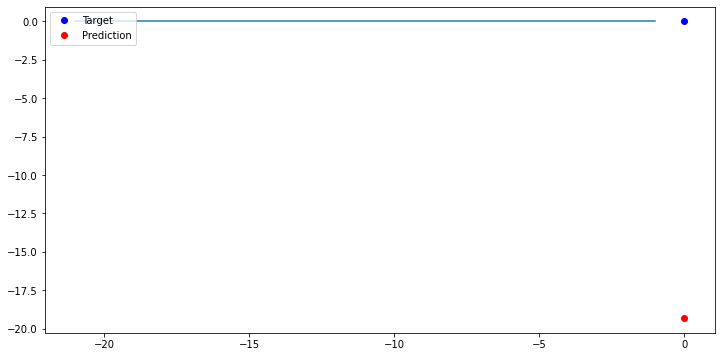

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.31288344e-01 3.37254902e-01
   1.73524150e-01 3.80191693e-01 6.77165354e-01 2.04081633e-01
   1.41413953e-01 3.43245451e-04 4.40763754e-03]
  [0.00000000e+00 0.00000000e+00 3.46625767e-01 3.33333333e-01
   1.66368515e-01 3.61022364e-01 6.85039370e-01 1.86382518e-01
   1.26974059e-01 3.43245451e-04 4.40763754e-03]
  [0.00000000e+00 0.00000000e+00 3.74233129e-01 3.52941176e-01
   2.10615135e-01 3.32268371e-01 6.61417323e-01 1.92877151e-01
   1.18401537e-01 3.43245451e-04 4.40763754e-03]
  [0.00000000e+00 0.00000000e+00 3.52760736e-01 3.64705882e-01
   1.81346242e-01 3.54632588e-01 6.92913386e-01 2.04081633e-01
   9.73013815e-02 3.43245451e-04 4.40763754e-03]
  [0.00000000e+00 0.00000000e+00 3.68098160e-01 3.68627451e-01
   1.94783226e-01 3.04415659e-01 7.08661417e-01 1.83673469e-01
   8.78986596e-02 3.43245451e-04 4.40763754e-03]
  [0.00000000e+00 0.00000000e+00 3.49693252e-01 3.76470588e-01
   1.92192691e-01 3.05133408e-01 6.85039370e-01 1.8

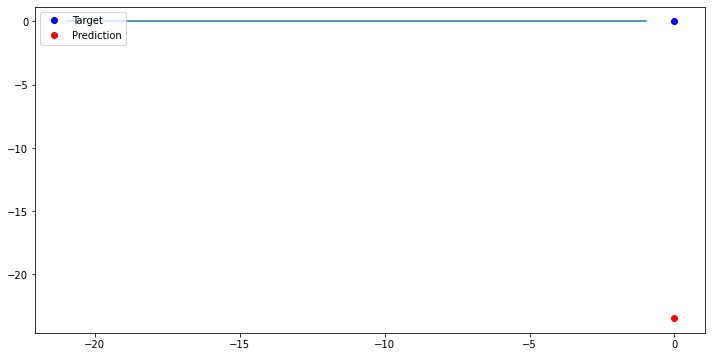

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 2.36196319e-01 3.41176471e-01
   1.62790698e-01 2.87539936e-01 4.72440945e-01 4.28571429e-01
   6.45690886e-02 8.63411683e-04 5.60627030e-03]
  [0.00000000e+00 0.00000000e+00 2.20858896e-01 3.21568627e-01
   1.62790698e-01 2.68370607e-01 4.25196850e-01 4.89795918e-01
   6.59496469e-02 8.63411683e-04 5.60627030e-03]
  [1.31120027e-05 0.00000000e+00 2.05521472e-01 3.49019608e-01
   1.62790698e-01 2.39616613e-01 4.88188976e-01 4.22544683e-01
   4.96627893e-02 8.63411683e-04 5.60627030e-03]
  [1.31120027e-05 0.00000000e+00 1.74846626e-01 2.50980392e-01
   1.62790698e-01 2.42811502e-01 4.01574803e-01 4.08907003e-01
   3.56799716e-02 8.63411683e-04 5.60627030e-03]
  [1.31120027e-05 0.00000000e+00 2.05521472e-01 2.82352941e-01
   1.62790698e-01 2.61980831e-01 3.46456693e-01 5.51020408e-01
   5.49424923e-02 8.63411683e-04 5.60627030e-03]
  [1.31120027e-05 0.00000000e+00 2.02453988e-01 2.50980392e-01
   1.62790698e-01 2.65175719e-01 3.07086614e-01 5.5

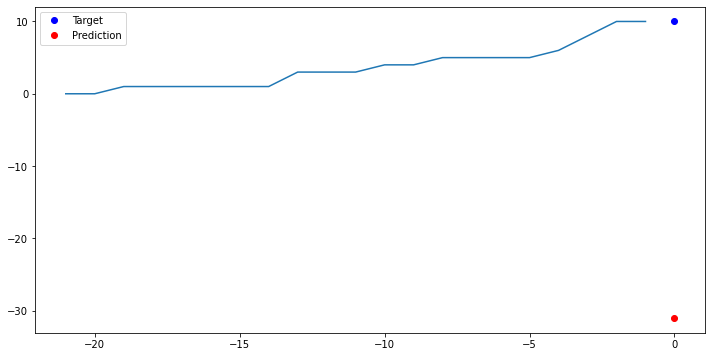

tf.Tensor(
[[[1.34398028e-02 4.33547615e-03 2.26993865e-01 2.58823529e-01
   1.62790698e-01 2.84345048e-01 3.93700787e-01 5.30612245e-01
   9.65271494e-02 5.95030803e-04 6.09466858e-03]
  [1.45674350e-02 4.33547615e-03 2.20858896e-01 2.66666667e-01
   1.62790698e-01 2.97124601e-01 3.85826772e-01 5.30612245e-01
   1.23457366e-01 5.95030803e-04 6.09466858e-03]
  [1.52099232e-02 4.33547615e-03 1.84049080e-01 2.11764706e-01
   1.62790698e-01 2.37953700e-01 5.82677165e-01 4.28571429e-01
   9.29265039e-02 5.95030803e-04 6.09466858e-03]
  [1.64686754e-02 4.33547615e-03 2.14723926e-01 2.19607843e-01
   1.62790698e-01 2.68370607e-01 4.56692913e-01 3.67048137e-01
   7.75631279e-02 5.95030803e-04 6.09466858e-03]
  [1.67964755e-02 4.33547615e-03 2.30061350e-01 2.78431373e-01
   1.62790698e-01 2.42811502e-01 4.17322835e-01 5.30612245e-01
   9.01280748e-02 5.95030803e-04 6.09466858e-03]
  [1.68358115e-02 4.63447451e-03 2.45398773e-01 3.05882353e-01
   1.62790698e-01 3.25878594e-01 4.17322835e-01 5.1

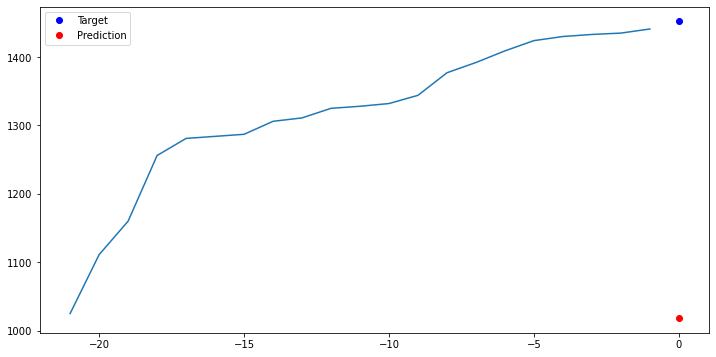

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.22085890e-01 4.03921569e-01
   1.62790698e-01 3.22683706e-01 6.69291339e-01 2.24489796e-01
   1.69883306e-01 2.43152391e-04 1.87928245e-03]
  [0.00000000e+00 0.00000000e+00 3.74233129e-01 4.15686275e-01
   1.62790698e-01 3.51437700e-01 6.58856296e-01 2.24489796e-01
   1.80834492e-01 2.43152391e-04 1.87928245e-03]
  [0.00000000e+00 0.00000000e+00 3.06277993e-01 3.84313725e-01
   1.62790698e-01 3.61022364e-01 6.06299213e-01 2.24489796e-01
   1.34044756e-01 2.43152391e-04 1.87928245e-03]
  [0.00000000e+00 0.00000000e+00 2.66871166e-01 4.82352941e-01
   1.62790698e-01 3.38658147e-01 5.90551181e-01 2.24489796e-01
   1.12142384e-01 2.43152391e-04 1.87928245e-03]
  [0.00000000e+00 0.00000000e+00 2.63803681e-01 4.23529412e-01
   1.62790698e-01 3.41853035e-01 5.66929134e-01 2.24489796e-01
   1.11694635e-01 2.43152391e-04 1.87928245e-03]
  [0.00000000e+00 0.00000000e+00 2.82208589e-01 3.88235294e-01
   1.62790698e-01 3.32268371e-01 5.51181102e-01 2.2

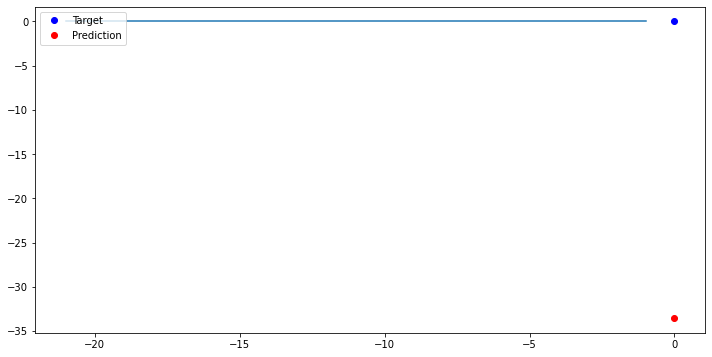

tf.Tensor(
[[[6.55600136e-05 0.00000000e+00 1.77914110e-01 2.73292644e-01
   1.83355114e-01 2.90734824e-01 3.38582677e-01 5.71428571e-01
   5.63230507e-02 1.53237975e-04 3.52885933e-03]
  [6.55600136e-05 0.00000000e+00 1.74846626e-01 2.76479381e-01
   1.79297207e-01 2.90734824e-01 3.38582677e-01 5.51020408e-01
   6.32818111e-02 1.53237975e-04 3.52885933e-03]
  [6.55600136e-05 0.00000000e+00 1.68711656e-01 2.82894805e-01
   1.51239250e-01 2.90734824e-01 3.38582677e-01 5.91836735e-01
   6.53713049e-02 1.53237975e-04 3.52885933e-03]
  [6.55600136e-05 0.00000000e+00 1.53374233e-01 2.84572099e-01
   1.00178891e-01 2.90734824e-01 3.22834646e-01 6.49630080e-01
   7.52311036e-02 1.53237975e-04 3.52885933e-03]
  [6.55600136e-05 0.00000000e+00 1.50306748e-01 3.03515831e-01
   1.23434705e-01 2.90734824e-01 4.48818898e-01 4.79280045e-01
   6.31605459e-02 1.53237975e-04 3.52885933e-03]
  [7.86720164e-05 0.00000000e+00 8.58895706e-02 1.60353300e-01
   6.79785331e-02 2.90734824e-01 3.46456693e-01 4.6

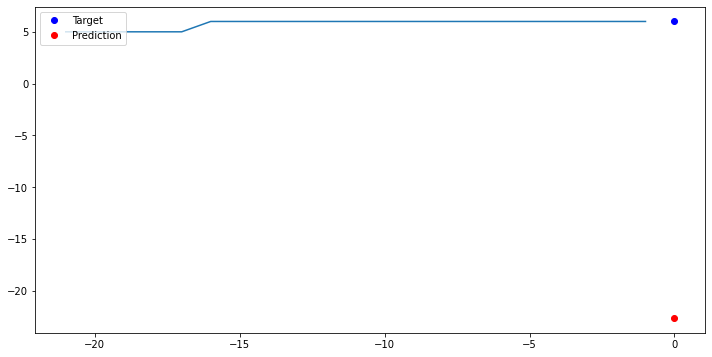

tf.Tensor(
[[[1.52099232e-03 2.98998356e-04 2.85276074e-01 3.37254902e-01
   1.92545861e-01 2.52396166e-01 3.22834646e-01 5.51020408e-01
   8.70404746e-02 3.44370757e-04 1.17454655e-02]
  [1.57344033e-03 2.98998356e-04 2.57668712e-01 3.45098039e-01
   1.91829576e-01 2.52396166e-01 3.22834646e-01 5.71428571e-01
   9.06038077e-02 3.44370757e-04 1.17454655e-02]
  [1.62588834e-03 2.98998356e-04 2.82208589e-01 3.60784314e-01
   1.96665779e-01 2.23642173e-01 3.22834646e-01 5.51020408e-01
   9.50812944e-02 3.44370757e-04 1.17454655e-02]
  [1.65211234e-03 2.98998356e-04 2.66871166e-01 3.60784314e-01
   2.21745306e-01 2.55591054e-01 3.22834646e-01 5.71428571e-01
   1.05995168e-01 3.44370757e-04 1.17454655e-02]
  [1.70456035e-03 2.98998356e-04 2.23926380e-01 3.29411765e-01
   1.80346463e-01 2.23642173e-01 3.14960630e-01 6.32653061e-01
   1.18392209e-01 3.44370757e-04 1.17454655e-02]
  [1.78323237e-03 2.98998356e-04 2.45398773e-01 4.11764706e-01
   2.00572934e-01 2.61980831e-01 4.48818898e-01 4.0

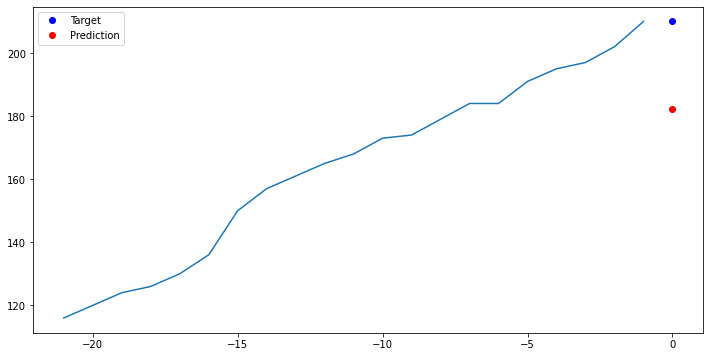

tf.Tensor(
[[[0.05425747 0.00553147 0.14110429 0.22745098 0.15921288 0.08306709
   0.33858268 0.59183673 0.03676203 0.00333838 0.14707054]
  [0.06586159 0.00597997 0.12883436 0.19607843 0.08765653 0.06709265
   0.33858268 0.55102041 0.02638919 0.00333838 0.14707054]
  [0.07593161 0.00657796 0.16871166 0.24313725 0.21824687 0.07028754
   0.22834646 0.73469388 0.03822654 0.00333838 0.14707054]
  [0.08802087 0.00792346 0.17177914 0.24313725 0.2236136  0.07028754
   0.22047244 0.75510204 0.03964441 0.00333838 0.14707054]
  [0.09971678 0.01031544 0.17484663 0.25490196 0.30948122 0.07348243
   0.21259843 0.75510204 0.04237755 0.00333838 0.14707054]
  [0.11467758 0.01255793 0.16564417 0.25098039 0.23076923 0.06709265
   0.20472441 0.7755102  0.04148205 0.00333838 0.14707054]
  [0.13313928 0.01435192 0.14723926 0.23529412 0.1019678  0.0543131
   0.19685039 0.85714286 0.04302118 0.00333838 0.14707054]
  [0.14908347 0.02616236 0.15030675 0.23921569 0.40071556 0.08626198
   0.30708661 0.59183673 

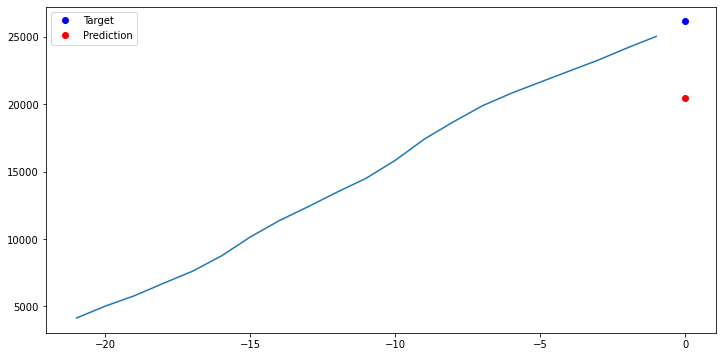

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 2.79141104e-01 2.66666667e-01
   5.90339893e-02 2.90734824e-01 6.37795276e-01 2.85714286e-01
   9.34861898e-02 3.08099807e-03 1.13808851e-02]
  [0.00000000e+00 0.00000000e+00 3.09815951e-01 3.29411765e-01
   1.94991055e-01 2.90734824e-01 6.45669291e-01 2.24489796e-01
   1.10621904e-01 3.08099807e-03 1.13808851e-02]
  [0.00000000e+00 0.00000000e+00 3.06748466e-01 3.33333333e-01
   2.98747764e-01 2.90734824e-01 6.85039370e-01 1.83673469e-01
   1.10230124e-01 3.08099807e-03 1.13808851e-02]
  [0.00000000e+00 0.00000000e+00 3.06748466e-01 3.52941176e-01
   2.14669052e-01 2.90734824e-01 6.69291339e-01 2.04081633e-01
   7.08189136e-02 3.08099807e-03 1.13808851e-02]
  [0.00000000e+00 0.00000000e+00 2.82208589e-01 2.74509804e-01
   8.58676208e-02 2.90734824e-01 6.61417323e-01 2.44897959e-01
   8.51002304e-02 3.08099807e-03 1.13808851e-02]
  [0.00000000e+00 0.00000000e+00 3.22085890e-01 3.13725490e-01
   1.94991055e-01 2.90734824e-01 6.77165354e-01 2.2

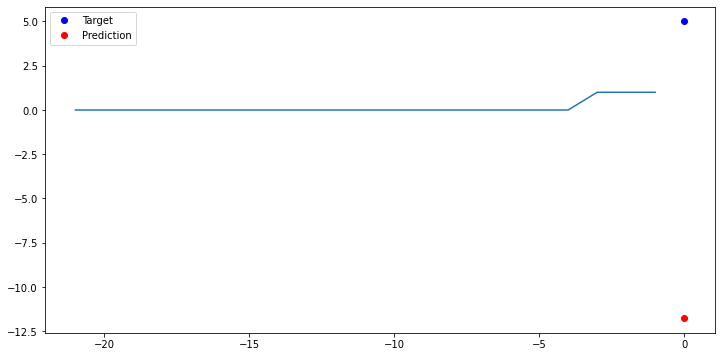

tf.Tensor(
[[[2.62240055e-05 0.00000000e+00 2.48466258e-01 3.60784314e-01
   1.62790698e-01 2.90734824e-01 4.64566929e-01 2.24489796e-01
   6.24236262e-02 9.98924154e-05 2.33620329e-03]
  [3.93360082e-05 0.00000000e+00 2.60736196e-01 3.37254902e-01
   1.62790698e-01 2.90734824e-01 4.48818898e-01 2.24489796e-01
   6.69664095e-02 9.98924154e-05 2.33620329e-03]
  [9.17840191e-05 0.00000000e+00 2.26993865e-01 3.37254902e-01
   1.62790698e-01 2.90734824e-01 5.90551181e-01 2.24489796e-01
   5.05116461e-02 9.98924154e-05 2.33620329e-03]
  [1.18008025e-04 0.00000000e+00 1.84049080e-01 2.03921569e-01
   1.62790698e-01 2.90734824e-01 4.48818898e-01 2.24489796e-01
   3.74616382e-02 9.98924154e-05 2.33620329e-03]
  [1.18008025e-04 0.00000000e+00 1.91338372e-01 2.66288515e-01
   1.62790698e-01 2.90734824e-01 4.56692913e-01 2.24489796e-01
   5.18455640e-02 9.98924154e-05 2.33620329e-03]
  [1.31120027e-04 0.00000000e+00 1.91802522e-01 2.73292644e-01
   1.62790698e-01 2.90734824e-01 4.48818898e-01 2.2

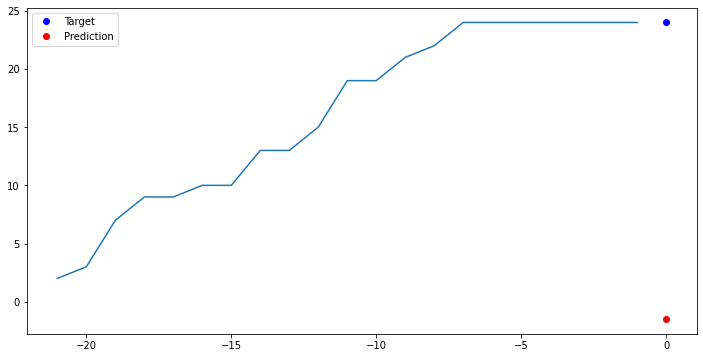

tf.Tensor(
[[[3.67136076e-04 2.98998356e-04 2.88343558e-01 3.37254902e-01
   1.80346463e-01 2.77955272e-01 4.17322835e-01 4.48979592e-01
   1.05407498e-01 4.05748238e-04 6.95442088e-03]
  [3.93360082e-04 2.98998356e-04 2.97546012e-01 3.72549020e-01
   2.09302326e-01 2.55591054e-01 5.59055118e-01 3.82418784e-01
   1.00510247e-01 4.05748238e-04 6.95442088e-03]
  [3.93360082e-04 2.98998356e-04 3.22085890e-01 3.96078431e-01
   2.09595424e-01 2.77955272e-01 5.19685039e-01 3.34682315e-01
   7.40650915e-02 4.05748238e-04 6.95442088e-03]
  [3.93360082e-04 2.98998356e-04 2.88343558e-01 3.09803922e-01
   1.76749409e-01 2.71565495e-01 4.17322835e-01 4.48979592e-01
   8.28303934e-02 4.05748238e-04 6.95442088e-03]
  [4.06472085e-04 2.98998356e-04 2.94478528e-01 3.09803922e-01
   1.99049518e-01 2.65175719e-01 4.17322835e-01 4.89795918e-01
   9.15956954e-02 4.05748238e-04 6.95442088e-03]
  [4.58920095e-04 2.98998356e-04 3.00613497e-01 3.33333333e-01
   2.16342819e-01 3.09904153e-01 4.17322835e-01 4.4

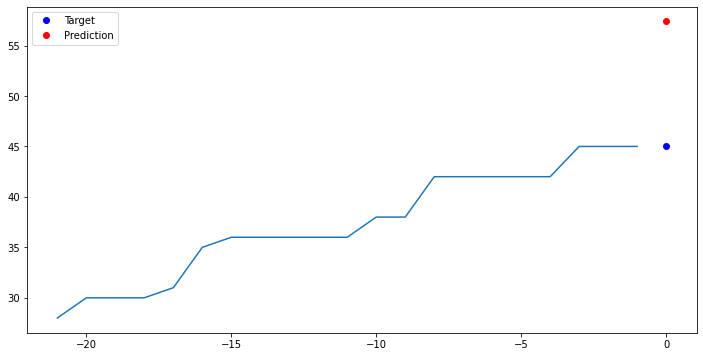

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 2.14723926e-01 2.74509804e-01
   1.62790698e-01 3.00319489e-01 6.69291339e-01 4.22544683e-01
   1.08364505e-01 1.78234408e-04 2.11765428e-03]
  [0.00000000e+00 0.00000000e+00 2.66871166e-01 3.37254902e-01
   1.62790698e-01 3.19488818e-01 5.90551181e-01 4.08907003e-01
   9.08556664e-02 1.78234408e-04 2.11765428e-03]
  [0.00000000e+00 0.00000000e+00 2.60736196e-01 2.90196078e-01
   1.62790698e-01 3.03514377e-01 5.27559055e-01 5.10631798e-01
   8.26003004e-02 1.78234408e-04 2.11765428e-03]
  [0.00000000e+00 0.00000000e+00 2.73006135e-01 3.17647059e-01
   1.62790698e-01 3.13099042e-01 5.11811024e-01 5.45837869e-01
   8.91672808e-02 1.78234408e-04 2.11765428e-03]
  [0.00000000e+00 0.00000000e+00 2.69938650e-01 3.09803922e-01
   1.62790698e-01 2.90734824e-01 4.88188976e-01 5.48927263e-01
   8.08093057e-02 1.78234408e-04 2.11765428e-03]
  [0.00000000e+00 0.00000000e+00 2.51533742e-01 3.05882353e-01
   1.62790698e-01 3.06709265e-01 5.11811024e-01 5.5

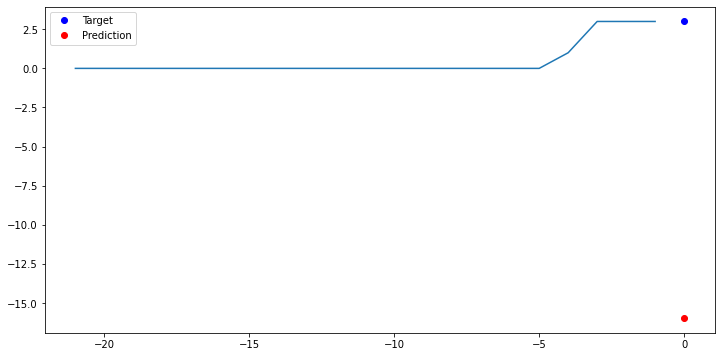

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 2.97546012e-01 3.25490196e-01
   1.50268336e-01 2.81150160e-01 6.69291339e-01 2.24489796e-01
   8.43446545e-02 2.59588148e-01 1.62222040e-01]
  [1.31120027e-05 0.00000000e+00 3.15950920e-01 3.41176471e-01
   1.93202147e-01 2.81150160e-01 6.92913386e-01 2.24489796e-01
   8.11171329e-02 2.59588148e-01 1.62222040e-01]
  [1.31120027e-05 0.00000000e+00 3.06748466e-01 3.41176471e-01
   1.71735242e-01 2.87539936e-01 6.85039370e-01 2.24489796e-01
   8.33931886e-02 2.59588148e-01 1.62222040e-01]
  [1.31120027e-05 0.00000000e+00 3.15950920e-01 3.52941176e-01
   1.86046512e-01 2.81150160e-01 6.77165354e-01 2.24489796e-01
   8.77307538e-02 2.59588148e-01 1.62222040e-01]
  [3.93360082e-05 0.00000000e+00 3.12883436e-01 3.56862745e-01
   1.87835420e-01 2.84345048e-01 6.77165354e-01 2.24489796e-01
   9.46895143e-02 2.59588148e-01 1.62222040e-01]
  [5.24480109e-05 0.00000000e+00 2.82208589e-01 3.05882353e-01
   1.30590340e-01 2.77955272e-01 6.53543307e-01 2.8

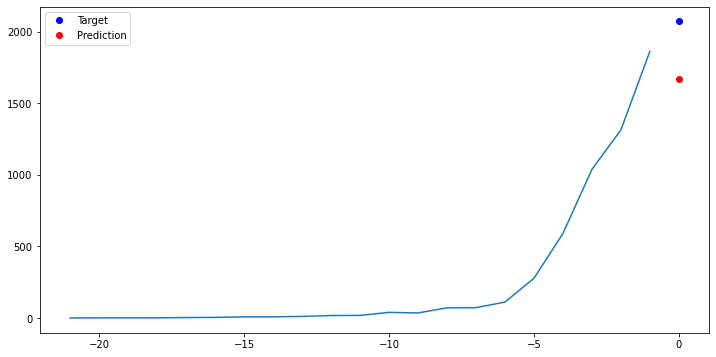

tf.Tensor(
[[[2.09792044e-04 0.00000000e+00 2.02453988e-01 3.01960784e-01
   6.97674419e-02 2.90734824e-01 4.64566929e-01 4.79280045e-01
   5.81979982e-02 1.88237058e-04 4.16906649e-03]
  [2.62240055e-04 0.00000000e+00 1.77914110e-01 2.11764706e-01
   5.00894454e-02 2.90734824e-01 3.77952756e-01 4.62063455e-01
   4.57636447e-02 1.88237058e-04 4.16906649e-03]
  [2.88464060e-04 0.00000000e+00 2.05521472e-01 2.62745098e-01
   6.79785331e-02 2.90734824e-01 4.17322835e-01 4.48979592e-01
   5.65655812e-02 1.88237058e-04 4.16906649e-03]
  [3.01576063e-04 0.00000000e+00 2.11656442e-01 2.54901961e-01
   6.79785331e-02 2.90734824e-01 4.17322835e-01 4.69387755e-01
   6.42519332e-02 1.88237058e-04 4.16906649e-03]
  [3.40912071e-04 0.00000000e+00 2.42331288e-01 2.90196078e-01
   6.79785331e-02 2.90734824e-01 4.17322835e-01 4.48979592e-01
   6.35616541e-02 1.88237058e-04 4.16906649e-03]
  [3.54024074e-04 0.00000000e+00 2.30061350e-01 2.98039216e-01
   4.47227191e-02 2.90734824e-01 4.09448819e-01 5.1

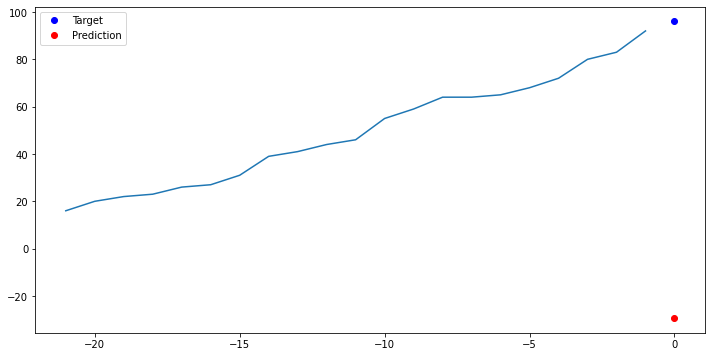

tf.Tensor(
[[[1.39511709e-02 2.98998356e-03 1.47239264e-01 3.05882353e-01
   1.62790698e-01 2.65175719e-01 3.22834646e-01 6.73469388e-01
   9.93442348e-02 6.88811864e-05 7.09218445e-03]
  [1.46329950e-02 2.98998356e-03 5.82822086e-02 9.01960784e-02
   1.62790698e-01 2.01277955e-01 3.62204724e-01 3.89254155e-01
   8.20406145e-02 6.88811864e-05 7.09218445e-03]
  [1.50001311e-02 3.13948273e-03 8.28220859e-02 1.25490196e-01
   1.62790698e-01 2.07667732e-01 4.17322835e-01 3.67048137e-01
   6.76473606e-02 6.88811864e-05 7.09218445e-03]
  [1.61670994e-02 3.13948273e-03 1.34969325e-01 3.37254902e-01
   1.62790698e-01 2.17252396e-01 3.22834646e-01 5.91836735e-01
   6.26101881e-02 6.88811864e-05 7.09218445e-03]
  [1.67046915e-02 3.73747944e-03 1.38036810e-01 2.98039216e-01
   1.62790698e-01 2.33226837e-01 2.91338583e-01 6.53061224e-01
   6.66585823e-02 6.88811864e-05 7.09218445e-03]
  [1.75307476e-02 4.33547615e-03 1.16564417e-01 3.13725490e-01
   1.62790698e-01 2.26837061e-01 2.83464567e-01 6.7

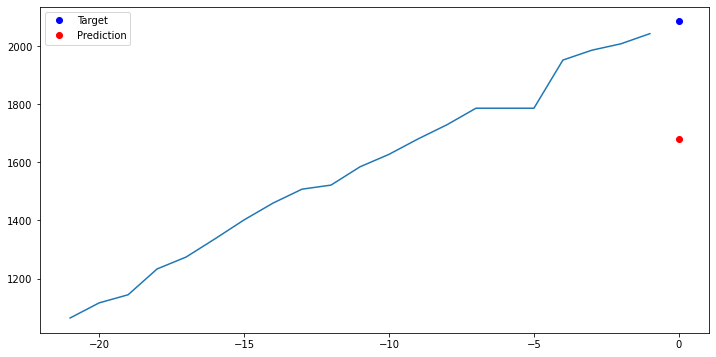

tf.Tensor(
[[[2.62240055e-05 0.00000000e+00 2.33128834e-01 3.01960784e-01
   1.62790698e-01 2.58785942e-01 5.59055118e-01 2.24489796e-01
   6.19478932e-02 1.89990680e-04 1.98756084e-03]
  [2.62240055e-05 0.00000000e+00 2.33128834e-01 2.78431373e-01
   1.62790698e-01 2.10862620e-01 5.35433071e-01 2.24489796e-01
   5.26571085e-02 1.89990680e-04 1.98756084e-03]
  [2.62240055e-05 0.00000000e+00 2.33128834e-01 2.78431373e-01
   1.62790698e-01 2.26837061e-01 3.93700787e-01 2.24489796e-01
   5.96345252e-02 1.89990680e-04 1.98756084e-03]
  [2.62240055e-05 0.00000000e+00 2.11656442e-01 2.90196078e-01
   1.62790698e-01 2.07667732e-01 4.01574803e-01 2.24489796e-01
   5.90561831e-02 1.89990680e-04 1.98756084e-03]
  [3.93360082e-05 0.00000000e+00 2.76073620e-01 4.11764706e-01
   1.62790698e-01 2.39616613e-01 3.93700787e-01 2.24489796e-01
   6.03061481e-02 1.89990680e-04 1.98756084e-03]
  [5.24480109e-05 0.00000000e+00 2.57668712e-01 3.37254902e-01
   1.62790698e-01 2.30031949e-01 3.85826772e-01 2.2

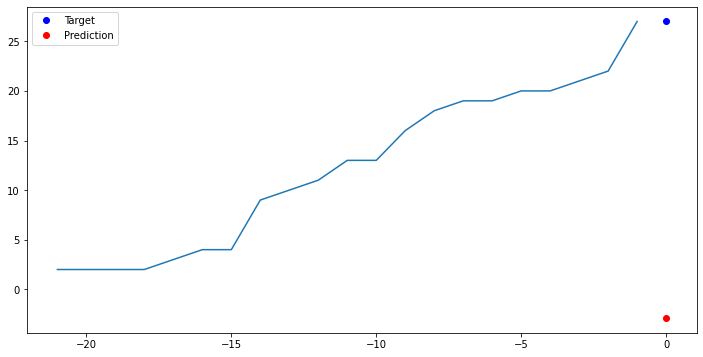

tf.Tensor(
[[[3.27800068e-04 0.00000000e+00 2.76073620e-01 3.52941176e-01
   1.37745975e-01 2.90734824e-01 4.17322835e-01 4.28571429e-01
   1.33326493e-01 2.52044831e-04 4.77998768e-03]
  [3.40912071e-04 0.00000000e+00 3.09815951e-01 3.88235294e-01
   1.41323792e-01 2.90734824e-01 4.88188976e-01 3.82418784e-01
   1.43307557e-01 2.52044831e-04 4.77998768e-03]
  [3.40912071e-04 0.00000000e+00 3.19018405e-01 3.80392157e-01
   2.03935599e-01 2.90734824e-01 4.80314961e-01 3.34682315e-01
   1.14101284e-01 2.52044831e-04 4.77998768e-03]
  [3.40912071e-04 0.00000000e+00 3.03680982e-01 3.05882353e-01
   1.76749409e-01 2.90734824e-01 4.48818898e-01 4.08163265e-01
   1.09987594e-01 2.52044831e-04 4.77998768e-03]
  [3.67136076e-04 0.00000000e+00 2.73006135e-01 3.21568627e-01
   1.99049518e-01 2.90734824e-01 4.17322835e-01 4.89795918e-01
   1.05873903e-01 2.52044831e-04 4.77998768e-03]
  [3.67136076e-04 0.00000000e+00 2.94478528e-01 3.33333333e-01
   2.16342819e-01 2.90734824e-01 4.48818898e-01 4.0

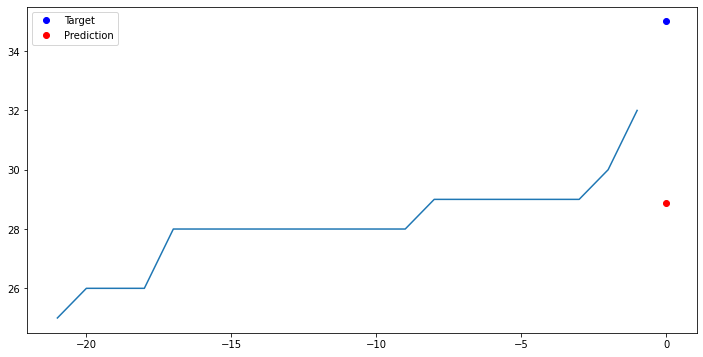

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.12883436e-01 3.09803922e-01
   2.12741155e-01 2.90734824e-01 6.61417323e-01 2.24489796e-01
   8.30946895e-02 9.07531970e-05 2.64689353e-03]
  [0.00000000e+00 0.00000000e+00 3.15950920e-01 3.09803922e-01
   1.74004280e-01 2.90734824e-01 6.61417323e-01 2.24489796e-01
   9.13500555e-02 9.07531970e-05 2.64689353e-03]
  [0.00000000e+00 0.00000000e+00 3.52760736e-01 3.37254902e-01
   1.75401744e-01 2.90734824e-01 6.69291339e-01 2.24489796e-01
   9.78424111e-02 9.07531970e-05 2.64689353e-03]
  [0.00000000e+00 0.00000000e+00 3.68098160e-01 3.01960784e-01
   1.70391103e-01 2.90734824e-01 6.85039370e-01 2.24489796e-01
   8.88874379e-02 9.07531970e-05 2.64689353e-03]
  [0.00000000e+00 0.00000000e+00 3.40490798e-01 3.13725490e-01
   1.78820294e-01 2.90734824e-01 6.69291339e-01 2.24489796e-01
   9.07810416e-02 9.07531970e-05 2.64689353e-03]
  [0.00000000e+00 0.00000000e+00 3.55828221e-01 3.17647059e-01
   1.81568513e-01 2.90734824e-01 6.61417323e-01 2.2

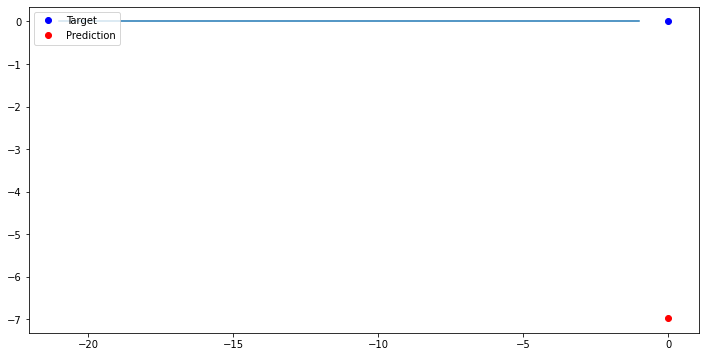

tf.Tensor(
[[[1.18008025e-03 8.96995067e-04 2.26667794e-01 2.93175431e-01
   1.62790698e-01 2.49201278e-01 3.46456693e-01 2.24489796e-01
   6.34124045e-02 2.59033769e-04 3.34457689e-03]
  [1.28497627e-03 8.96995067e-04 2.14812099e-01 2.88052118e-01
   1.62790698e-01 2.10862620e-01 3.62204724e-01 2.24489796e-01
   7.56415399e-02 2.59033769e-04 3.34457689e-03]
  [1.38987229e-03 8.96995067e-04 1.99836987e-01 2.68925420e-01
   1.62790698e-01 2.07667732e-01 3.54330709e-01 2.24489796e-01
   8.79732843e-02 2.59033769e-04 3.34457689e-03]
  [1.42920830e-03 8.96995067e-04 1.96438892e-01 2.78304970e-01
   1.62790698e-01 1.88498403e-01 4.56692913e-01 2.24489796e-01
   8.81411901e-02 2.59033769e-04 3.34457689e-03]
  [1.46854431e-03 8.96995067e-04 1.96423338e-01 2.55535577e-01
   1.62790698e-01 1.94888179e-01 3.46456693e-01 2.24489796e-01
   5.24705465e-02 2.59033769e-04 3.34457689e-03]
  [1.57344033e-03 1.04649424e-03 2.17592319e-01 2.73870138e-01
   1.62790698e-01 1.82108626e-01 3.77952756e-01 2.2

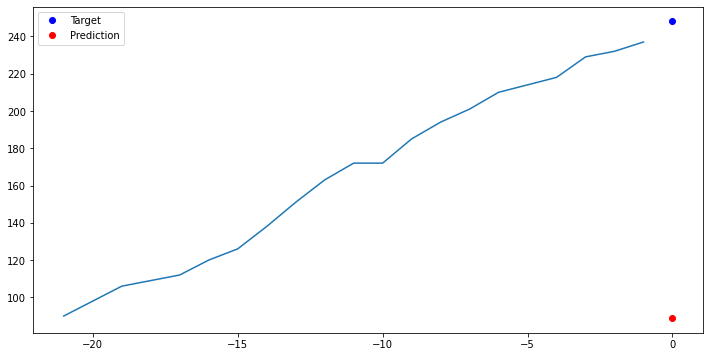

tf.Tensor(
[[[1.44232030e-04 2.98998356e-04 1.80981595e-01 2.66666667e-01
   1.62790698e-01 2.90734824e-01 2.51968504e-01 6.53061224e-01
   5.20694384e-02 3.05558971e-04 5.18740130e-03]
  [1.83568038e-04 2.98998356e-04 1.99386503e-01 2.78431373e-01
   1.62790698e-01 2.90734824e-01 2.51968504e-01 6.53061224e-01
   5.14257997e-02 3.05558971e-04 5.18740130e-03]
  [1.96680041e-04 2.98998356e-04 1.77914110e-01 2.74509804e-01
   1.62790698e-01 2.90734824e-01 2.51968504e-01 6.93877551e-01
   5.03810528e-02 3.05558971e-04 5.18740130e-03]
  [2.62240055e-04 2.98998356e-04 1.62576687e-01 2.54901961e-01
   1.62790698e-01 2.90734824e-01 3.46456693e-01 4.91255649e-01
   4.14074233e-02 3.05558971e-04 5.18740130e-03]
  [2.88464060e-04 2.98998356e-04 1.74846626e-01 2.62745098e-01
   1.62790698e-01 2.90734824e-01 3.70078740e-01 4.47023941e-01
   3.19300766e-02 3.05558971e-04 5.18740130e-03]
  [2.88464060e-04 2.98998356e-04 1.84049080e-01 2.66288515e-01
   1.62790698e-01 2.90734824e-01 2.51968504e-01 6.3

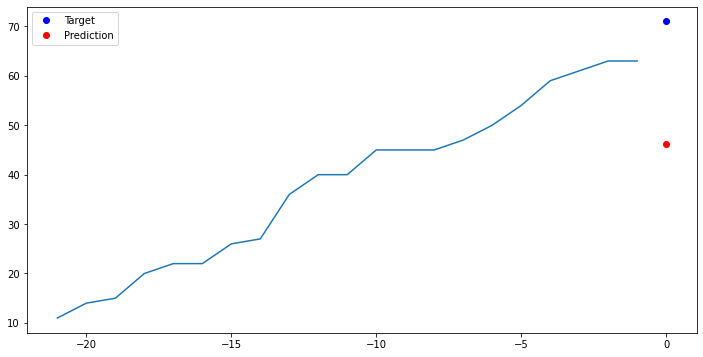

tf.Tensor(
[[[5.90040123e-04 1.49499178e-04 1.96438892e-01 2.78304970e-01
   1.62790698e-01 2.17252396e-01 5.11811024e-01 4.65559503e-01
   9.02773243e-02 3.11293666e-04 4.08051131e-03]
  [5.90040123e-04 1.49499178e-04 1.96423338e-01 2.55535577e-01
   1.62790698e-01 1.91693291e-01 3.54330709e-01 4.28820689e-01
   5.69200489e-02 3.11293666e-04 4.08051131e-03]
  [6.03152125e-04 1.49499178e-04 2.17592319e-01 2.73870138e-01
   1.62790698e-01 2.58785942e-01 3.77952756e-01 5.38350012e-01
   8.78706753e-02 3.11293666e-04 4.08051131e-03]
  [6.29376131e-04 1.49499178e-04 2.17411304e-01 2.82702388e-01
   1.62790698e-01 2.36421725e-01 3.77952756e-01 5.53670819e-01
   8.97362947e-02 3.11293666e-04 4.08051131e-03]
  [6.29376131e-04 1.49499178e-04 2.15648736e-01 2.83977221e-01
   1.62790698e-01 2.33226837e-01 3.70078740e-01 5.57138187e-01
   8.38409373e-02 3.11293666e-04 4.08051131e-03]
  [6.29376131e-04 1.49499178e-04 2.07551800e-01 2.79713118e-01
   1.62790698e-01 2.39616613e-01 3.62204724e-01 5.8

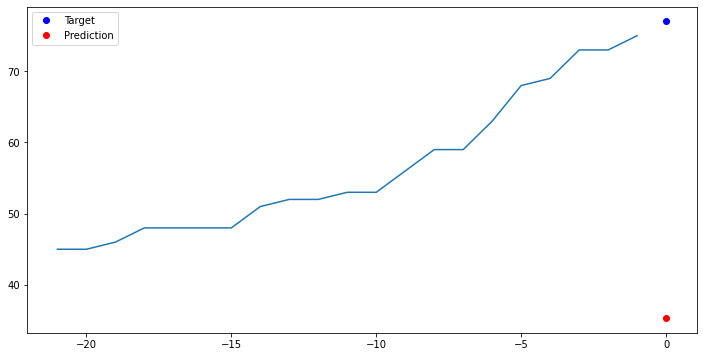

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 1.74846626e-01 2.82352941e-01
   1.68326434e-01 2.90734824e-01 3.46456693e-01 5.48927263e-01
   7.13879276e-02 1.72000892e-04 2.55754145e-03]
  [0.00000000e+00 0.00000000e+00 1.93251534e-01 2.62745098e-01
   1.85265513e-01 2.90734824e-01 3.22834646e-01 5.57673221e-01
   6.86734513e-02 1.72000892e-04 2.55754145e-03]
  [2.62240055e-05 0.00000000e+00 1.62576687e-01 2.86274510e-01
   1.75554739e-01 2.90734824e-01 3.62204724e-01 5.88136533e-01
   7.09495070e-02 1.72000892e-04 2.55754145e-03]
  [2.62240055e-05 0.00000000e+00 1.50306748e-01 2.54901961e-01
   1.42379059e-01 2.90734824e-01 3.38582677e-01 4.79468566e-01
   7.34774213e-02 1.72000892e-04 2.55754145e-03]
  [3.93360082e-05 0.00000000e+00 1.77914110e-01 2.62745098e-01
   1.55884835e-01 2.90734824e-01 2.99212598e-01 4.41027553e-01
   5.54835219e-02 1.72000892e-04 2.55754145e-03]
  [6.55600136e-05 0.00000000e+00 1.99386503e-01 2.70588235e-01
   1.53761206e-01 2.90734824e-01 3.46456693e-01 5.4

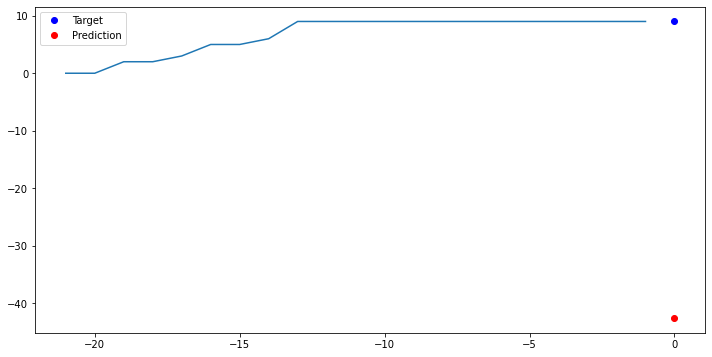

tf.Tensor(
[[[6.55600136e-05 0.00000000e+00 1.74846626e-01 3.09803922e-01
   1.62790698e-01 2.90734824e-01 4.09448819e-01 4.91255649e-01
   5.46253370e-02 3.53957175e-04 2.65217297e-03]
  [6.55600136e-05 0.00000000e+00 1.59509202e-01 3.01960784e-01
   1.62790698e-01 2.90734824e-01 4.25196850e-01 4.47023941e-01
   4.48401631e-02 3.53957175e-04 2.65217297e-03]
  [6.55600136e-05 0.00000000e+00 1.91338372e-01 2.66288515e-01
   1.62790698e-01 2.90734824e-01 3.14960630e-01 5.57972640e-01
   5.73677975e-02 3.53957175e-04 2.65217297e-03]
  [6.55600136e-05 0.00000000e+00 1.91802522e-01 2.73292644e-01
   1.62790698e-01 2.90734824e-01 3.07086614e-01 5.73561718e-01
   7.79175956e-02 3.53957175e-04 2.65217297e-03]
  [6.55600136e-05 0.00000000e+00 1.93008083e-01 2.76479381e-01
   1.62790698e-01 2.90734824e-01 2.99212598e-01 5.72170974e-01
   7.08655541e-02 3.53957175e-04 2.65217297e-03]
  [7.86720164e-05 0.00000000e+00 1.91491928e-01 2.82894805e-01
   1.62790698e-01 2.90734824e-01 3.07086614e-01 5.9

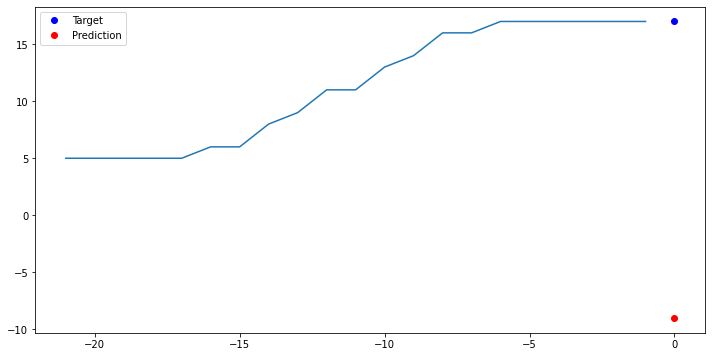

tf.Tensor(
[[[4.58920095e-04 0.00000000e+00 2.14723926e-01 3.05882353e-01
   1.51239250e-01 1.88498403e-01 3.46456693e-01 5.51020408e-01
   5.70692984e-02 4.08820520e-04 8.56724088e-03]
  [4.85144101e-04 0.00000000e+00 2.02453988e-01 3.17647059e-01
   1.54957620e-01 1.46964856e-01 2.51968504e-01 6.32653061e-01
   6.14721603e-02 4.08820520e-04 8.56724088e-03]
  [4.85144101e-04 0.00000000e+00 2.05521472e-01 3.17647059e-01
   1.65547234e-01 1.34185304e-01 4.40944882e-01 4.28571429e-01
   5.48025708e-02 4.08820520e-04 8.56724088e-03]
  [4.85144101e-04 0.00000000e+00 1.22699387e-01 2.07843137e-01
   1.00178891e-01 1.18210863e-01 3.77952756e-01 4.62063455e-01
   3.31707135e-02 4.08820520e-04 8.56724088e-03]
  [4.85144101e-04 0.00000000e+00 2.42331288e-01 2.74509804e-01
   1.28585928e-01 1.72523962e-01 3.30708661e-01 4.69387755e-01
   6.74514706e-02 4.08820520e-04 8.56724088e-03]
  [4.98256104e-04 0.00000000e+00 2.51533742e-01 3.21568627e-01
   1.60497871e-01 2.26837061e-01 3.62204724e-01 5.1

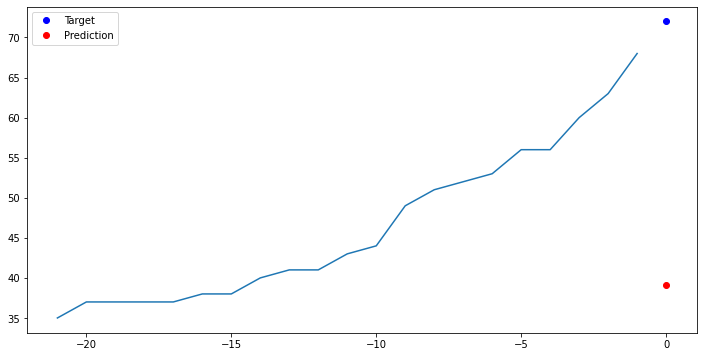

tf.Tensor(
[[[0.00123253 0.00224249 0.26380368 0.36078431 0.1627907  0.29073482
   0.33070866 0.59183673 0.1190545  0.00086385 0.00625853]
  [0.00132431 0.00239199 0.23619632 0.39215686 0.1627907  0.29073482
   0.46456693 0.38925416 0.10524892 0.00086385 0.00625853]
  [0.00132431 0.00239199 0.25460123 0.28627451 0.1627907  0.29073482
   0.46456693 0.36704814 0.07592138 0.00086385 0.00625853]
  [0.00135054 0.00239199 0.28527607 0.37647059 0.1627907  0.29073482
   0.36220472 0.53061224 0.10589256 0.00086385 0.00625853]
  [0.00138987 0.00269099 0.2791411  0.36078431 0.1627907  0.29073482
   0.37007874 0.57142857 0.09521189 0.00086385 0.00625853]
  [0.00144232 0.00269099 0.28834356 0.37647059 0.1627907  0.29073482
   0.36220472 0.55102041 0.10644292 0.00086385 0.00625853]
  [0.00152099 0.00284048 0.29447853 0.38431373 0.1627907  0.29073482
   0.36220472 0.53061224 0.1133084  0.00086385 0.00625853]
  [0.00156033 0.00284048 0.25153374 0.34117647 0.1627907  0.29073482
   0.34645669 0.6122449 

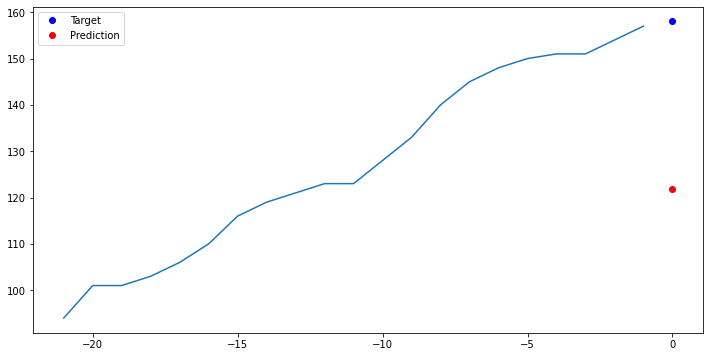

tf.Tensor(
[[[2.36016049e-04 0.00000000e+00 1.71779141e-01 2.74509804e-01
   1.52295602e-01 2.09918070e-01 3.07086614e-01 5.71428571e-01
   4.74706865e-02 3.67065321e-04 6.35276361e-03]
  [2.36016049e-04 0.00000000e+00 1.87116564e-01 2.82352941e-01
   1.71431178e-01 2.13877888e-01 2.99212598e-01 5.51020408e-01
   5.02224751e-02 3.67065321e-04 6.35276361e-03]
  [2.36016049e-04 0.00000000e+00 1.74846626e-01 2.86274510e-01
   1.73524150e-01 2.04533781e-01 2.99212598e-01 5.91836735e-01
   4.58849099e-02 3.67065321e-04 6.35276361e-03]
  [2.49128052e-04 0.00000000e+00 1.53374233e-01 2.90196078e-01
   1.18067979e-01 1.59744409e-01 2.91338583e-01 6.32653061e-01
   5.44667593e-02 3.67065321e-04 6.35276361e-03]
  [2.62240055e-04 1.49499178e-04 1.50306748e-01 2.74509804e-01
   1.47806747e-01 1.85358493e-01 3.54330709e-01 4.91255649e-01
   5.83006073e-02 3.67065321e-04 6.35276361e-03]
  [3.40912071e-04 1.49499178e-04 1.56441718e-01 2.70588235e-01
   2.21824687e-01 1.76812338e-01 3.77952756e-01 4.4

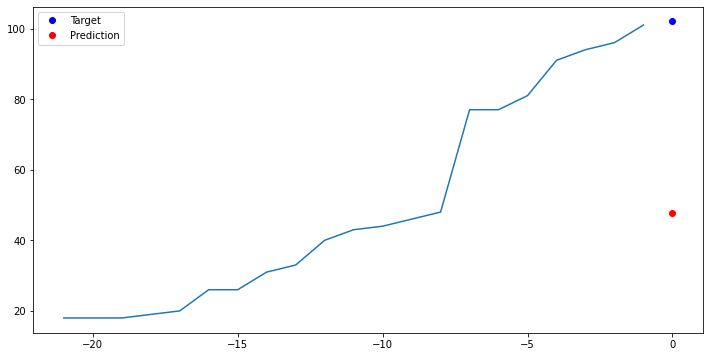

tf.Tensor(
[[[1.24564026e-03 1.49499178e-04 1.91802522e-01 2.73292644e-01
   1.83355114e-01 2.90734824e-01 2.28346457e-01 2.24489796e-01
   2.31803214e-02 2.74139044e-05 1.72259257e-03]
  [1.28497627e-03 1.49499178e-04 1.93008083e-01 2.76479381e-01
   1.79297207e-01 2.90734824e-01 2.12598425e-01 2.24489796e-01
   2.65664207e-02 2.74139044e-05 1.72259257e-03]
  [1.29808827e-03 1.49499178e-04 1.91491928e-01 2.82894805e-01
   1.51239250e-01 2.90734824e-01 2.20472441e-01 2.24489796e-01
   2.99058795e-02 2.74139044e-05 1.72259257e-03]
  [1.32431228e-03 1.49499178e-04 1.88589890e-01 2.84572099e-01
   6.97674419e-02 2.90734824e-01 2.36220472e-01 2.24489796e-01
   2.95887242e-02 2.74139044e-05 1.72259257e-03]
  [1.33742428e-03 4.48497533e-04 1.82071245e-01 3.03515831e-01
   8.58676208e-02 2.90734824e-01 2.75590551e-01 2.24489796e-01
   3.64168913e-02 2.74139044e-05 1.72259257e-03]
  [1.32431228e-03 4.48497533e-04 1.16641526e-01 1.60353300e-01
   3.75670841e-02 2.90734824e-01 1.57480315e-01 2.2

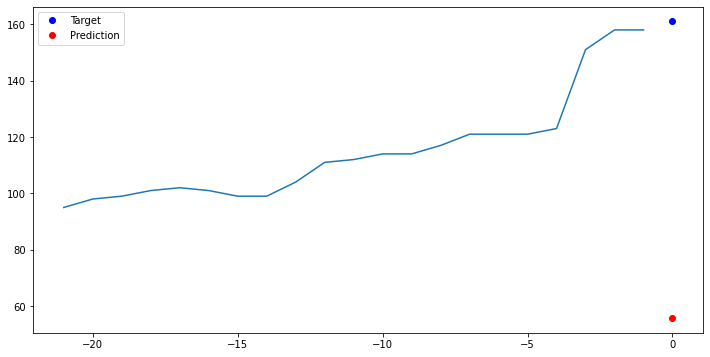

tf.Tensor(
[[[0.3052212  0.09762296 0.14723926 0.25490196 0.24686941 0.07348243
   0.22047244 0.75510204 0.04920571 0.00333838 0.14707054]
  [0.31707445 0.10360293 0.14110429 0.25882353 0.23255814 0.07348243
   0.21259843 0.7755102  0.05123924 0.00333838 0.14707054]
  [0.32825899 0.10360293 0.13190184 0.25098039 0.20035778 0.07028754
   0.22047244 0.79591837 0.05523166 0.00333838 0.14707054]
  [0.34278709 0.10360293 0.11656442 0.23137255 0.15563506 0.0798722
   0.33070866 0.6122449  0.04634199 0.00333838 0.14707054]
  [0.35255553 0.12333682 0.12883436 0.22352941 0.33452594 0.09265176
   0.37007874 0.51020408 0.0456144  0.00333838 0.14707054]
  [0.36270422 0.12841979 0.14110429 0.23921569 0.23076923 0.07348243
   0.23622047 0.73469388 0.04874864 0.00333838 0.14707054]
  [0.36915532 0.13275527 0.13190184 0.22745098 0.1627907  0.06709265
   0.22834646 0.7755102  0.04485882 0.00333838 0.14707054]
  [0.37833373 0.13843624 0.14723926 0.25882353 0.25044723 0.07348243
   0.23622047 0.73469388 

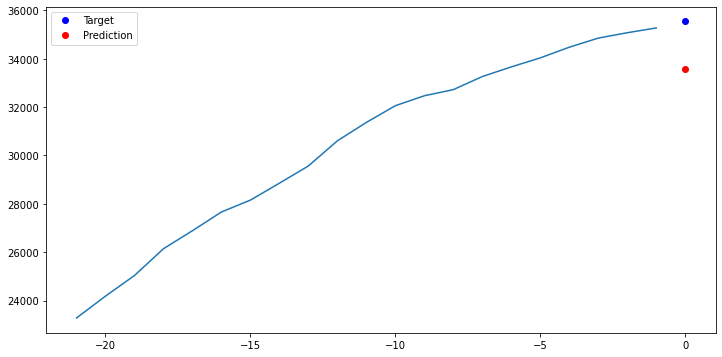

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.00613497e-01 3.21568627e-01
   1.61050641e-01 2.90734824e-01 6.37795276e-01 3.06122449e-01
   9.54264340e-02 5.30216369e-04 8.82105259e-03]
  [0.00000000e+00 0.00000000e+00 3.19018405e-01 3.33333333e-01
   1.73382137e-01 2.90734824e-01 7.08661417e-01 1.63265306e-01
   1.37085716e-01 5.30216369e-04 8.82105259e-03]
  [0.00000000e+00 0.00000000e+00 3.12883436e-01 3.25490196e-01
   2.07513417e-01 2.90734824e-01 6.85039370e-01 2.04081633e-01
   1.35779782e-01 5.30216369e-04 8.82105259e-03]
  [0.00000000e+00 0.00000000e+00 3.22085890e-01 3.37254902e-01
   1.78890877e-01 2.90734824e-01 6.61417323e-01 2.24489796e-01
   1.09521189e-01 5.30216369e-04 8.82105259e-03]
  [0.00000000e+00 0.00000000e+00 3.06748466e-01 3.13725490e-01
   1.74004280e-01 2.90734824e-01 7.00787402e-01 2.24489796e-01
   9.20683190e-02 5.30216369e-04 8.82105259e-03]
  [0.00000000e+00 0.00000000e+00 3.31288344e-01 3.29411765e-01
   1.75401744e-01 2.90734824e-01 6.85039370e-01 2.0

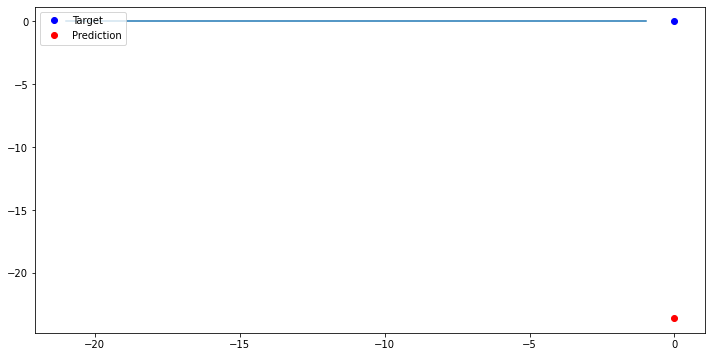

tf.Tensor(
[[[3.56646474e-03 0.00000000e+00 1.99386503e-01 2.82352941e-01
   2.20035778e-01 7.98722045e-02 2.67716535e-01 6.73469388e-01
   5.55674748e-02 4.68951417e-03 1.63486417e-02]
  [3.92048882e-03 0.00000000e+00 1.93251534e-01 2.47058824e-01
   2.30769231e-01 7.66773163e-02 2.75590551e-01 6.93877551e-01
   6.18079718e-02 4.68951417e-03 1.63486417e-02]
  [4.14339286e-03 0.00000000e+00 1.47239264e-01 2.11764706e-01
   8.76565295e-02 6.38977636e-02 3.62204724e-01 5.51020408e-01
   4.91497439e-02 4.68951417e-03 1.63486417e-02]
  [4.47119293e-03 0.00000000e+00 1.90184049e-01 2.23529412e-01
   2.93381038e-01 7.02875399e-02 4.01574803e-01 4.28571429e-01
   4.67151106e-02 4.68951417e-03 1.63486417e-02]
  [4.79899300e-03 0.00000000e+00 1.87116564e-01 2.23529412e-01
   2.32558140e-01 7.02875399e-02 2.75590551e-01 6.32653061e-01
   5.24798746e-02 4.68951417e-03 1.63486417e-02]
  [5.06123305e-03 0.00000000e+00 1.80981595e-01 2.15686275e-01
   1.16279070e-01 7.02875399e-02 2.67716535e-01 6.7

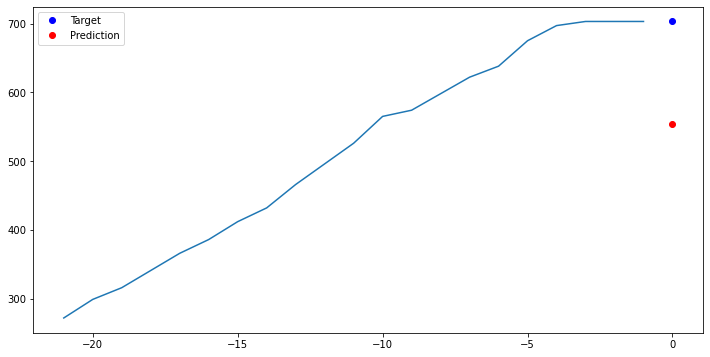

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.34355828e-01 2.47058824e-01
   1.62790698e-01 2.90734824e-01 6.77165354e-01 2.24489796e-01
   1.41824389e-01 5.85197942e-04 7.07774069e-03]
  [0.00000000e+00 0.00000000e+00 3.49693252e-01 2.86274510e-01
   1.62790698e-01 2.90734824e-01 6.85039370e-01 1.93393785e-01
   1.36292828e-01 5.85197942e-04 7.07774069e-03]
  [0.00000000e+00 0.00000000e+00 3.65030675e-01 2.78431373e-01
   1.62790698e-01 2.90734824e-01 7.08661417e-01 2.00688650e-01
   1.14670298e-01 5.85197942e-04 7.07774069e-03]
  [0.00000000e+00 0.00000000e+00 3.37423313e-01 2.86274510e-01
   1.62790698e-01 2.90734824e-01 6.61417323e-01 2.04081633e-01
   9.96893744e-02 5.85197942e-04 7.07774069e-03]
  [0.00000000e+00 0.00000000e+00 3.40490798e-01 3.01960784e-01
   1.62790698e-01 2.90734824e-01 6.61417323e-01 2.24489796e-01
   1.00510247e-01 5.85197942e-04 7.07774069e-03]
  [0.00000000e+00 0.00000000e+00 3.31288344e-01 2.86274510e-01
   1.62790698e-01 2.90734824e-01 6.61417323e-01 2.2

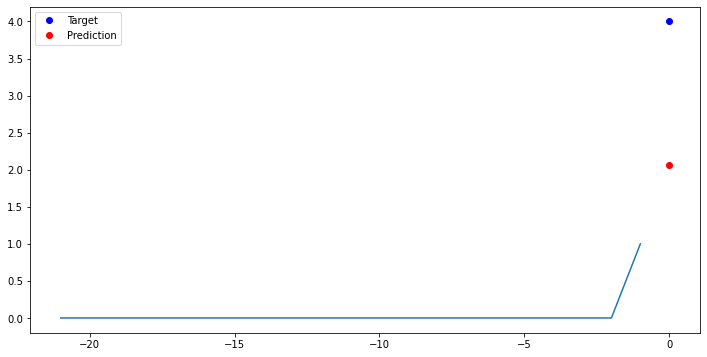

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.74233129e-01 3.92156863e-01
   1.62790698e-01 2.93929712e-01 6.69291339e-01 2.24489796e-01
   8.74695671e-02 1.18308396e-04 2.84820964e-03]
  [0.00000000e+00 0.00000000e+00 3.95705521e-01 4.23529412e-01
   1.62790698e-01 3.76996805e-01 6.22047244e-01 2.24489796e-01
   9.47921234e-02 1.18308396e-04 2.84820964e-03]
  [0.00000000e+00 0.00000000e+00 2.91411043e-01 3.56862745e-01
   1.62790698e-01 3.16293930e-01 5.82677165e-01 2.24489796e-01
   1.13457646e-01 1.18308396e-04 2.84820964e-03]
  [0.00000000e+00 0.00000000e+00 3.09815951e-01 3.52941176e-01
   1.62790698e-01 3.09904153e-01 6.61417323e-01 2.24489796e-01
   1.04353423e-01 1.18308396e-04 2.84820964e-03]
  [0.00000000e+00 0.00000000e+00 3.12883436e-01 3.37254902e-01
   1.62790698e-01 3.29073482e-01 6.61417323e-01 2.24489796e-01
   7.81414699e-02 1.18308396e-04 2.84820964e-03]
  [0.00000000e+00 0.00000000e+00 3.31288344e-01 4.19607843e-01
   1.62790698e-01 3.16293930e-01 5.03937008e-01 2.2

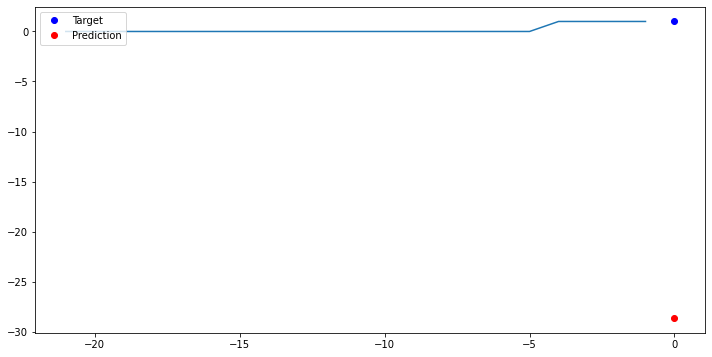

tf.Tensor(
[[[4.85144101e-04 2.98998356e-04 2.14723926e-01 3.60784314e-01
   1.80679785e-01 3.09904153e-01 3.85826772e-01 4.69387755e-01
   1.03476582e-01 1.04666603e-04 1.03235023e-02]
  [4.85144101e-04 2.98998356e-04 1.84049080e-01 3.29411765e-01
   1.28801431e-01 1.91693291e-01 4.01574803e-01 3.87755102e-01
   8.83743925e-02 1.04666603e-04 1.03235023e-02]
  [4.85144101e-04 2.98998356e-04 2.26993865e-01 3.37254902e-01
   2.25402504e-01 2.07667732e-01 4.01574803e-01 3.06122449e-01
   8.06227438e-02 1.04666603e-04 1.03235023e-02]
  [4.85144101e-04 2.98998356e-04 2.20858896e-01 3.52941176e-01
   1.23434705e-01 2.04472843e-01 4.17322835e-01 4.48979592e-01
   9.24134586e-02 1.04666603e-04 1.03235023e-02]
  [4.85144101e-04 2.98998356e-04 2.42331288e-01 3.84313725e-01
   2.84436494e-01 2.20447284e-01 4.09448819e-01 2.44897959e-01
   9.94281876e-02 1.04666603e-04 1.03235023e-02]
  [4.85144101e-04 2.98998356e-04 2.39263804e-01 3.68627451e-01
   2.68336315e-01 1.91693291e-01 4.09448819e-01 4.0

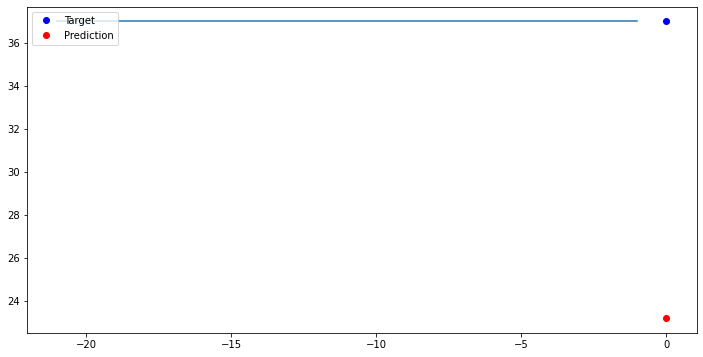

tf.Tensor(
[[[0.01489524 0.01136194 0.18711656 0.27058824 0.10554562 0.15015974
   0.37007874 0.40816327 0.04433645 0.00061043 0.10430486]
  [0.01526237 0.01136194 0.20858896 0.26666667 0.11270125 0.1629393
   0.31496063 0.55102041 0.05890693 0.00061043 0.10430486]
  [0.01557706 0.01166094 0.20552147 0.27058824 0.11806798 0.17252396
   0.30708661 0.40816327 0.06025951 0.00061043 0.10430486]
  [0.01593108 0.01195993 0.20858896 0.2745098  0.11449016 0.17252396
   0.2992126  0.55102041 0.06182663 0.00061043 0.10430486]
  [0.016272   0.01195993 0.21472393 0.27843137 0.11449016 0.16932907
   0.2992126  0.55102041 0.06554854 0.00061043 0.10430486]
  [0.01661291 0.01210943 0.20552147 0.29019608 0.11627907 0.17891374
   0.32283465 0.57142857 0.07403711 0.00061043 0.10430486]
  [0.0170456  0.01330543 0.19018405 0.28627451 0.09481216 0.17252396
   0.40944882 0.44897959 0.06436387 0.00061043 0.10430486]
  [0.01738652 0.01330543 0.1993865  0.28627451 0.11091234 0.15654952
   0.40944882 0.40816327 

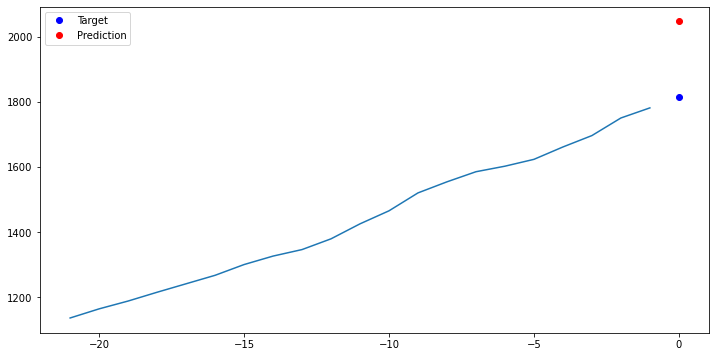

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.28220859e-01 3.21568627e-01
   1.62790698e-01 2.77955272e-01 7.08661417e-01 2.08692366e-01
   1.02506460e-01 3.27233740e-04 3.31210333e-03]
  [0.00000000e+00 0.00000000e+00 3.15950920e-01 3.21568627e-01
   1.62790698e-01 2.39616613e-01 6.85039370e-01 2.44897959e-01
   8.10331800e-02 3.27233740e-04 3.31210333e-03]
  [0.00000000e+00 0.00000000e+00 3.37423313e-01 3.21568627e-01
   1.62790698e-01 2.68370607e-01 6.85039370e-01 2.04081633e-01
   8.38595935e-02 3.27233740e-04 3.31210333e-03]
  [0.00000000e+00 0.00000000e+00 3.15950920e-01 3.49019608e-01
   1.62790698e-01 2.84345048e-01 7.00787402e-01 2.04081633e-01
   9.57902298e-02 3.27233740e-04 3.31210333e-03]
  [0.00000000e+00 0.00000000e+00 3.03680982e-01 3.52941176e-01
   1.62790698e-01 3.22683706e-01 6.69291339e-01 2.44897959e-01
   1.00482263e-01 3.27233740e-04 3.31210333e-03]
  [0.00000000e+00 0.00000000e+00 3.15950920e-01 3.41176471e-01
   1.62790698e-01 3.45047923e-01 6.85039370e-01 2.0

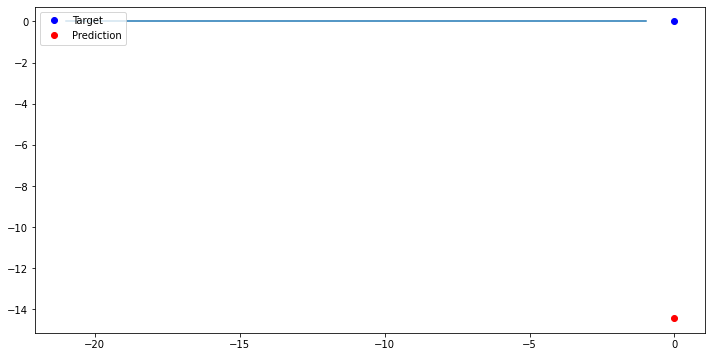

tf.Tensor(
[[[6.55600136e-04 8.96995067e-04 2.48466258e-01 2.74509804e-01
   1.62790698e-01 2.90734824e-01 4.25196850e-01 2.24489796e-01
   1.02739662e-01 3.10817501e-04 2.25013841e-03]
  [6.94936145e-04 8.96995067e-04 1.90184049e-01 1.92156863e-01
   1.62790698e-01 2.90734824e-01 3.93700787e-01 2.24489796e-01
   5.99330243e-02 3.10817501e-04 2.25013841e-03]
  [7.21160150e-04 8.96995067e-04 1.91338372e-01 2.66288515e-01
   1.62790698e-01 2.90734824e-01 3.07086614e-01 2.24489796e-01
   7.54829622e-02 3.10817501e-04 2.25013841e-03]
  [7.86720164e-04 1.04649424e-03 1.91802522e-01 2.73292644e-01
   1.62790698e-01 2.90734824e-01 3.07086614e-01 2.24489796e-01
   7.08282417e-02 3.10817501e-04 2.25013841e-03]
  [7.99832166e-04 1.04649424e-03 1.93008083e-01 2.76479381e-01
   1.62790698e-01 2.90734824e-01 2.99212598e-01 2.24489796e-01
   9.33555964e-02 3.10817501e-04 2.25013841e-03]
  [8.39168175e-04 1.04649424e-03 1.91491928e-01 2.82894805e-01
   1.62790698e-01 2.90734824e-01 2.91338583e-01 2.2

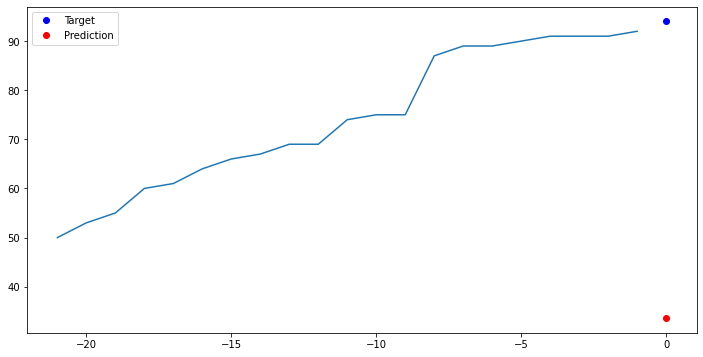

tf.Tensor(
[[[0.00376314 0.00254149 0.23006135 0.35294118 0.19879535 0.20766773
   0.36220472 0.55102041 0.11482888 0.00078522 0.01263779]
  [0.0038287  0.00254149 0.18711656 0.34509804 0.19499106 0.18530351
   0.44094488 0.40816327 0.094419   0.00078522 0.01263779]
  [0.00386804 0.00254149 0.2208589  0.31764706 0.18604651 0.22364217
   0.43307087 0.3877551  0.07094018 0.00078522 0.01263779]
  [0.0039336  0.00254149 0.23619632 0.32156863 0.19254586 0.2428115
   0.38582677 0.48979592 0.10113523 0.00078522 0.01263779]
  [0.0039336  0.00254149 0.2607362  0.35294118 0.19182958 0.23961661
   0.37795276 0.46938776 0.10399896 0.00078522 0.01263779]
  [0.00397294 0.00269099 0.25766871 0.34509804 0.19666578 0.23642173
   0.37795276 0.48979592 0.10224527 0.00078522 0.01263779]
  [0.00402538 0.00269099 0.24233129 0.35294118 0.22174531 0.23961661
   0.37795276 0.46938776 0.10463327 0.00078522 0.01263779]
  [0.0040385  0.00284048 0.21165644 0.3254902  0.14490161 0.19808307
   0.37007874 0.59183673 

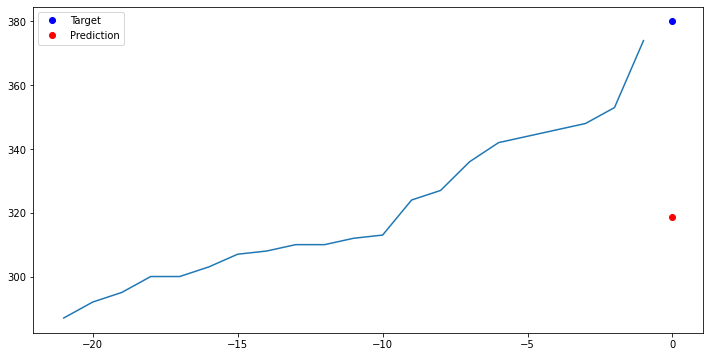

tf.Tensor(
[[[0.         0.         0.28834356 0.25098039 0.13059034 0.29073482
   0.48818898 0.42857143 0.1140733  0.0016995  0.00678468]
  [0.         0.         0.33128834 0.30980392 0.17889088 0.29073482
   0.7007874  0.20299681 0.13251495 0.0016995  0.00678468]
  [0.         0.         0.3404908  0.30588235 0.19677996 0.29073482
   0.7007874  0.20869237 0.09922297 0.0016995  0.00678468]
  [0.         0.         0.32208589 0.30588235 0.15921288 0.29073482
   0.68503937 0.2244898  0.09391528 0.0016995  0.00678468]
  [0.         0.         0.33742331 0.30588235 0.18604651 0.29073482
   0.66929134 0.2244898  0.09234816 0.0016995  0.00678468]
  [0.         0.         0.34355828 0.32156863 0.14669052 0.29073482
   0.68503937 0.20408163 0.09894313 0.0016995  0.00678468]
  [0.         0.         0.34969325 0.31764706 0.18604651 0.29073482
   0.66929134 0.20408163 0.10523026 0.0016995  0.00678468]
  [0.         0.         0.34662577 0.32156863 0.20930233 0.29073482
   0.66929134 0.20408163

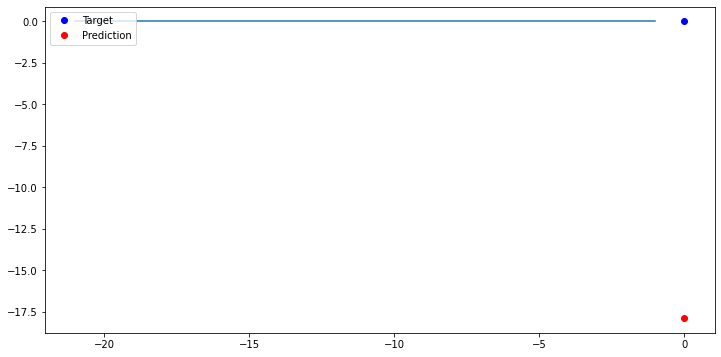

tf.Tensor(
[[[2.22904046e-04 1.49499178e-04 2.17411304e-01 2.82702388e-01
   1.62790698e-01 2.90734824e-01 3.93700787e-01 5.53670819e-01
   9.56689645e-02 5.60274966e-04 2.95957600e-03]
  [2.36016049e-04 1.49499178e-04 2.15648736e-01 2.83977221e-01
   1.62790698e-01 2.90734824e-01 3.77952756e-01 5.57138187e-01
   9.42697499e-02 5.60274966e-04 2.95957600e-03]
  [2.49128052e-04 1.49499178e-04 2.07551800e-01 2.79713118e-01
   1.62790698e-01 2.90734824e-01 3.62204724e-01 5.80570547e-01
   8.03242447e-02 5.60274966e-04 2.95957600e-03]
  [2.75352057e-04 1.49499178e-04 2.08496512e-01 3.29411765e-01
   1.62790698e-01 2.90734824e-01 3.70078740e-01 5.85827573e-01
   1.09148065e-01 5.60274966e-04 2.95957600e-03]
  [2.88464060e-04 1.49499178e-04 2.06875027e-01 3.37254902e-01
   1.62790698e-01 2.90734824e-01 4.80314961e-01 4.39251067e-01
   9.87285804e-02 5.60274966e-04 2.95957600e-03]
  [2.88464060e-04 1.49499178e-04 2.09905378e-01 2.75081411e-01
   1.62790698e-01 2.90734824e-01 4.48818898e-01 4.1

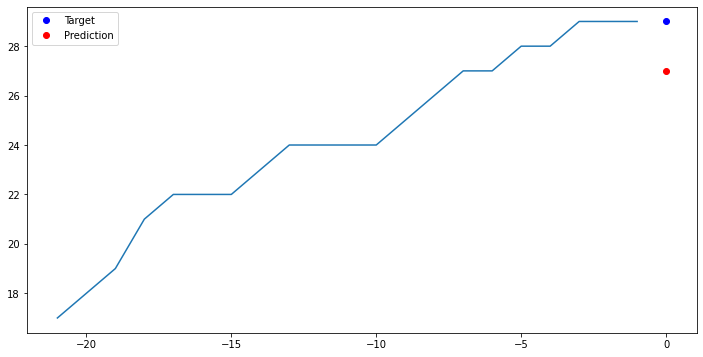

tf.Tensor(
[[[4.98256104e-04 0.00000000e+00 1.04294479e-01 1.68627451e-01
   3.39892665e-02 7.98722045e-02 2.83464567e-01 5.91836735e-01
   1.17160900e-02 1.05273267e-04 7.37717476e-03]
  [5.24480109e-04 1.49499178e-04 9.81595092e-02 1.68627451e-01
   3.75670841e-02 7.66773163e-02 2.67716535e-01 6.53061224e-01
   1.21918230e-02 1.05273267e-04 7.37717476e-03]
  [5.50704115e-04 2.98998356e-04 7.66871166e-02 1.29411765e-01
   2.50447227e-02 5.11182109e-02 2.44094488e-01 5.71428571e-01
   1.00463606e-02 1.05273267e-04 7.37717476e-03]
  [5.76928120e-04 2.98998356e-04 7.05521472e-02 1.05882353e-01
   2.14669052e-02 3.51437700e-02 2.12598425e-01 5.51020408e-01
   6.98674477e-03 1.05273267e-04 7.37717476e-03]
  [6.03152125e-04 2.98998356e-04 9.50920245e-02 1.37254902e-01
   2.86225403e-02 7.98722045e-02 2.91338583e-01 5.91836735e-01
   1.16414653e-02 1.05273267e-04 7.37717476e-03]
  [6.42488134e-04 2.98998356e-04 9.50920245e-02 1.49019608e-01
   2.86225403e-02 7.34824281e-02 2.83464567e-01 6.1

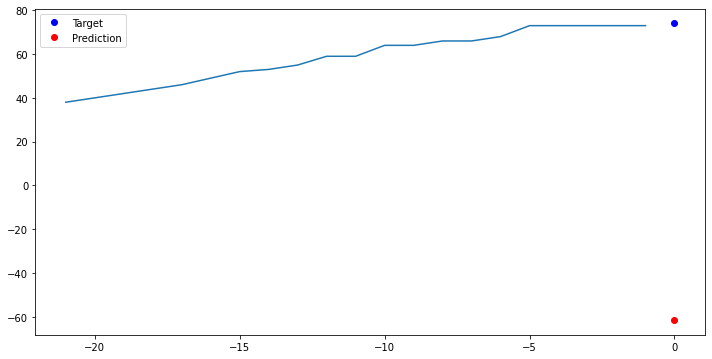

tf.Tensor(
[[[0.00499567 0.00209299 0.20858896 0.27843137 0.22182469 0.20766773
   0.33070866 0.53061224 0.06247027 0.00156083 0.03463006]
  [0.00508746 0.00209299 0.20552147 0.2745098  0.15563506 0.20127796
   0.32283465 0.55102041 0.06337509 0.00156083 0.03463006]
  [0.00520547 0.00209299 0.20552147 0.29019608 0.22898032 0.20766773
   0.33070866 0.53061224 0.06871076 0.00156083 0.03463006]
  [0.00546771 0.00209299 0.19325153 0.27058824 0.16457961 0.19488818
   0.33858268 0.57142857 0.07497924 0.00156083 0.03463006]
  [0.00566439 0.00209299 0.19325153 0.28235294 0.20751342 0.20447284
   0.44094488 0.44897959 0.06613621 0.00156083 0.03463006]
  [0.00571683 0.00224249 0.21165644 0.28235294 0.2039356  0.21405751
   0.42519685 0.3877551  0.05990504 0.00156083 0.03463006]
  [0.00586107 0.00224249 0.2208589  0.28627451 0.2236136  0.20447284
   0.34645669 0.51020408 0.06572577 0.00156083 0.03463006]
  [0.00597907 0.00254149 0.2208589  0.29803922 0.26118068 0.2172524
   0.33858268 0.34693878 

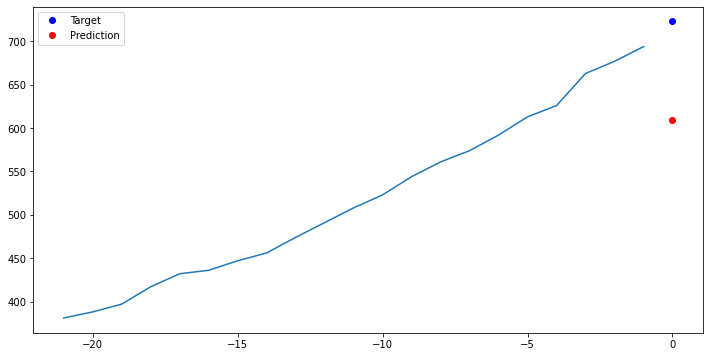

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 2.36196319e-01 3.68627451e-01
   1.62790698e-01 2.71565495e-01 5.11811024e-01 2.24489796e-01
   1.07711538e-01 5.42476787e-05 1.97371475e-03]
  [1.31120027e-05 0.00000000e+00 2.26993865e-01 3.09803922e-01
   1.62790698e-01 2.81150160e-01 3.93700787e-01 2.24489796e-01
   1.01946774e-01 5.42476787e-05 1.97371475e-03]
  [1.31120027e-05 0.00000000e+00 2.30061350e-01 3.33333333e-01
   1.62790698e-01 2.97124601e-01 3.85826772e-01 2.24489796e-01
   8.74229266e-02 5.42476787e-05 1.97371475e-03]
  [1.31120027e-05 0.00000000e+00 2.17791411e-01 2.94117647e-01
   1.62790698e-01 2.97124601e-01 3.85826772e-01 2.24489796e-01
   7.72086602e-02 5.42476787e-05 1.97371475e-03]
  [3.93360082e-05 0.00000000e+00 2.08588957e-01 3.09803922e-01
   1.62790698e-01 2.55591054e-01 3.62204724e-01 2.24489796e-01
   8.37942968e-02 5.42476787e-05 1.97371475e-03]
  [6.55600136e-05 0.00000000e+00 1.90184049e-01 3.05882353e-01
   1.62790698e-01 2.10862620e-01 3.46456693e-01 2.2

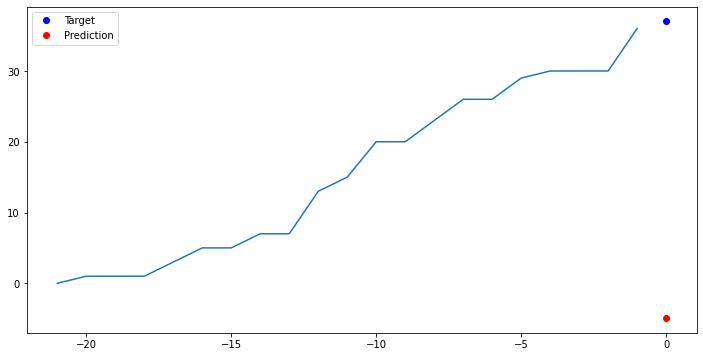

tf.Tensor(
[[[1.57344033e-04 1.49499178e-04 1.82071245e-01 3.03515831e-01
   1.65547234e-01 1.34185304e-01 4.56692913e-01 4.79280045e-01
   1.00547559e-01 2.89751334e-04 2.68992597e-03]
  [1.57344033e-04 1.49499178e-04 1.16641526e-01 1.60353300e-01
   1.48479428e-01 9.58466454e-02 4.48818898e-01 4.62063455e-01
   5.57167243e-02 2.89751334e-04 2.68992597e-03]
  [1.57344033e-04 1.49499178e-04 1.87315563e-01 2.47908709e-01
   1.28585928e-01 2.17252396e-01 3.54330709e-01 5.83340142e-01
   8.33931886e-02 2.89751334e-04 2.68992597e-03]
  [1.83568038e-04 1.49499178e-04 2.00642803e-01 2.68984394e-01
   1.60497871e-01 2.10862620e-01 4.25196850e-01 5.75639529e-01
   8.45685289e-02 2.89751334e-04 2.68992597e-03]
  [1.96680041e-04 1.49499178e-04 2.26667794e-01 2.93175431e-01
   1.58542960e-01 2.26837061e-01 4.09448819e-01 5.63234029e-01
   9.18724289e-02 2.89751334e-04 2.68992597e-03]
  [1.96680041e-04 1.49499178e-04 2.14812099e-01 2.88052118e-01
   1.61345338e-01 2.46006390e-01 4.25196850e-01 5.7

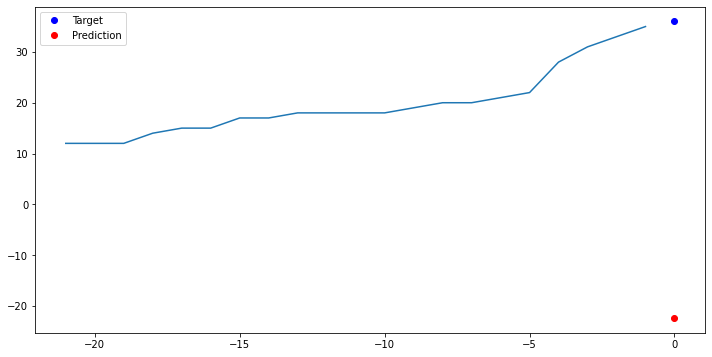

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.37423313e-01 3.25490196e-01
   1.53846154e-01 2.90734824e-01 6.77165354e-01 2.04081633e-01
   1.11713292e-01 1.97378730e-04 9.89457251e-03]
  [0.00000000e+00 0.00000000e+00 3.28220859e-01 3.05882353e-01
   1.68157424e-01 3.45047923e-01 3.70078740e-01 4.08163265e-01
   1.04819828e-01 1.97378730e-04 9.89457251e-03]
  [0.00000000e+00 0.00000000e+00 3.09815951e-01 3.17647059e-01
   1.86046512e-01 3.19488818e-01 6.85039370e-01 2.24489796e-01
   9.99132487e-02 1.97378730e-04 9.89457251e-03]
  [0.00000000e+00 0.00000000e+00 2.94478528e-01 3.01960784e-01
   1.61001789e-01 2.87539936e-01 6.85039370e-01 2.44897959e-01
   9.61260412e-02 1.97378730e-04 9.89457251e-03]
  [0.00000000e+00 0.00000000e+00 3.15950920e-01 3.25490196e-01
   2.16457961e-01 3.13099042e-01 6.77165354e-01 2.04081633e-01
   1.04735875e-01 1.97378730e-04 9.89457251e-03]
  [0.00000000e+00 0.00000000e+00 3.15950920e-01 3.13725490e-01
   2.43291592e-01 3.35463259e-01 7.00787402e-01 2.0

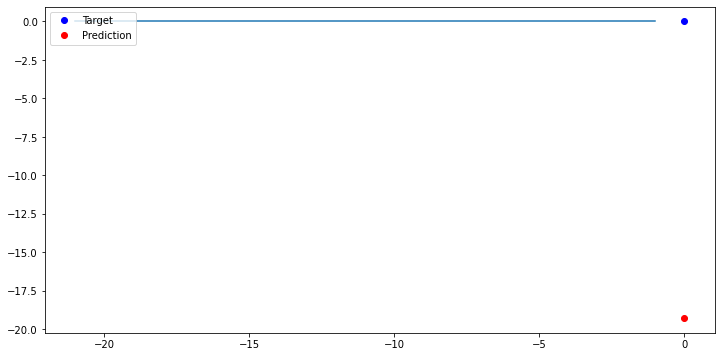

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.52760736e-01 3.37254902e-01
   1.62790698e-01 2.90734824e-01 6.53543307e-01 2.24489796e-01
   1.12384915e-01 6.30604525e-04 5.78716593e-03]
  [0.00000000e+00 0.00000000e+00 3.37423313e-01 3.25490196e-01
   1.62790698e-01 2.90734824e-01 6.77165354e-01 2.04081633e-01
   1.06965290e-01 6.30604525e-04 5.78716593e-03]
  [0.00000000e+00 0.00000000e+00 3.58895706e-01 3.37254902e-01
   1.62790698e-01 2.90734824e-01 6.77165354e-01 1.83673469e-01
   1.09586485e-01 6.30604525e-04 5.78716593e-03]
  [0.00000000e+00 0.00000000e+00 3.09815951e-01 2.90196078e-01
   1.62790698e-01 2.90734824e-01 6.45669291e-01 2.24489796e-01
   1.39632286e-01 6.30604525e-04 5.78716593e-03]
  [0.00000000e+00 0.00000000e+00 3.52760736e-01 3.25490196e-01
   1.62790698e-01 2.90734824e-01 6.45669291e-01 1.83673469e-01
   1.41712452e-01 6.30604525e-04 5.78716593e-03]
  [0.00000000e+00 0.00000000e+00 3.71165644e-01 3.45098039e-01
   1.62790698e-01 2.90734824e-01 6.69291339e-01 1.8

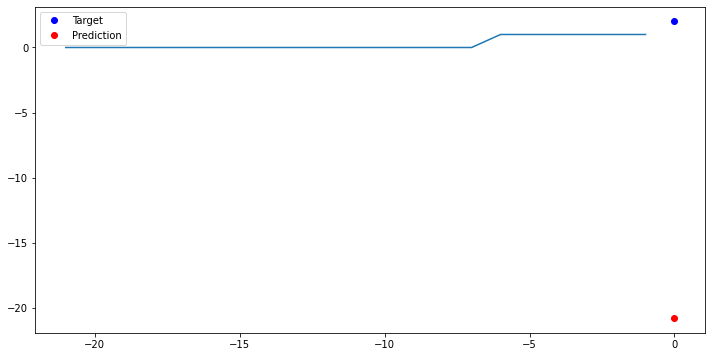

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.52760736e-01 4.23529412e-01
   1.62790698e-01 3.61022364e-01 6.85039370e-01 2.44897959e-01
   9.77024897e-02 4.35806997e-04 3.53423838e-03]
  [0.00000000e+00 0.00000000e+00 3.52760736e-01 4.70588235e-01
   1.62790698e-01 3.51437700e-01 8.18897638e-01 2.04081633e-01
   1.32123168e-01 4.35806997e-04 3.53423838e-03]
  [0.00000000e+00 0.00000000e+00 3.58895706e-01 4.11764706e-01
   1.62790698e-01 3.09904153e-01 7.32283465e-01 2.71900597e-01
   1.12487524e-01 4.35806997e-04 3.53423838e-03]
  [0.00000000e+00 0.00000000e+00 3.65030675e-01 4.70588235e-01
   1.62790698e-01 3.61022364e-01 6.37795276e-01 2.81346679e-01
   9.41671408e-02 4.35806997e-04 3.53423838e-03]
  [0.00000000e+00 0.00000000e+00 3.19018405e-01 5.17647059e-01
   1.62790698e-01 2.93929712e-01 5.98425197e-01 3.26530612e-01
   8.86822197e-02 4.35806997e-04 3.53423838e-03]
  [0.00000000e+00 0.00000000e+00 3.22085890e-01 4.35294118e-01
   1.62790698e-01 3.29073482e-01 5.43307087e-01 3.4

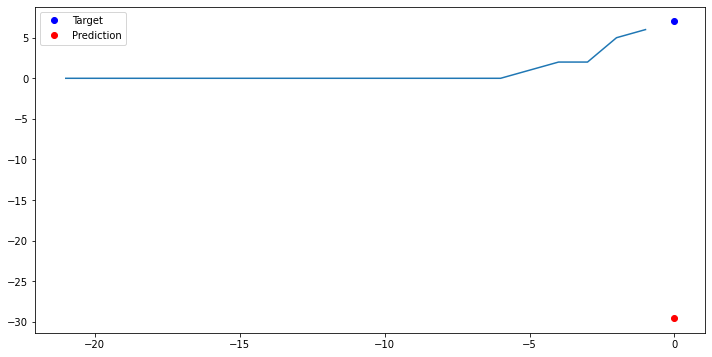

tf.Tensor(
[[[9.17840191e-05 1.49499178e-04 1.62576687e-01 2.23529412e-01
   1.55884835e-01 2.61980831e-01 3.77952756e-01 4.08163265e-01
   4.07171441e-02 1.39838020e-03 1.06454488e-02]
  [9.17840191e-05 1.49499178e-04 1.90184049e-01 2.70588235e-01
   1.53761206e-01 2.77955272e-01 3.14960630e-01 5.10204082e-01
   5.52036790e-02 1.39838020e-03 1.06454488e-02]
  [1.04896022e-04 1.49499178e-04 1.80981595e-01 2.62745098e-01
   1.52295602e-01 2.39616613e-01 2.99212598e-01 5.51020408e-01
   5.41682602e-02 1.39838020e-03 1.06454488e-02]
  [1.04896022e-04 2.98998356e-04 1.99386503e-01 2.86274510e-01
   1.71431178e-01 2.49201278e-01 2.91338583e-01 5.30612245e-01
   5.66122217e-02 1.39838020e-03 1.06454488e-02]
  [1.18008025e-04 2.98998356e-04 1.87116564e-01 2.78431373e-01
   1.66583685e-01 2.52396166e-01 2.83464567e-01 5.51020408e-01
   6.24702667e-02 1.39838020e-03 1.06454488e-02]
  [1.18008025e-04 2.98998356e-04 1.84049080e-01 2.78431373e-01
   1.48286462e-01 2.55591054e-01 2.83464567e-01 5.7

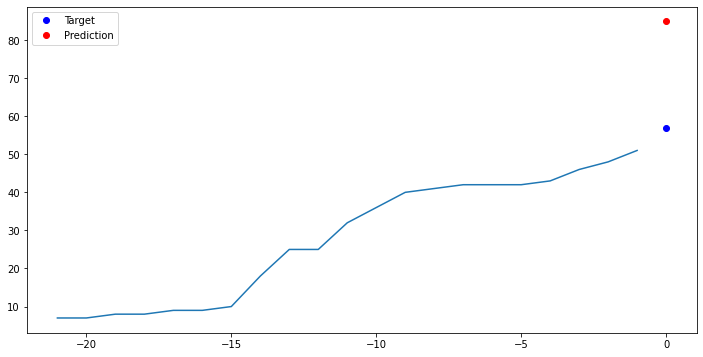

tf.Tensor(
[[[5.90040123e-04 1.49499178e-04 2.48466258e-01 3.21568627e-01
   1.62790698e-01 2.90734824e-01 3.38582677e-01 4.89795918e-01
   8.20592707e-02 4.93295746e-04 5.86157619e-03]
  [6.03152125e-04 1.49499178e-04 2.48466258e-01 2.94117647e-01
   1.62790698e-01 2.90734824e-01 3.30708661e-01 4.28571429e-01
   8.69658498e-02 4.93295746e-04 5.86157619e-03]
  [6.03152125e-04 1.49499178e-04 2.51533742e-01 3.21568627e-01
   1.62790698e-01 2.90734824e-01 3.30708661e-01 5.71428571e-01
   7.86078748e-02 4.93295746e-04 5.86157619e-03]
  [6.03152125e-04 1.49499178e-04 2.69938650e-01 3.52941176e-01
   1.62790698e-01 2.90734824e-01 3.38582677e-01 5.10204082e-01
   9.96520620e-02 4.93295746e-04 5.86157619e-03]
  [6.03152125e-04 1.49499178e-04 2.57668712e-01 3.72549020e-01
   1.62790698e-01 2.90734824e-01 4.25196850e-01 4.89795918e-01
   1.09250674e-01 4.93295746e-04 5.86157619e-03]
  [6.29376131e-04 1.49499178e-04 2.63803681e-01 3.96078431e-01
   1.62790698e-01 2.90734824e-01 5.03937008e-01 3.8

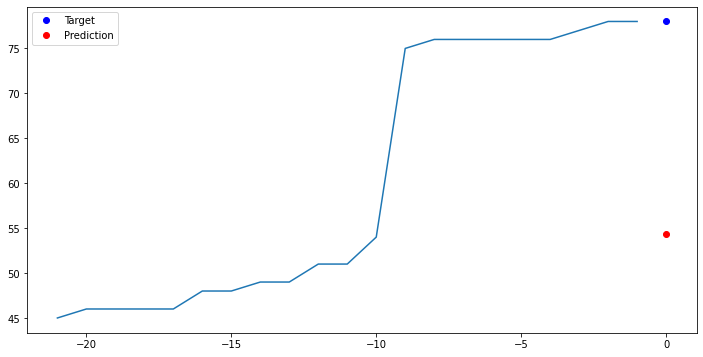

tf.Tensor(
[[[0.         0.         0.32515337 0.30196078 0.17882029 0.30768029
   0.66929134 0.2244898  0.10016511 0.00198776 0.01185404]
  [0.         0.         0.33742331 0.31764706 0.18156851 0.28434505
   0.67716535 0.2244898  0.1194183  0.00198776 0.01185404]
  [0.         0.         0.3404908  0.32941176 0.19939638 0.31956342
   0.66929134 0.20408163 0.1140733  0.00198776 0.01185404]
  [0.         0.         0.35889571 0.34117647 0.21061513 0.32623472
   0.66141732 0.18367347 0.08808522 0.00198776 0.01185404]
  [0.         0.         0.33128834 0.33333333 0.18134624 0.30015741
   0.67716535 0.20408163 0.10070614 0.00198776 0.01185404]
  [0.         0.         0.34662577 0.32941176 0.19478323 0.30441566
   0.68503937 0.20408163 0.09551039 0.00198776 0.01185404]
  [0.         0.         0.35582822 0.3372549  0.19219269 0.30513341
   0.68503937 0.20408163 0.09636857 0.00198776 0.01185404]
  [0.         0.         0.3404908  0.32156863 0.19361981 0.30910772
   0.67716535 0.20408163

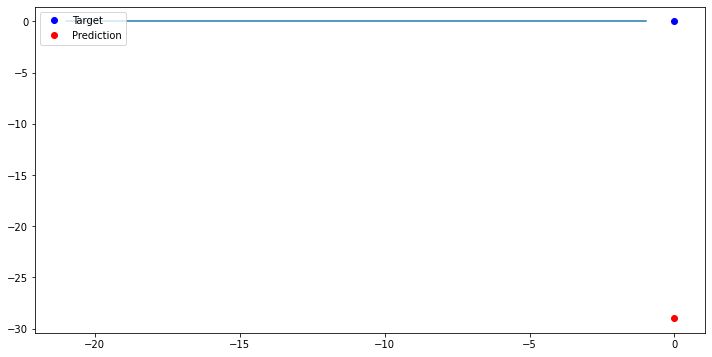

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 2.23926380e-01 3.41176471e-01
   1.77410642e-01 2.39159369e-01 4.64566929e-01 4.08163265e-01
   1.00734121e-01 5.57498141e-05 6.41960335e-03]
  [0.00000000e+00 0.00000000e+00 1.84049080e-01 2.98039216e-01
   8.40787120e-02 2.38000413e-01 5.19685039e-01 4.08163265e-01
   9.48294357e-02 5.57498141e-05 6.41960335e-03]
  [0.00000000e+00 0.00000000e+00 1.93251534e-01 2.70588235e-01
   1.70481715e-01 2.18404757e-01 5.03937008e-01 4.08907003e-01
   6.96715577e-02 5.57498141e-05 6.41960335e-03]
  [3.93360082e-05 0.00000000e+00 2.20858896e-01 3.68627451e-01
   1.37616001e-01 2.18693228e-01 4.48818898e-01 4.08163265e-01
   6.74048301e-02 5.57498141e-05 6.41960335e-03]
  [3.93360082e-05 0.00000000e+00 1.80981595e-01 2.62745098e-01
   1.62530177e-01 2.22539247e-01 4.17322835e-01 5.10204082e-01
   6.14068636e-02 5.57498141e-05 6.41960335e-03]
  [3.93360082e-05 0.00000000e+00 1.77914110e-01 2.54901961e-01
   1.68326434e-01 1.69329073e-01 3.93700787e-01 4.8

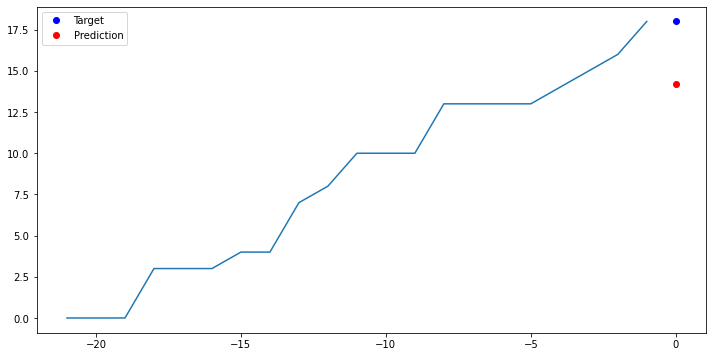

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.28220859e-01 3.56862745e-01
   2.02146691e-01 3.29073482e-01 6.85039370e-01 1.83673469e-01
   1.20640281e-01 3.34913337e-04 1.18431850e-02]
  [0.00000000e+00 0.00000000e+00 3.46625767e-01 4.00000000e-01
   2.18246869e-01 3.25878594e-01 6.92913386e-01 2.04081633e-01
   6.31885302e-02 3.34913337e-04 1.18431850e-02]
  [0.00000000e+00 0.00000000e+00 3.34355828e-01 3.60784314e-01
   1.73524150e-01 2.97124601e-01 8.34645669e-01 1.42857143e-01
   9.93908753e-02 3.34913337e-04 1.18431850e-02]
  [0.00000000e+00 0.00000000e+00 3.28220859e-01 3.92156863e-01
   2.12880143e-01 3.25878594e-01 6.85039370e-01 2.04081633e-01
   9.90830480e-02 3.34913337e-04 1.18431850e-02]
  [0.00000000e+00 0.00000000e+00 3.34355828e-01 3.80392157e-01
   2.54025045e-01 3.13099042e-01 6.77165354e-01 2.04081633e-01
   1.02413179e-01 3.34913337e-04 1.18431850e-02]
  [0.00000000e+00 0.00000000e+00 3.40490798e-01 4.78431373e-01
   2.50447227e-01 3.03514377e-01 6.69291339e-01 1.8

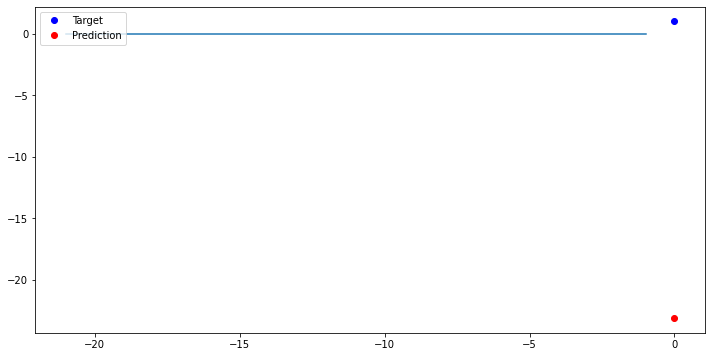

tf.Tensor(
[[[5.11368106e-04 0.00000000e+00 2.91411043e-01 2.90196078e-01
   9.12343470e-02 2.35579546e-01 3.77952756e-01 4.28571429e-01
   9.86539556e-02 1.24120310e-05 4.61742069e-03]
  [5.76928120e-04 0.00000000e+00 2.85276074e-01 2.82352941e-01
   9.83899821e-02 2.37082424e-01 3.70078740e-01 4.28571429e-01
   1.01247167e-01 1.24120310e-05 4.61742069e-03]
  [5.76928120e-04 0.00000000e+00 2.69938650e-01 2.74509804e-01
   8.05008945e-02 2.28091674e-01 3.85826772e-01 4.48979592e-01
   1.12170368e-01 1.24120310e-05 4.61742069e-03]
  [5.76928120e-04 0.00000000e+00 3.12883436e-01 3.25490196e-01
   5.36672630e-02 2.39300635e-01 4.33070866e-01 3.82418784e-01
   1.08299208e-01 1.24120310e-05 4.61742069e-03]
  [5.76928120e-04 0.00000000e+00 3.28220859e-01 3.49059402e-01
   6.26118068e-02 2.30401605e-01 4.33070866e-01 3.34682315e-01
   7.34401090e-02 1.24120310e-05 4.61742069e-03]
  [5.76928120e-04 0.00000000e+00 2.88343558e-01 2.86274510e-01
   7.51341682e-02 2.31706762e-01 4.17322835e-01 3.8

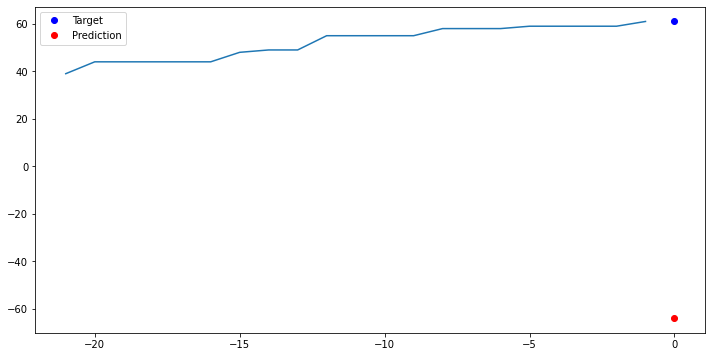

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 3.31288344e-01 3.41176471e-01
   1.62790698e-01 2.90734824e-01 7.32283465e-01 2.24489796e-01
   1.67411360e-01 3.34258683e-05 3.02860721e-03]
  [0.00000000e+00 0.00000000e+00 3.25153374e-01 3.49019608e-01
   1.62790698e-01 2.90734824e-01 6.53543307e-01 2.24489796e-01
   1.17944461e-01 3.34258683e-05 3.02860721e-03]
  [0.00000000e+00 0.00000000e+00 3.71165644e-01 4.15686275e-01
   1.62790698e-01 2.90734824e-01 6.92913386e-01 2.24489796e-01
   1.08635020e-01 3.34258683e-05 3.02860721e-03]
  [0.00000000e+00 0.00000000e+00 3.55828221e-01 3.64705882e-01
   1.62790698e-01 2.90734824e-01 7.48031496e-01 2.24489796e-01
   1.10631232e-01 3.34258683e-05 3.02860721e-03]
  [0.00000000e+00 0.00000000e+00 3.37423313e-01 3.56862745e-01
   1.62790698e-01 2.90734824e-01 7.48031496e-01 2.24489796e-01
   1.06974618e-01 3.34258683e-05 3.02860721e-03]
  [0.00000000e+00 0.00000000e+00 3.37423313e-01 3.64705882e-01
   1.62790698e-01 2.90734824e-01 7.48031496e-01 2.2

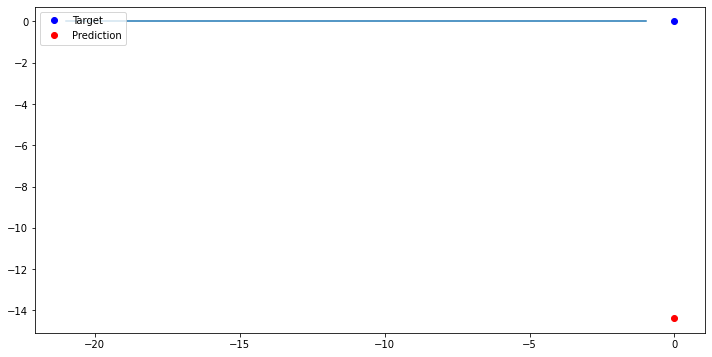

tf.Tensor(
[[[3.93360082e-05 0.00000000e+00 3.31288344e-01 4.54901961e-01
   2.20035778e-01 2.42811502e-01 6.37795276e-01 2.65306122e-01
   9.10795407e-02 2.23523969e-03 3.49623635e-02]
  [5.24480109e-05 0.00000000e+00 2.94478528e-01 4.54901961e-01
   1.32379249e-01 2.01277955e-01 5.98425197e-01 3.26530612e-01
   8.52308238e-02 2.23523969e-03 3.49623635e-02]
  [5.24480109e-05 0.00000000e+00 2.63803681e-01 3.76470588e-01
   1.50268336e-01 2.04472843e-01 6.29921260e-01 3.26530612e-01
   7.79082675e-02 2.23523969e-03 3.49623635e-02]
  [1.04896022e-04 0.00000000e+00 2.48466258e-01 3.37254902e-01
   2.55813953e-01 2.93257104e-01 5.74803150e-01 3.26530612e-01
   5.84032163e-02 2.23523969e-03 3.49623635e-02]
  [1.04896022e-04 0.00000000e+00 2.85276074e-01 4.23529412e-01
   2.32558140e-01 1.78913738e-01 4.01574803e-01 4.28571429e-01
   6.52873520e-02 2.23523969e-03 3.49623635e-02]
  [1.31120027e-04 0.00000000e+00 2.36196319e-01 3.80392157e-01
   2.16457961e-01 1.53354633e-01 2.99212598e-01 5.7

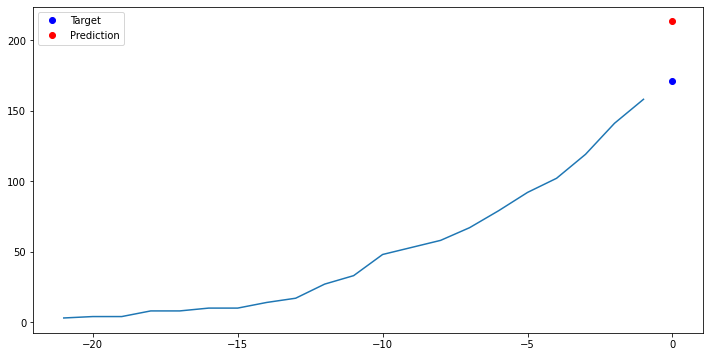

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 1.90184049e-01 3.13725490e-01
   1.62790698e-01 1.24600639e-01 4.40944882e-01 4.08907003e-01
   3.52415511e-02 4.66228324e-04 3.37157177e-03]
  [0.00000000e+00 0.00000000e+00 1.34969325e-01 2.39215686e-01
   1.62790698e-01 1.24600639e-01 3.54330709e-01 5.10631798e-01
   3.19020923e-02 4.66228324e-04 3.37157177e-03]
  [0.00000000e+00 0.00000000e+00 1.71779141e-01 3.33333333e-01
   1.62790698e-01 1.43769968e-01 3.38582677e-01 5.45837869e-01
   3.52415511e-02 4.66228324e-04 3.37157177e-03]
  [0.00000000e+00 0.00000000e+00 1.80981595e-01 3.17647059e-01
   1.62790698e-01 2.19756738e-01 3.46456693e-01 5.48927263e-01
   4.08663937e-02 4.66228324e-04 3.37157177e-03]
  [0.00000000e+00 0.00000000e+00 1.96319018e-01 3.52941176e-01
   1.62790698e-01 1.85303514e-01 3.54330709e-01 5.57673221e-01
   4.59315504e-02 4.66228324e-04 3.37157177e-03]
  [0.00000000e+00 0.00000000e+00 1.77914110e-01 2.74509804e-01
   1.62790698e-01 1.43769968e-01 3.46456693e-01 5.8

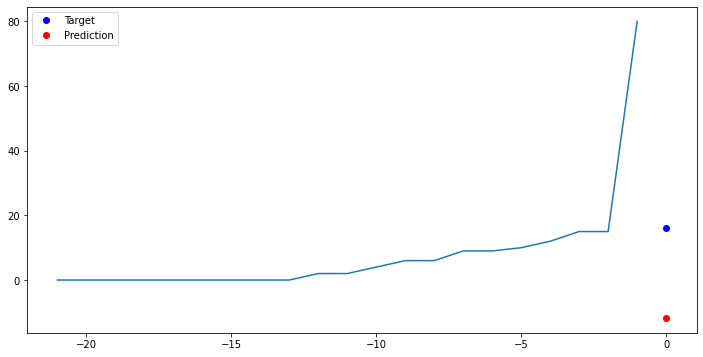

tf.Tensor(
[[[4.85144101e-04 1.49499178e-04 2.33128834e-01 3.05882353e-01
   3.23792487e-01 1.91764669e-01 3.46456693e-01 5.30612245e-01
   6.76380325e-02 3.31124108e-03 2.23489776e-02]
  [5.50704115e-04 1.49499178e-04 1.90184049e-01 2.62745098e-01
   1.75313059e-01 1.85358493e-01 4.33070866e-01 4.48979592e-01
   5.79554677e-02 3.31124108e-03 2.23489776e-02]
  [5.90040123e-04 1.49499178e-04 1.84049080e-01 2.39215686e-01
   1.62790698e-01 1.76812338e-01 3.70078740e-01 4.28571429e-01
   4.17525629e-02 3.31124108e-03 2.23489776e-02]
  [6.03152125e-04 2.98998356e-04 2.17791411e-01 2.78431373e-01
   2.02146691e-01 1.96494498e-01 3.54330709e-01 5.30612245e-01
   5.96438533e-02 3.31124108e-03 2.23489776e-02]
  [7.60496158e-04 2.98998356e-04 2.17791411e-01 2.74509804e-01
   2.57602862e-01 2.06367315e-01 3.46456693e-01 5.51020408e-01
   5.94946037e-02 3.31124108e-03 2.23489776e-02]
  [8.12944169e-04 2.98998356e-04 2.11656442e-01 2.78431373e-01
   2.21824687e-01 2.05018097e-01 3.30708661e-01 5.5

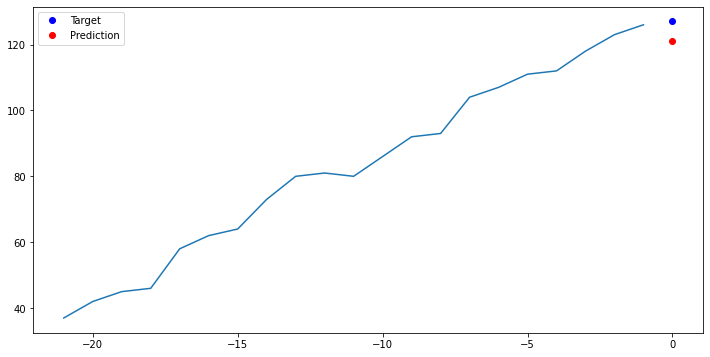

In [999]:
def rescale_value(category, value):
    scaled_value = data_tagged[category].min() + ((data_tagged[category].max() - data_tagged[category].min()) * value)
    return scaled_value

for x, y in test_data_tf.take(100):
    plt.figure(figsize=(12, 6))
    time_before = create_time_steps(len(x[0]))
    time_after = len(y[0]) / 2
    history_scaled = []
    for k in x[0][:, 0]:
        history_scaled.append(rescale_value("cases", k))
    plt.plot(time_before, history_scaled)
    targets_scaled = []
    for i in y[0][:1]:
        targets_scaled.append(rescale_value("cases", i))
    predictions_scaled = []
    print(x)
    predictions = model.predict(x)[0][:1]
    for j in predictions:
        predictions_scaled.append(rescale_value("cases", j))
    plt.plot(np.arange(time_after), targets_scaled, 'bo', label='Target')
    plt.plot(np.arange(time_after), predictions_scaled, 'ro', label='Prediction')
    plt.legend(loc='upper left')
    plt.show()

In [77]:
print(type(data_by_county))
observation_lengths = []
for k, v in data_by_county.items():
    observation_length = len(v)
    observation_lengths.append(len(v))
    print(len(v))
shortest_observation = min(observation_lengths)
print(f"Shortest observation period: {shortest_observation}")

<class 'dict'>
105
105
105
105
91
91
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
91
105
105
105
105
105
99
105
105
105
105
105
105
105
105
105
105
105
105
99
105
105
105
105
105
105
105
105
105
105
103
105
105
105
91
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
91
105
105
105
105
210
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
91
105
105
105
105
91
105
100
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
95
105
105
105
105
91
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
104
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
91
105
1

In [508]:
def build_dataset(dataset, observation_period=21, days_in_future=7):
    all_observations = []
    all_targets = []
    eligible_counties = {}
    min_observation_length = 9999
    for e, (k, v) in enumerate(dataset.items()):
        observation_length = len(v)
        if observation_length < 2 * observation_period + days_in_future + 1:
            continue
        if observation_length < min_observation_length:
            min_observation_length = observation_length
        eligible_counties[e] = v
    
    start_index = observation_period
    end_index = min_observation_length - days_in_future + 1

    for i in range(start_index, end_index):
        all_county_observations = []
        all_county_targets = []
        for eligible_county, eligible_data in eligible_counties.items():
            eligible_targets = pd.concat([eligible_data["cases"], eligible_data["deaths"]], axis=1)
            eligible_observations = eligible_data.drop(["county", "date"], axis=1)
            
            indices = range(i - observation_period, i)
            
            observation_series = eligible_observations.iloc[indices, :].values.flatten()
            all_county_observations.append(observation_series)
            
            target_series = eligible_targets.iloc[i:i+days_in_future, :].values.flatten('F')
            all_county_targets.append(target_series)
            
        all_county_observations = np.array(all_county_observations)
        all_observations.append(all_county_observations)
        
        all_county_targets = np.array(all_county_targets).flatten()
        all_targets.append(all_county_targets)
        
    return np.array(all_observations), np.array(all_targets)

In [509]:
eligible_observations, eligible_targets = build_dataset(data_by_county)

In [510]:
def shuffle_eligible_data(observations, targets, training_percentage=0.8):
    complete_set = list(zip(observations, targets))
    random.shuffle(complete_set)
    shuffled_observations, shuffled_targets = zip(*complete_set)
    boundary = int(len(targets) * training_percentage)
    return (np.array(shuffled_observations[:boundary]),
            np.array(shuffled_targets[:boundary]), 
            np.array(shuffled_observations[boundary:]), 
            np.array(shuffled_targets[boundary:]))

In [511]:
e_training_obs, e_training_tar, e_testing_obs, e_testing_tar = shuffle_eligible_data(eligible_observations, eligible_targets)

In [512]:
print ('Single window of past history : {}'.format(e_training_obs[0].shape))
print ('\n Target temperature to predict : {}'.format(e_training_tar[0].shape))

Single window of past history : (2006, 231)

 Target temperature to predict : (28084,)


In [513]:
BATCH_SIZE = 1

e_training = tf.data.Dataset.from_tensor_slices((e_training_obs, e_training_tar))
e_training = e_training.shuffle(99999).batch(BATCH_SIZE).repeat()

e_testing = tf.data.Dataset.from_tensor_slices((e_testing_obs, e_testing_tar))
e_testing = e_testing.shuffle(99999).batch(BATCH_SIZE)

In [514]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(128, return_sequences=True, input_shape=eligible_observations.shape[-2:], activation='relu'))
model.add(tf.keras.layers.LSTM(128, activation='relu'))
model.add(tf.keras.layers.Dense(28084))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae')

In [515]:
EPOCHS = 3
EVALUATION_INTERVAL = 200

model_history_new = model.fit(e_training, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL)

Epoch 1/3
200/200 [==============================] - 485s 2s/step - loss: 6.6820e-04
Epoch 2/3
200/200 [==============================] - 538s 3s/step - loss: 3.4298e-04
Epoch 3/3
200/200 [==============================] - 473s 2s/step - loss: 2.8786e-04


done
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2.]
[  5.   6.   8.  10.  55.  86. 101.]


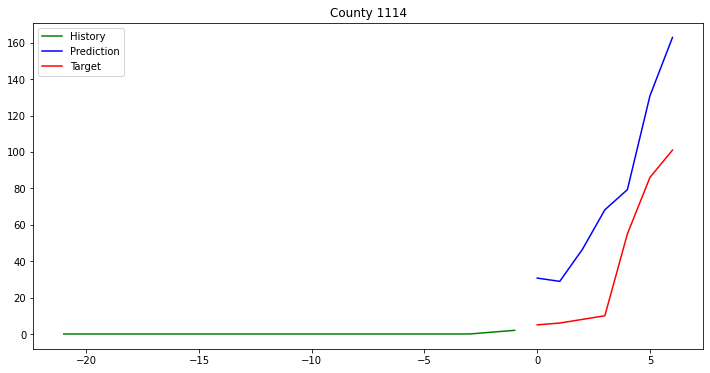

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


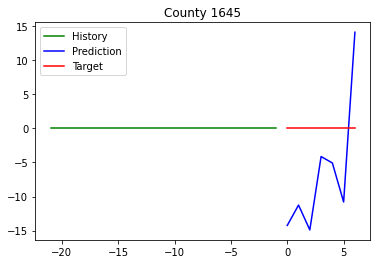

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
[ 1.  1.  3.  5.  8.  9. 13.]


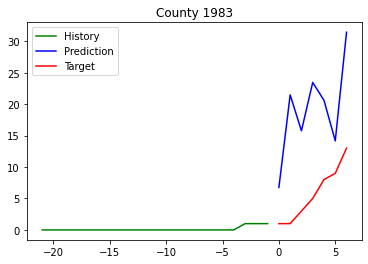

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


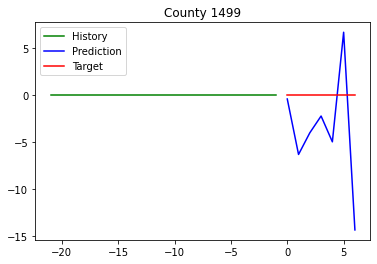

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
[0. 0. 0. 1. 1. 1. 2.]


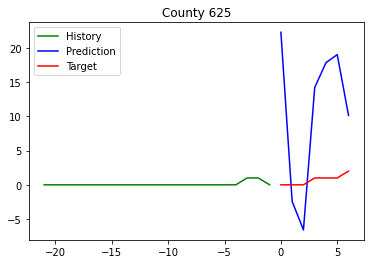

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


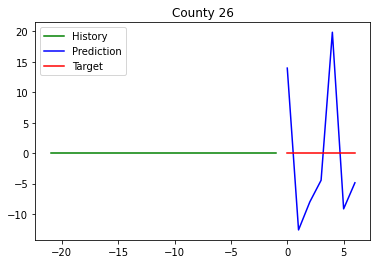

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 1.]


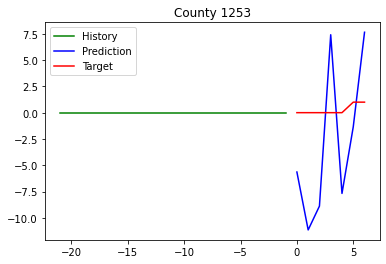

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 1.]


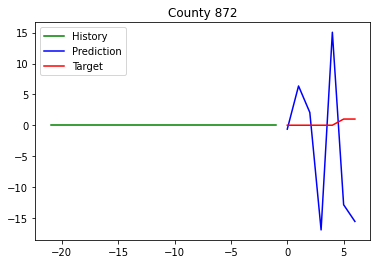

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


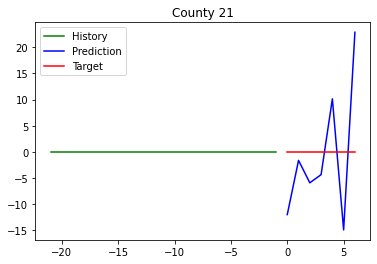

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


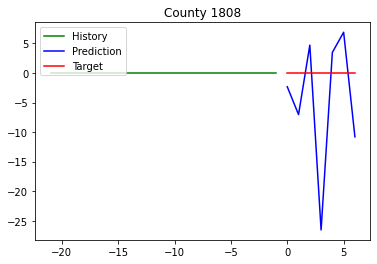

done
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


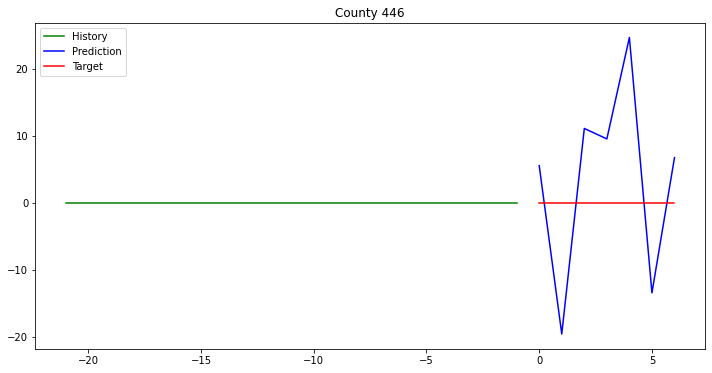

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


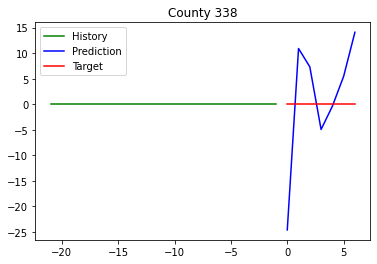

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


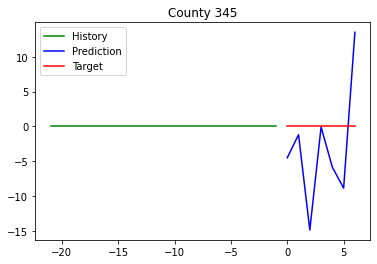

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 1.]


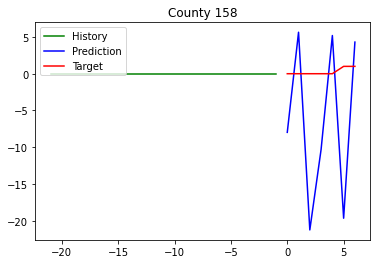

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


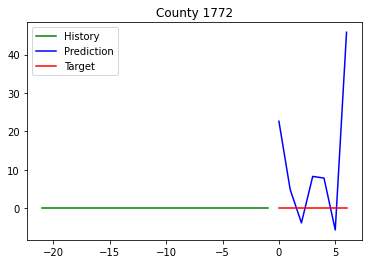

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


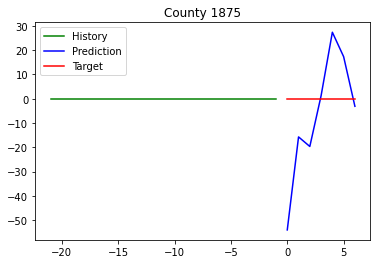

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


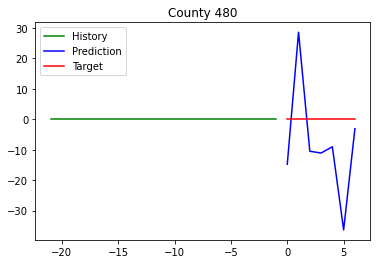

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


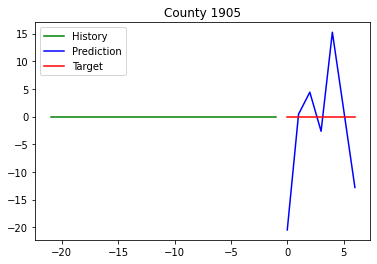

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


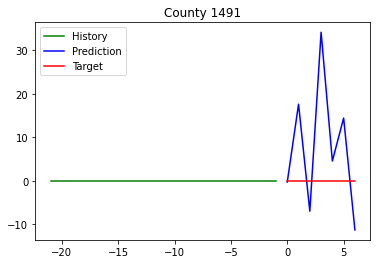

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


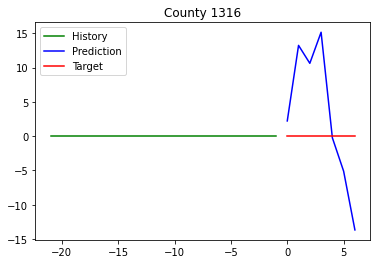

done
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 2. 3.]


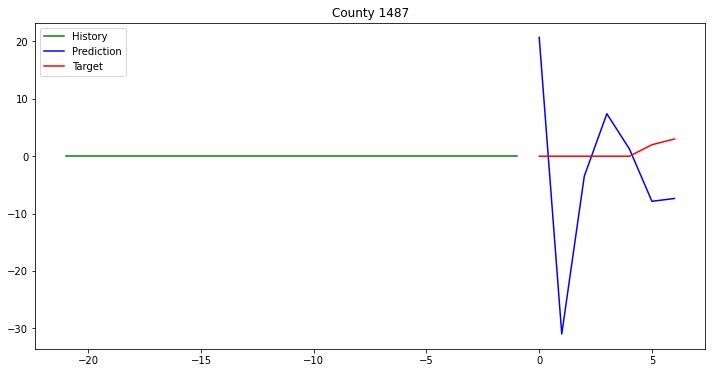

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  2.  2.  3.
  6. 10. 10.]
[15. 16. 19. 20. 20. 24. 24.]


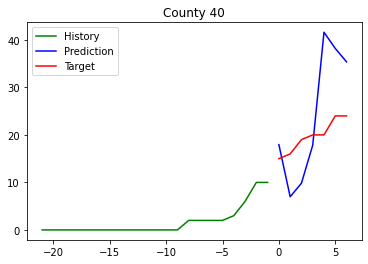

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1.]


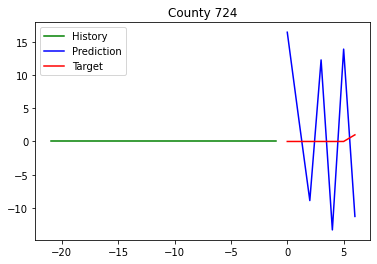

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 1. 1. 1. 1.]


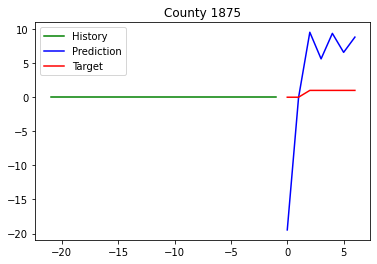

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


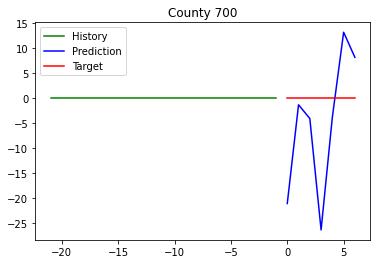

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.  0.  3.  7.  8. 12. 16.]


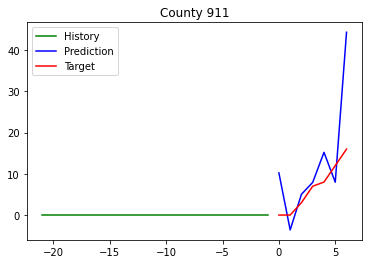

[ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  2.  2.  6.  6.  8. 10. 14.
 19. 24. 37.]
[ 42.  73. 129. 166. 219. 291. 337.]


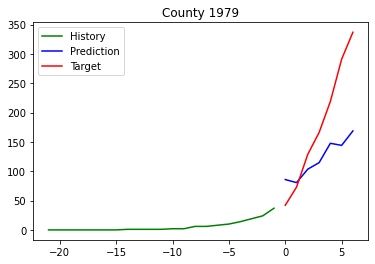

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  3.  4.  4.  9.
 10. 16. 22.]
[22. 27. 42. 53. 70. 72. 79.]


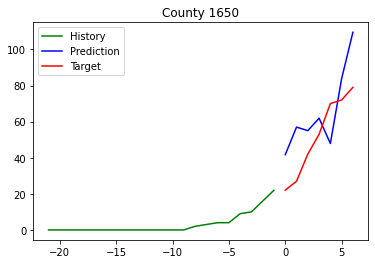

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2.]
[ 2.  6.  7.  7.  7.  9. 12.]


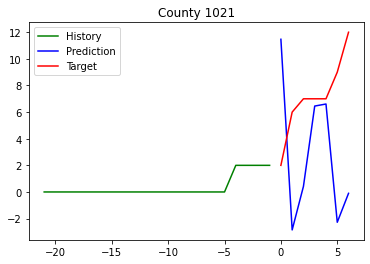

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1.]


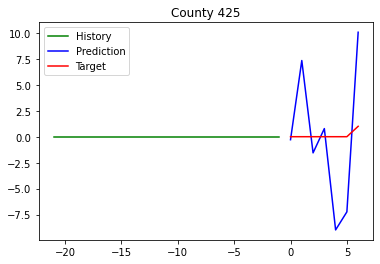

done
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.
  5.  7. 13.]
[14. 17. 18. 20. 24. 27. 31.]


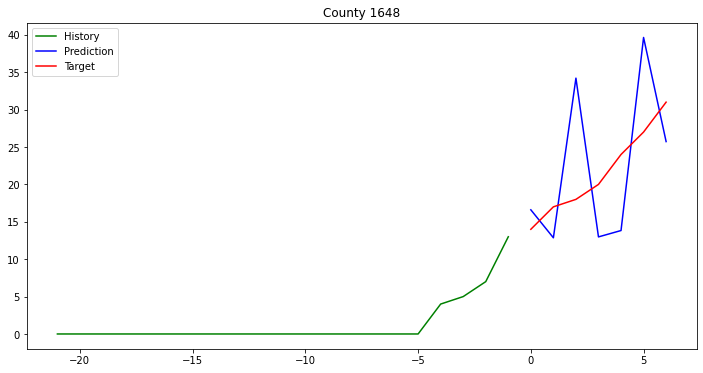

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 1. 1. 1. 1.]


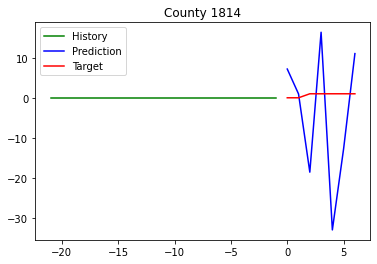

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 2. 2.]


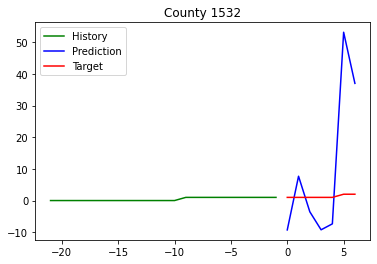

[  0.   0.   0.   0.   0.   0.   0.   1.   2.   2.   5.   8.   8.  29.
  52.  60.  65.  83. 115. 129. 152.]
[180. 194. 217. 234. 252. 262. 268.]


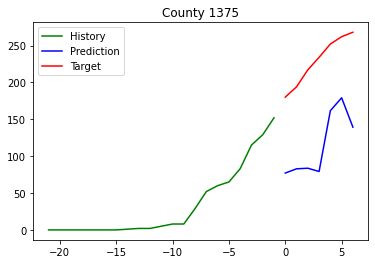

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


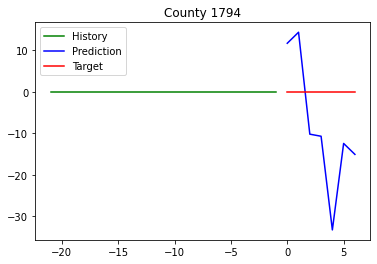

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1.]


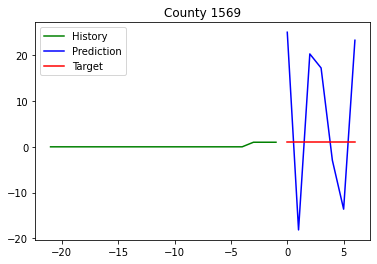

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  1.  1.  1.  1.  6.
  6. 10. 17.]
[17. 18. 20. 23. 33. 35. 37.]


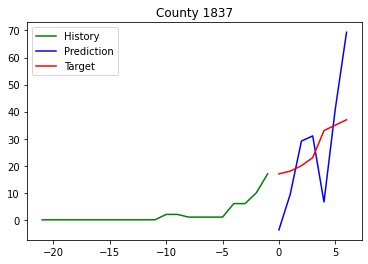

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


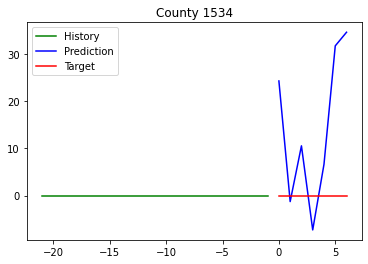

[ 1.  1.  1.  1.  1.  3.  4.  4.  6.  6.  6.  7.  8.  9. 10. 12. 14. 17.
 26. 27. 28.]
[31. 50. 70. 78. 79. 80. 82.]


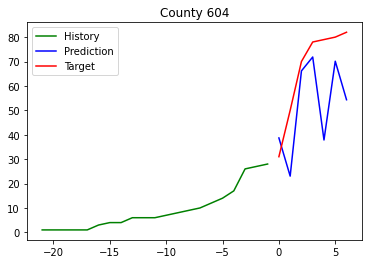

[ 0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  5.  8.  9. 13. 19. 27.
 39. 46. 48.]
[ 57.  68.  86. 113. 127. 140. 147.]


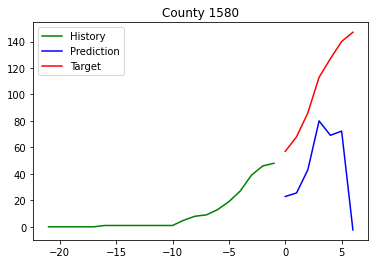

done
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.  0.  3.  4.  5.  8. 11.]


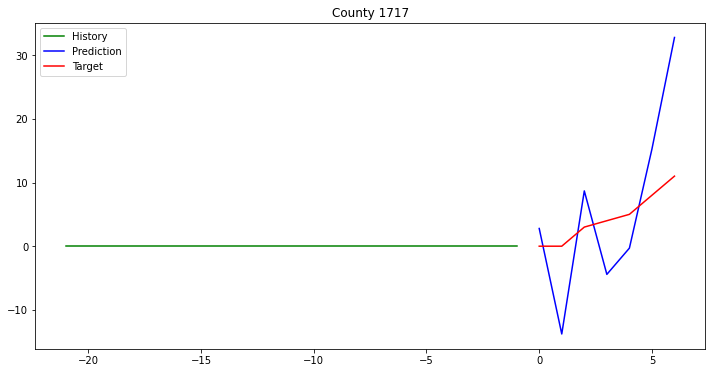

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 3. 3.]


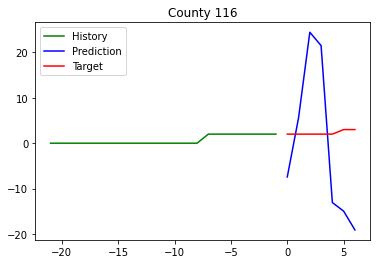

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 3. 3. 3. 4.]


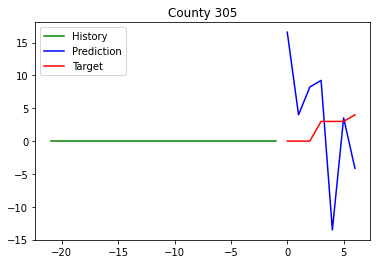

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 1. 1.]


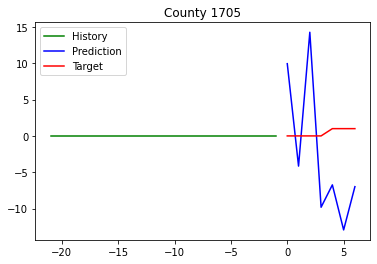

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1.  1.  2.  2.  2. 11. 16.]


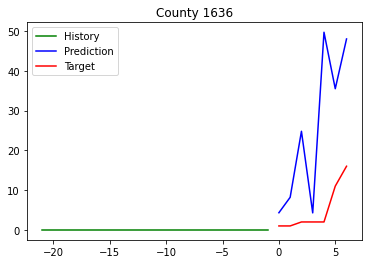

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


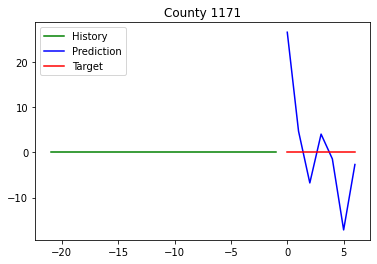

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


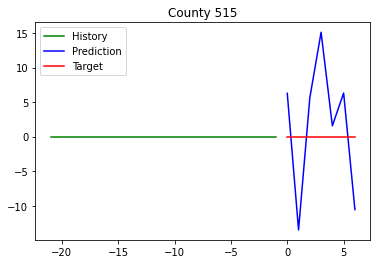

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


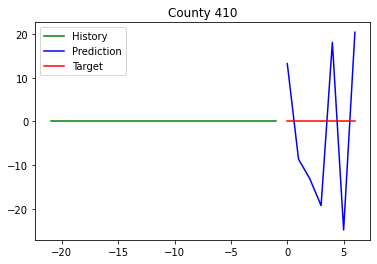

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


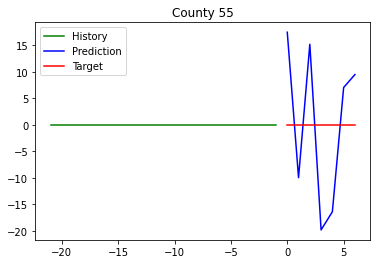

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 1. 3. 3. 3. 3. 3.]


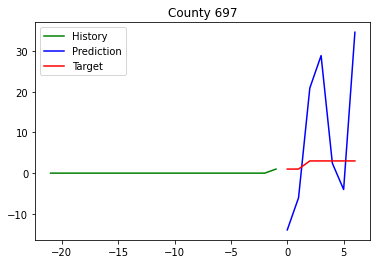

In [523]:
def rescale_e_values(category, values):
    scaled_values = data_tagged[category].min() + ((data_tagged[category].max() - data_tagged[category].min()) * values)
    return scaled_values

def create_time_steps(length):
    return list(range(-length, 0))

halfway = int(28084 / 2)
    
for x, y in e_testing.take(15):
    prediction = model(x)[0]
    all_targets = y[0]
    
    cpc_prediction = []
    cpc_target = []
    for i in range(0, len(prediction), 14):
        rescaled_predictions = rescale_e_values("cases", prediction[i:i+7])
        rescaled_targets = rescale_e_values("cases", all_targets[i:i+7])
        cpc_prediction.append(rescaled_predictions)
        cpc_target.append(rescaled_targets)
        
    cpc_history = []
    for county_observation in x[0]:
        # from 1 for deaths
        cpc_history_rescaled = rescale_e_values("cases", county_observation[0::11])
        cpc_history.append(cpc_history_rescaled)

    time_before = create_time_steps(cpc_history[0].shape[0])
    
    selector = np.arange(2006)
    np.random.shuffle(selector)
    selector = selector[:10]
    cpc_pred_plot = np.array(cpc_prediction)[selector]
    cpc_target_plot = np.array(cpc_target)[selector]
    relevant_history = np.array(cpc_history)[selector]
    print('done')
    plt.figure(figsize=(12, 6))
    for i in range(len(cpc_pred_plot)):
        time_after = np.arange(len(cpc_pred_plot[i]))
        plt.plot(time_before, relevant_history[i], 'g-', label='History')
        plt.plot(time_after, cpc_pred_plot[i], 'b-', label='Prediction')
        plt.plot(time_after, cpc_target_plot[i], 'r-', label='Target')
        plt.legend(loc='upper left')
        plt.title(f'County {selector[i]}')
        print(relevant_history[i])
        print(cpc_target_plot[i])
        plt.show()
    
#     plt.figure(figsize=(12, 6))
#     for e, (prediction, target) in enumerate(zip(cpc_prediction, cpc_target)):
#         history = cpc_history[e]
#         time_after = np.arange(len(prediction))
#         plt.plot(time_before, history, 'g-', label='History')
#         plt.plot(time_after, prediction, 'b-', label='Prediction')
#         plt.plot(time_after, target, 'r-', label='Target')
#         plt.legend(loc='upper left')
#         plt.title(f'County {e}')
#         plt.show()
#         break

In [524]:
model.save('./models/all_counties_correct')

INFO:tensorflow:Assets written to: ./models/all_counties_correct\assets


In [528]:
losses = []
for x, y in e_testing.take(-1):
    prediction = model(x)[0]
    all_target = y[0]
    
    cpc_prediction = []
    cpc_target = []
    
    for i in range(0, len(prediction), 14):
        rescaled_predictions = rescale_e_values("cases", prediction[i:i+7])
        rescaled_targets = rescale_e_values("cases", all_targets[i:i+7])
        loss = tf.keras.losses.MSE(rescaled_targets, rescaled_predictions)
        losses.append(loss)
print(len(losses))

10030


In [529]:
print(sum(losses) / len(losses))

tf.Tensor(13479.201, shape=(), dtype=float32)
